# モデルの選定と保存を行うノートブック
## V4_2
### ディレクトリに注意！！

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt

import seaborn
from pandas import DataFrame
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler #アンダーサンプリング用
from sklearn.model_selection import train_test_split
import pickle
# 機械学習用
from sklearn.cluster import KMeans #クラスタリング用
from sklearn.ensemble import RandomForestClassifier#ランダムフォレスト
from copy import deepcopy as cp
from sklearn.linear_model import LogisticRegression
import time
import datetime
from dateutil.relativedelta import relativedelta
import os #ディレクトリ作成用
import xgboost as xgb
import sys
from sklearn.preprocessing import StandardScaler#モデルの評価用に標準化する関数
import scipy.stats#モデルの評価用に標準化する関数
import warnings

#自作のモジュールのインポート
#sys.path.append("..")
import module.master as master
import module.modeling_scores as modeling


In [3]:
def get_season_date(now_date):#日付(datetime型)を渡すと，その日付で購買予測を行う際に使用するデータの区間を返す関数
    use_data_year=now_date.year
    if (now_date.month>=1)and(now_date.month<4):
        use_data_month=1
    elif (now_date.month>=4)and(now_date.month<7):
        use_data_month=4
    elif (now_date.month>=7)and(now_date.month<10):
        use_data_month=7
    elif (now_date.month>=10):
        use_data_month=10
    else:
        print('what???????')
    use_data_date=datetime.datetime(year=use_data_year, month=use_data_month,day=1)
    return use_data_date


def get_4_section_dt(now_date):#今いる区間から直近4区間の開始日をリストで返してくれる関数
    now_sec_date=get_season_date(now_date)
    diff_sec_stdates=[0]*4
    for i in range(len(diff_sec_stdates)):
        diff_sec_stdates[3-i]=now_sec_date- relativedelta(months=3*(i+1))#古い順に日付を入れていく
    return diff_sec_stdates

def get_feature_weights(score_final_df):#相関係数を変数の重みとして取得する関数，（1comあたり1行のdfを返す．）(引数として一つ前の区間,もしくは昨年同月区間のfinalありスコアのdfを渡す)
    plus_m_th=1
    num_hit_th=3
    feature_weights_df=pd.DataFrame()
    for com in sorted(score_final_df['target_com'].value_counts().sort_index().index):
        target_com_df=score_final_df[score_final_df['target_com']==com]
        #ざっと切り捨て，あまりに少ないのは適さないと思うので消す
        target_com_df=target_com_df[target_com_df['plus_month_num_test']>=plus_m_th].copy()#収益がプラスだった月の数で切り捨てる
        target_com_df=target_com_df[target_com_df['num_hit_test']>=num_hit_th].copy()#的中した予測の数で切り捨てる，大体一カ月に一件くらいをイメージ
        target_com_corr=target_com_df.corr()
        target_com_weights=target_com_corr.loc['gain_final']['total_get_test':'diff_mea_med_test']#相関係数を代用した変数ごとの重みづけ        
        feature_weights_df=feature_weights_df.append(target_com_weights)
    feature_weights_df['target_com']=score_final_df['target_com'].value_counts().sort_index().index
    feature_weights_df=feature_weights_df.set_index('target_com')
    feature_weights_df=feature_weights_df.fillna(0)
    return feature_weights_df


def add_std_score(good_model_df,feature_weights):#偏差値と相関係数をもとにしたスコアを与える
    add_score_df=pd.DataFrame()
    for com in sorted(good_model_df['target_com'].value_counts().sort_index().index):
        target_com_df=good_model_df[good_model_df['target_com']==com]
        #display(feature_weights)
        for f_name,weight in feature_weights.items():
            target_com_df.loc[:,'{}_score'.format(f_name)]=scipy.stats.zscore(target_com_df['{}'.format(f_name)].values)
            target_com_df.loc[:,'{}_score'.format(f_name)]=target_com_df['{}_score'.format(f_name)]*weight
        target_com_df=target_com_df.fillna(0)
        target_com_df['score']=0
        for f_name in feature_weights.index:
            target_com_df['score']=target_com_df['score']+target_com_df['{}_score'.format(f_name)]
        #display(target_com_df)
        add_score_df=pd.concat([add_score_df, target_com_df], axis=0)#きめのパラメータで切り落としたので結合
    
    return add_score_df

def add_std_score_DFversion(good_model_df,feature_weights_df):#偏差値と相関係数をもとにしたスコアを与える
    add_score_df=pd.DataFrame()
    for com in sorted(good_model_df['target_com'].value_counts().sort_index().index):
        target_com_df=good_model_df[good_model_df['target_com']==com]
        feature_weights=feature_weights_df.loc[com].copy()
        #display(feature_weights)
        for f_name,weight in feature_weights.items():
            target_com_df.loc[:,'{}_score'.format(f_name)]=scipy.stats.zscore(target_com_df['{}'.format(f_name)].values)
            target_com_df.loc[:,'{}_score'.format(f_name)]=target_com_df['{}_score'.format(f_name)]*weight
        target_com_df=target_com_df.fillna(0)
        target_com_df['score']=0
        for f_name in feature_weights.index:
            target_com_df['score']=target_com_df['score']+target_com_df['{}_score'.format(f_name)]
        #display(target_com_df)
        add_score_df=pd.concat([add_score_df, target_com_df], axis=0)#きめのパラメータで切り落としたので結合
    
    return add_score_df



def select_use_model(model_std_score_df):#相関係数と標準偏差によって与えられたscoreをもとに最終的に使用するモデルを選定する関数
    use_model_df=pd.DataFrame()
    for com in sorted(model_std_score_df['target_com'].value_counts().index):
        target_com_df=model_std_score_df[model_std_score_df['target_com']==com].copy()
        com_selected_row=target_com_df.sort_values('score', ascending=False).iloc[:1]
        #use_model_df=pd.concat([use_model_df, com_selected_row], axis=0)#きめのパラメータで切り落としたので結合
        use_model_df=use_model_df.append(com_selected_row,ignore_index=True)
    return use_model_df


def twin_plt(x,y1,y2,x_n,y1_n,y2_n):#2本軸でのグラフの描写
    fig = plt.figure(figsize=(19,8))
    plt.tick_params(colors='black')
    plt.rcParams["font.size"] = 18
    
    ax1 = fig.add_subplot()
    fig.set_facecolor(color='white')
    ax1.plot(x, y1,label=y1_n, marker="o")
    ax1.tick_params()
    plt.ylim(80, 200)
    ax2 = ax1.twinx()
    #print(y2)
    ax2.plot(x, y2,label=y2_n,color='red', marker="*")
    ax1.axhline(100,ls = "-.",color='green')
    #ax2.tick_params(colors='white')
    ax2.tick_params()

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc='lower center')

    #ax1.set_xlabel(x_n,color='white')
    #ax1.set_ylabel(y1_n,color='white')
    #ax2.set_ylabel(y2_n,color='white')
    ax1.set_xlabel(x_n)
    ax1.set_ylabel(y1_n)
    ax2.set_ylabel(y2_n)
    plt.show()
    return None

In [4]:
version='V4_2'#バージョン
#use_modelの書き込み先作成のための箱作り
place_master=master.get_place_master()
for place in place_master.items():
    #print(place[0],place[1],'\n')
    place_name=place[1]
    dir_path = "../bot_database/{place_name}/model_score_{place_name}/use_model/{version}".format(place_name=place_name,version=version)#作成したデータの書き込み先#使用するデータの読み込み
    if os.path.exists(dir_path)==False:
        os.makedirs(dir_path)
    else:
        pass

## 使用するモデルの選定と，選定したモデルのパラメータシートを出力
相関係数と偏差値によって使用するモデルの出力を行う

In [5]:
#warnings.simplefilter('ignore')
#相関係数と全体分析の結果をもとに最終的に使用するモデルを選定する
place_master=master.get_place_master()
place_names=[place_name for place_name in place_master.values()]#会場名のみを収納した配列
#絶対に固定のパラメータたち
#plus_m_th=2
plus_m_th=1
#plus_m_th=3
#num_hit_th=5
num_hit_th=3
version='V4_2'
mode='model_score_period_'
mode_type='period'
# mode='model_score_'
# mode_type='recent'
#today=datetime.date.today()#今日の日付の取得
today=datetime.datetime(year=2021, month=10,day=1)
now_date=today

#コード本文

#for place_name in place_names[:10]:
for place_name in place_names:
    #place_name='kiryu'

    diff_sec_dates=get_4_section_dt(now_date)#直近４区間の開始日をリストで取得
    now_date_txt=now_date.strftime('%Y%m%d')
    diff_sec_dates=diff_sec_dates[1:]#テスト時のみの特別処理！！データが１区間だけ足りないので今回はスルーする
    #閾値にあてはまった　モデルたちがどんな奴らなのかを確認する
    for i in range(len(diff_sec_dates)):
        sec_date=diff_sec_dates[i]
        sec_date_txt=sec_date.strftime('%Y%m%d')
        #csv_path='../../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{version}_{mode_type}_TRhit_pM{plus_month}_st{now_ym}_total_analysis.csv'.format(place_name=place_name,mode_type=mode_type,version=version,plus_month=plus_m_th,num_hit=num_hit_th,now_ym=now_date_txt)
        csv_path='../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{version}_{mode_type}_TRhit_pM{plus_month}_st{now_ym}_total_analysis.csv'.format(place_name=place_name,mode_type=mode_type,version=version,plus_month=plus_m_th,now_ym=sec_date_txt)
        totol_analysis_df=pd.read_csv(csv_path, encoding='utf_8_sig')
        totol_analysis_df=totol_analysis_df.drop(["Unnamed: 0"],axis=1)
        print('place_name:',place_name,'========================================================================================')
        #閾値の取得
        #th_s=totol_analysis_df[totol_analysis_df['num_plus_com_mean']>5].sort_values('minus_model_per_mean').iloc[0]#plusだったcom数の平均が２より大きい
        th_s=totol_analysis_df[totol_analysis_df['num_plus_com_mean']>2].sort_values('minus_model_per_mean').iloc[0]#plusだったcom数の平均が２より大きい
        #display(th_s)
        select_model_df=pd.DataFrame()
        #print('now_date:',sec_date_txt)
        dir_path='../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{place_name}_{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=sec_date_txt,version=version)
        model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
        model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
        model_score_df=model_score_df[model_score_df['target_com']<21]
        #選定したパラメータで切り落とし
#         select_model_df=model_score_df[model_score_df['num_hit_test']>=num_hit_th]
#         select_model_df=model_score_df[model_score_df['plus_month_num_test']>=plus_m_th]
        selected_m=model_score_df[model_score_df['gain_test']>=th_s["gain_th"]].copy()
        selected_m=selected_m[selected_m['gain_std_test']<=th_s["gain_std_th"]].copy()
        selected_m=selected_m[selected_m['buy_hit_per_test']>=th_s["hit_per_th"]].copy()
        selected_m=selected_m[selected_m['buy_hit_per_std_test']<=th_s["hit_std_th"]].copy()
        selected_m=selected_m[selected_m['num_hit_test']>=th_s["num_hit_th"]].copy()#的中した予測の数で切り捨てる,これも可変していく方針に変更した        
        select_model_df=pd.concat([select_model_df, selected_m], axis=0)#きめのパラメータで切り落としたので結合
        display(select_model_df)
        if len(select_model_df)==0:
            pass
        else:
            #偏差値評価を用いた実際に使用するモデルの切り抜き(方針：使用する区間の１つ前の区間(test5,final3の区間))をもとに相関係数を算出
            #date_cal_std=sec_date- relativedelta(months=3)#一つ前の区間の日付を切り抜く(1区間前のfinalありから収益との相関係数を算出したい)
            date_cal_std=sec_date- relativedelta(months=12)#昨年同月の区間の日付を切り抜く(昨年同月ののfinalありから収益との相関係数を算出したい) 
            date_cal_std_txt=date_cal_std.strftime('%Y%m%d')
            dir_path='../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{place_name}_{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=date_cal_std_txt,version=version)
                        
            model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
            model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
            model_score_df=model_score_df[model_score_df['target_com']<21]
            #display(get_feature_weights(model_score_df))
            #決めのパラメータでいったん切り落とし
            model_score_df=model_score_df[model_score_df['plus_month_num_test']>=plus_m_th].copy()#収益がプラスだった月の数で切り捨てる
            model_score_df=model_score_df[model_score_df['num_hit_test']>=num_hit_th].copy()#的中した予測の数で切り捨てる，大体一カ月に一件くらいをイメージ
            #display(model_score_df)
            version_corr_df=model_score_df.corr()
            feature_weights=version_corr_df.loc['gain_final']['total_get_test':'diff_mea_med_test']#相関係数を代用した変数ごとの重みづけ
            #feature_weights_df=get_feature_weights(model_score_df)
            #display(feature_weights_df)
            #model_std_score_df=add_std_score_DFversion(select_model_df,feature_weights_df)
            model_std_score_df=add_std_score(select_model_df,feature_weights)
        #     if place_name=='toda':
        #         model_std_score_df.to_csv('csv/toda_{dt}.csv'.format(dt=now_ym))
            #model_std_score_df.to_csv('ex.csv')
            use_models=select_use_model(model_std_score_df)#相関係数と標準偏差によって与えられたscoreをもとに最終的に使用するモデルを選定する関数
            #dir_path = "../bot_database/{place_name}/model_score_{place_name}/use_model/{version}/use_model_{place_name}_{now_ym}_{version}.csv".format(place_name=place_name,version=version,now_ym=sec_date_txt)#作成したデータの書き込み先#使用するデータの読み込み
            dir_path = "../bot_database/{place_name}/model_score_{place_name}/use_model/{version}/use_model_{place_name}_{now_ym}_{version}_{mode_type}.csv".format(place_name=place_name,version=version,now_ym=sec_date_txt,mode_type=mode_type)#作成したデータの書き込み先#使用するデータの読み込み
            use_models.to_csv(dir_path)

place_name: kiryu ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
22,1.0,5.0,88.0,0.54,20520.0,21200.0,42.0,212.0,96.792453,28.510258,...,23600.0,38.0,236.0,83.220339,19.611417,28.0,11.864407,1.362098,0.0,39.317766
24,1.0,5.0,89.0,0.50,23530.0,24400.0,42.0,244.0,96.434426,48.170770,...,27600.0,38.0,276.0,74.927536,19.853271,29.0,10.507246,1.371717,0.0,38.988095
60,1.0,5.0,101.0,0.50,20520.0,21200.0,42.0,212.0,96.792453,28.956772,...,24000.0,38.0,240.0,81.833333,18.272438,28.0,11.666667,1.339396,0.0,39.317766
63,1.0,5.0,102.0,0.50,20520.0,21300.0,42.0,213.0,96.338028,27.695728,...,23500.0,38.0,235.0,83.574468,19.174829,28.0,11.914894,1.367894,0.0,39.317766
66,1.0,5.0,103.0,0.50,19590.0,20600.0,42.0,206.0,95.097087,32.244475,...,23600.0,38.0,236.0,83.220339,18.846791,28.0,11.864407,1.362098,0.0,39.317766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6540,13.0,7.0,161.0,0.50,7740.0,7500.0,20.0,75.0,103.200000,40.258017,...,7600.0,15.0,76.0,101.052632,112.225451,7.0,9.210526,3.311331,1.0,154.000000
6543,13.0,7.0,162.0,0.50,7740.0,7300.0,20.0,73.0,106.027397,41.149882,...,7600.0,15.0,76.0,101.052632,117.252678,7.0,9.210526,3.311331,1.0,154.000000
6546,13.0,7.0,163.0,0.50,7740.0,7200.0,20.0,72.0,107.500000,45.785826,...,7900.0,15.0,79.0,146.455696,187.087780,8.0,10.126582,3.867152,1.0,188.888889
6549,13.0,7.0,164.0,0.50,7740.0,7600.0,20.0,76.0,101.842105,43.874666,...,7600.0,15.0,76.0,101.052632,122.443013,7.0,9.210526,3.311331,1.0,154.000000


place_name: kiryu ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
1514,4.0,5.0,81.0,0.58,18720.0,19500.0,15.0,195.0,96.000000,35.209151,...,16200.0,9.0,162.0,67.407407,51.530088,6.0,3.703704,0.617284,1.0,76.666667
1769,4.0,7.0,82.0,0.58,18720.0,19300.0,15.0,193.0,96.994819,36.308625,...,15900.0,9.0,159.0,59.433962,49.391720,5.0,3.144654,0.363113,1.0,0.000000
3024,7.0,5.0,81.0,0.50,35190.0,29200.0,19.0,292.0,120.513699,2.322802,...,28200.0,17.0,282.0,67.872340,38.962002,15.0,5.319149,0.614202,1.0,397.777778
3025,7.0,5.0,81.0,0.54,32510.0,25300.0,19.0,253.0,128.498024,21.386367,...,23900.0,17.0,239.0,66.443515,61.918770,14.0,5.857741,0.639132,1.0,304.000000
3026,7.0,5.0,81.0,0.58,32510.0,20100.0,19.0,201.0,161.741294,20.169540,...,19500.0,17.0,195.0,60.205128,102.269452,11.0,5.641026,1.290570,1.0,150.277778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3420,7.0,7.0,129.0,0.50,15070.0,14400.0,19.0,144.0,104.652778,33.434771,...,14600.0,17.0,146.0,62.945205,95.502139,9.0,6.164384,1.186336,1.0,182.500000
3423,7.0,7.0,130.0,0.50,15070.0,14300.0,19.0,143.0,105.384615,29.106909,...,13800.0,17.0,138.0,66.594203,94.458864,9.0,6.521739,1.255109,1.0,182.500000
3426,7.0,7.0,131.0,0.50,15070.0,14200.0,19.0,142.0,106.126761,30.571449,...,14200.0,17.0,142.0,64.718310,98.533224,9.0,6.338028,1.219754,1.0,182.500000
3429,7.0,7.0,132.0,0.50,15070.0,13900.0,19.0,139.0,108.417266,34.452676,...,13800.0,17.0,138.0,66.594203,91.104905,9.0,6.521739,1.255109,1.0,182.500000


place_name: kiryu ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
3782,8.0,7.0,81.0,0.58,29190.0,20800.0,11.0,208.0,140.336538,165.532871,...,24900.0,10.0,249.0,39.678715,31.094042,7.0,2.811245,0.83601,0.0,181.388889


place_name: toda ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
1513,4.0,5.0,81.0,0.54,56230.0,30000.0,20.0,300.0,187.433333,51.955722,...,27900.0,22.0,279.0,148.028674,81.509012,18.0,6.451613,0.948298,2.0,343.988095
1516,4.0,5.0,82.0,0.54,56230.0,29500.0,20.0,295.0,190.610169,53.192378,...,27500.0,22.0,275.0,142.436364,91.610382,17.0,6.181818,1.168927,2.0,307.321429
1517,4.0,5.0,82.0,0.58,34150.0,19600.0,20.0,196.0,174.234694,44.544324,...,20200.0,22.0,202.0,127.128713,99.749434,14.0,6.930693,1.591362,2.0,144.444444
1519,4.0,5.0,83.0,0.54,56230.0,28600.0,20.0,286.0,196.608392,55.524760,...,26600.0,22.0,266.0,147.255639,90.399062,17.0,6.390977,1.208478,2.0,307.321429
1520,4.0,5.0,83.0,0.58,34150.0,18900.0,20.0,189.0,180.687831,38.513875,...,19600.0,22.0,196.0,117.091837,88.215698,13.0,6.632653,1.472832,2.0,194.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9021,18.0,7.0,148.0,0.50,28910.0,11800.0,8.0,118.0,245.000000,78.646281,...,10100.0,4.0,101.0,82.772277,83.966000,3.0,2.970297,0.990099,1.0,0.000000
9024,18.0,7.0,149.0,0.50,28910.0,11800.0,8.0,118.0,245.000000,91.179939,...,9900.0,4.0,99.0,84.444444,89.771016,3.0,3.030303,1.010101,1.0,0.000000
9027,18.0,7.0,150.0,0.50,23870.0,11700.0,8.0,117.0,204.017094,7.068786,...,9700.0,4.0,97.0,86.185567,86.526678,3.0,3.092784,1.030928,1.0,0.000000
9030,18.0,7.0,151.0,0.50,22270.0,12100.0,8.0,121.0,184.049587,143.188417,...,9500.0,4.0,95.0,88.000000,83.693936,3.0,3.157895,1.052632,1.0,0.000000


place_name: toda ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final


place_name: toda ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
65,1.0,5.0,102.0,0.58,9480.0,5900.0,38.0,59.0,160.677966,120.541601,...,4700.0,32.0,47.0,144.680851,7.140692,7.0,14.893617,1.228405,3.0,-8.888889
124,1.0,5.0,122.0,0.54,9480.0,5900.0,38.0,59.0,160.677966,138.084607,...,4800.0,32.0,48.0,127.500000,61.547365,7.0,14.583333,3.182344,2.0,3.333333
397,1.0,7.0,129.0,0.54,9480.0,5900.0,38.0,59.0,160.677966,120.541601,...,5200.0,32.0,52.0,145.769231,39.695645,8.0,15.384615,1.110289,3.0,82.222222
584,2.0,5.0,107.0,0.58,5250.0,2800.0,17.0,28.0,187.500000,125.833182,...,4400.0,19.0,44.0,122.045455,62.024632,5.0,11.363636,1.312160,2.0,0.000000
872,2.0,7.0,119.0,0.58,4710.0,2700.0,17.0,27.0,174.444444,137.759150,...,4000.0,19.0,40.0,134.250000,43.644967,5.0,12.500000,1.443376,2.0,0.000000
919,2.0,7.0,135.0,0.54,5250.0,3100.0,17.0,31.0,169.354839,112.351426,...,4500.0,19.0,45.0,119.333333,58.569833,5.0,11.111111,1.283001,2.0,0.000000


place_name: edogawa ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
3053,7.0,5.0,90.0,0.58,14520.0,12000.0,18.0,120.0,121.000000,36.786462,...,11700.0,23.0,117.0,103.504274,66.731415,7.0,5.982906,1.305577,2.0,-55.833333
3097,7.0,5.0,105.0,0.54,14520.0,12600.0,18.0,126.0,115.238095,36.910997,...,10600.0,23.0,106.0,69.716981,50.153395,5.0,4.716981,0.544670,1.0,0.000000
3103,7.0,5.0,107.0,0.54,13670.0,11700.0,18.0,117.0,116.837607,51.595361,...,9000.0,23.0,90.0,82.111111,56.910084,5.0,5.555556,0.641500,2.0,0.000000
3153,7.0,5.0,124.0,0.50,14520.0,12400.0,18.0,124.0,117.096774,29.779651,...,8000.0,23.0,80.0,71.750000,93.906511,4.0,5.000000,0.721688,1.0,0.000000
3156,7.0,5.0,125.0,0.50,14520.0,12300.0,18.0,123.0,118.048780,37.596710,...,7900.0,23.0,79.0,111.012658,95.414544,5.0,6.329114,0.730823,2.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9423,19.0,7.0,114.0,0.50,23410.0,19500.0,7.0,195.0,120.051282,70.746791,...,15900.0,2.0,159.0,20.566038,47.198385,1.0,0.628931,0.363113,0.0,0.000000
9429,19.0,7.0,116.0,0.50,23410.0,18500.0,7.0,185.0,126.540541,71.013467,...,15500.0,2.0,155.0,21.096774,52.442649,1.0,0.645161,0.372484,0.0,0.000000
9435,19.0,7.0,118.0,0.50,23410.0,17700.0,7.0,177.0,132.259887,76.693162,...,15400.0,2.0,154.0,21.233766,53.941011,1.0,0.649351,0.374903,0.0,0.000000
9438,19.0,7.0,119.0,0.50,23410.0,17400.0,7.0,174.0,134.540230,82.818062,...,14500.0,2.0,145.0,22.551724,58.997981,1.0,0.689655,0.398173,1.0,0.000000


place_name: edogawa ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final


place_name: edogawa ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
157,1.0,5.0,133.0,0.54,4860.0,4800.0,21.0,48.0,101.250000,20.998674,...,2700.0,17.0,27.0,80.740741,114.420326,3.0,11.111111,6.415003,1.0,-14.444444
160,1.0,5.0,134.0,0.54,4860.0,4300.0,21.0,43.0,113.023256,32.001905,...,2700.0,17.0,27.0,80.740741,114.420326,3.0,11.111111,6.415003,1.0,-14.444444
163,1.0,5.0,135.0,0.54,4860.0,4700.0,21.0,47.0,103.404255,18.412398,...,2700.0,17.0,27.0,80.740741,104.885299,3.0,11.111111,6.415003,1.0,-14.444444
377,1.0,7.0,122.0,0.58,4860.0,4800.0,21.0,48.0,101.250000,20.998674,...,2800.0,17.0,28.0,77.857143,104.885299,3.0,10.714286,6.185896,1.0,-14.444444
383,1.0,7.0,124.0,0.58,4860.0,4800.0,21.0,48.0,101.250000,25.340552,...,2800.0,17.0,28.0,77.857143,104.885299,3.0,10.714286,6.185896,1.0,-14.444444
386,1.0,7.0,125.0,0.58,4860.0,4400.0,21.0,44.0,110.454545,27.969238,...,2700.0,17.0,27.0,80.740741,114.420326,3.0,11.111111,6.415003,1.0,-14.444444
392,1.0,7.0,127.0,0.58,4860.0,4000.0,21.0,40.0,121.500000,46.229065,...,2200.0,17.0,22.0,99.090909,139.847065,3.0,13.636364,7.872958,1.0,-14.444444
395,1.0,7.0,128.0,0.58,4860.0,3900.0,21.0,39.0,124.615385,44.566891,...,2300.0,17.0,23.0,94.782609,125.862359,3.0,13.043478,7.530656,1.0,-14.444444
445,1.0,7.0,145.0,0.54,4860.0,4300.0,21.0,43.0,113.023256,32.892565,...,3200.0,17.0,32.0,68.125000,96.817199,3.0,9.375000,5.412659,1.0,-14.444444
448,1.0,7.0,146.0,0.54,4860.0,4500.0,21.0,45.0,108.000000,36.197376,...,2800.0,17.0,28.0,77.857143,125.862359,3.0,10.714286,6.185896,1.0,-14.444444


place_name: heiwazima ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
2709,6.0,5.0,144.0,0.50,11080.0,7100.0,25.0,71.0,156.056338,35.663379,...,7700.0,10.0,77.0,54.935065,27.755547,5.0,6.493506,1.499611,0.0,-22.222222
2712,6.0,5.0,145.0,0.50,11080.0,7300.0,25.0,73.0,151.780822,45.027254,...,7300.0,10.0,73.0,57.945205,27.701471,5.0,6.849315,1.581782,0.0,-22.222222
2715,6.0,5.0,146.0,0.50,10480.0,6400.0,25.0,64.0,163.750000,49.307134,...,7200.0,10.0,72.0,58.750000,31.042217,5.0,6.944444,1.603751,0.0,-22.222222
2724,6.0,5.0,149.0,0.50,10480.0,5800.0,25.0,58.0,180.689655,37.882897,...,6200.0,10.0,62.0,35.645161,28.716234,3.0,4.838710,1.612903,0.0,0.000000
2985,6.0,7.0,152.0,0.50,10480.0,6800.0,25.0,68.0,154.117647,36.546406,...,7400.0,10.0,74.0,40.270270,38.077643,4.0,5.405405,2.064223,0.0,-22.222222
2994,6.0,7.0,155.0,0.50,10480.0,6300.0,25.0,63.0,166.349206,33.798331,...,6800.0,10.0,68.0,43.823529,45.235837,4.0,5.882353,2.246361,0.0,-22.222222
3528,8.0,5.0,81.0,0.50,66120.0,37300.0,15.0,373.0,177.265416,30.628814,...,24800.0,14.0,248.0,89.717742,13.980830,12.0,4.838710,0.403226,0.0,232.055556
3531,8.0,5.0,82.0,0.50,66120.0,37000.0,15.0,370.0,178.702703,36.790504,...,24000.0,14.0,240.0,77.791667,18.463166,11.0,4.583333,0.481125,0.0,159.555556
3534,8.0,5.0,83.0,0.50,66120.0,36700.0,15.0,367.0,180.163488,33.842501,...,23300.0,14.0,233.0,80.128755,16.968760,11.0,4.721030,0.495580,0.0,159.555556
3537,8.0,5.0,84.0,0.50,66120.0,36600.0,15.0,366.0,180.655738,33.538782,...,23300.0,14.0,233.0,80.128755,19.462403,11.0,4.721030,0.495580,1.0,159.555556


place_name: heiwazima ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
632,2.0,5.0,123.0,0.58,6100.0,3200.0,18.0,32.0,190.625000,89.485443,...,1800.0,13.0,18.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
679,2.0,5.0,139.0,0.54,6100.0,3600.0,18.0,36.0,169.444444,48.916183,...,2200.0,13.0,22.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
682,2.0,5.0,140.0,0.54,6100.0,3600.0,18.0,36.0,169.444444,62.498727,...,1700.0,13.0,17.0,47.058824,76.980036,1.0,5.882353,3.396178,1.0,0.000000
685,2.0,5.0,141.0,0.54,6100.0,2800.0,18.0,28.0,217.857143,92.920311,...,1600.0,13.0,16.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
738,2.0,5.0,159.0,0.50,6100.0,3700.0,18.0,37.0,164.864865,61.230187,...,1900.0,13.0,19.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5865,12.0,7.0,104.0,0.50,29730.0,18200.0,10.0,182.0,163.351648,147.324867,...,15200.0,8.0,152.0,170.131579,213.102496,6.0,3.947368,0.657895,2.0,-75.555556
5868,12.0,7.0,105.0,0.50,29730.0,18000.0,10.0,180.0,165.166667,149.158174,...,14900.0,8.0,149.0,123.557047,87.848805,5.0,3.355705,1.025185,1.0,-75.555556
5874,12.0,7.0,107.0,0.50,29730.0,17400.0,10.0,174.0,170.862069,150.028062,...,14200.0,8.0,142.0,129.647887,86.985002,5.0,3.521127,1.075722,2.0,-75.555556
5877,12.0,7.0,108.0,0.50,29730.0,16800.0,10.0,168.0,176.964286,158.559112,...,13800.0,8.0,138.0,133.405797,90.705611,5.0,3.623188,1.106902,2.0,-75.555556


place_name: heiwazima ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
2396,5.0,7.0,123.0,0.58,9650.0,5800.0,29.0,58.0,166.379310,69.091681,...,5600.0,18.0,56.0,75.714286,73.927491,4.0,7.142857,1.030983,1.0,0.000000
2402,5.0,7.0,125.0,0.58,9650.0,5800.0,29.0,58.0,166.379310,61.107755,...,5000.0,18.0,50.0,84.800000,79.207520,4.0,8.000000,1.154701,1.0,0.000000
4103,9.0,5.0,104.0,0.58,13570.0,8200.0,19.0,82.0,165.487805,50.049923,...,8000.0,19.0,80.0,30.500000,56.349386,2.0,2.500000,1.443376,0.0,0.000000
4106,9.0,5.0,105.0,0.58,13570.0,8000.0,19.0,80.0,169.625000,55.067412,...,8200.0,19.0,82.0,29.756098,52.175358,2.0,2.439024,1.408171,0.0,0.000000
4118,9.0,5.0,109.0,0.58,13570.0,7800.0,19.0,78.0,173.974359,55.103439,...,7400.0,19.0,74.0,32.972973,61.249333,2.0,2.702703,1.560406,1.0,0.000000
4124,9.0,5.0,111.0,0.58,11610.0,6800.0,19.0,68.0,170.735294,45.640889,...,6400.0,19.0,64.0,18.437500,30.966969,1.0,1.562500,0.902110,0.0,0.000000
4127,9.0,5.0,112.0,0.58,11610.0,7000.0,19.0,70.0,165.857143,31.841296,...,6100.0,19.0,61.0,40.000000,70.436733,2.0,3.278689,1.892952,1.0,0.000000
4130,9.0,5.0,113.0,0.58,11610.0,6300.0,19.0,63.0,184.285714,46.080621,...,5400.0,19.0,54.0,21.851852,35.856490,1.0,1.851852,1.069167,0.0,0.000000
4133,9.0,5.0,114.0,0.58,11610.0,5900.0,19.0,59.0,196.779661,35.586409,...,5200.0,19.0,52.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
4142,9.0,5.0,117.0,0.58,11610.0,5900.0,19.0,59.0,196.779661,37.709943,...,4300.0,19.0,43.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000


place_name: tamagawa ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
1130,3.0,5.0,121.0,0.58,6670.0,4000.0,19.0,40.0,166.750000,107.096707,...,4300.0,24.0,43.0,150.000000,177.500362,7.0,16.279070,1.342675,3.0,3.333333
1133,3.0,5.0,122.0,0.58,6670.0,3900.0,19.0,39.0,171.025641,127.998036,...,4500.0,24.0,45.0,205.111111,244.269987,9.0,20.000000,2.222222,3.0,73.333333
1174,3.0,5.0,136.0,0.54,6670.0,4300.0,19.0,43.0,155.116279,64.980187,...,5500.0,24.0,55.0,152.727273,113.350070,8.0,14.545455,2.099456,2.0,73.333333
1183,3.0,5.0,139.0,0.54,6670.0,4200.0,19.0,42.0,158.809524,62.898473,...,5000.0,24.0,50.0,129.000000,71.898001,7.0,14.000000,1.154701,2.0,3.333333
1251,3.0,5.0,162.0,0.50,6670.0,4100.0,19.0,41.0,162.682927,70.370553,...,4800.0,24.0,48.0,119.583333,71.414335,6.0,12.500000,0.000000,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5970,12.0,7.0,139.0,0.50,20180.0,13000.0,12.0,130.0,155.230769,52.335478,...,11400.0,10.0,114.0,94.473684,199.432010,5.0,4.385965,1.826023,1.0,-8.333333
5973,12.0,7.0,140.0,0.50,20180.0,12400.0,12.0,124.0,162.741935,68.139867,...,10600.0,10.0,106.0,88.679245,179.989663,4.0,3.773585,1.441062,1.0,-62.222222
5976,12.0,7.0,141.0,0.50,20180.0,12700.0,12.0,127.0,158.897638,61.430064,...,10200.0,10.0,102.0,116.862745,164.463475,5.0,4.901961,1.132059,1.0,-62.222222
5979,12.0,7.0,142.0,0.50,20180.0,11700.0,12.0,117.0,172.478632,63.496007,...,9600.0,10.0,96.0,124.166667,187.727551,5.0,5.208333,1.202813,1.0,-62.222222


place_name: tamagawa ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
2018,5.0,5.0,81.0,0.58,25820.0,15400.0,23.0,154.0,167.662338,21.244495,...,14100.0,27.0,141.0,103.049645,84.782202,12.0,8.510638,2.456810,2.0,108.888889
2021,5.0,5.0,82.0,0.58,25820.0,15100.0,23.0,151.0,170.993377,16.460658,...,13700.0,27.0,137.0,96.350365,81.055893,11.0,8.029197,2.346387,2.0,117.555556
2027,5.0,5.0,84.0,0.58,25820.0,14300.0,23.0,143.0,180.559441,20.642710,...,12500.0,27.0,125.0,99.600000,81.060021,10.0,8.000000,2.309401,2.0,100.000000
2036,5.0,5.0,87.0,0.58,20270.0,12700.0,23.0,127.0,159.606299,64.297993,...,10600.0,27.0,106.0,110.660377,95.876041,9.0,8.490566,2.495992,2.0,133.666667
2042,5.0,5.0,89.0,0.58,20270.0,11700.0,23.0,117.0,173.247863,59.708994,...,9700.0,27.0,97.0,108.041237,98.940012,8.0,8.247423,2.380826,2.0,151.666667
2062,5.0,5.0,96.0,0.54,25820.0,16400.0,23.0,164.0,157.439024,13.150931,...,13700.0,27.0,137.0,90.875912,75.384899,10.0,7.299270,2.107118,2.0,100.000000
2077,5.0,5.0,101.0,0.54,22280.0,14100.0,23.0,141.0,158.014184,25.181641,...,11800.0,27.0,118.0,105.508475,90.394815,10.0,8.474576,2.446399,2.0,100.000000
2083,5.0,5.0,103.0,0.54,22280.0,12500.0,23.0,125.0,178.240000,37.371023,...,10500.0,27.0,105.0,118.571429,103.204164,10.0,9.523810,2.749287,2.0,100.000000
2086,5.0,5.0,104.0,0.54,18520.0,11900.0,23.0,119.0,155.630252,12.810096,...,10400.0,27.0,104.0,119.711538,112.661215,10.0,9.615385,2.775722,2.0,100.000000
2115,5.0,5.0,114.0,0.50,25820.0,16500.0,23.0,165.0,156.484848,11.681661,...,14000.0,27.0,140.0,88.928571,81.599248,10.0,7.142857,2.061965,2.0,100.000000


place_name: tamagawa ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
2904,6.0,7.0,125.0,0.5,24460.0,13800.0,22.0,138.0,177.246377,200.283856,...,16200.0,24.0,162.0,79.259259,52.450331,10.0,6.17284,0.356389,1.0,137.777778


place_name: hamanako ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
0,1.0,5.0,81.0,0.50,33490.0,38300.0,38.0,383.0,87.441253,29.430923,...,33900.0,44.0,339.0,105.575221,7.995300,35.0,10.324484,0.948245,2.0,101.895604
2,1.0,5.0,81.0,0.58,13950.0,14800.0,38.0,148.0,94.256757,47.444664,...,13700.0,44.0,137.0,120.802920,19.634643,19.0,13.868613,1.114982,2.0,32.944444
3,1.0,5.0,82.0,0.50,32040.0,37100.0,38.0,371.0,86.361186,33.735297,...,32800.0,44.0,328.0,98.536585,12.703422,33.0,10.060976,0.806631,1.0,79.188034
5,1.0,5.0,82.0,0.58,12390.0,14000.0,38.0,140.0,88.500000,21.132385,...,12500.0,44.0,125.0,125.040000,25.319293,18.0,14.400000,1.600000,2.0,46.944444
6,1.0,5.0,83.0,0.50,32040.0,36300.0,38.0,363.0,88.264463,35.327919,...,31900.0,44.0,319.0,87.931034,10.527690,31.0,9.717868,0.788906,0.0,30.576923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8550,17.0,7.0,159.0,0.50,21060.0,9300.0,15.0,93.0,226.451613,88.504259,...,7000.0,9.0,70.0,372.857143,532.055872,6.0,8.571429,1.428571,2.0,164.444444
8553,17.0,7.0,160.0,0.50,21060.0,9400.0,15.0,94.0,224.042553,75.951909,...,6600.0,9.0,66.0,395.454545,716.116019,6.0,9.090909,1.515152,2.0,164.444444
8556,17.0,7.0,161.0,0.50,21060.0,9400.0,15.0,94.0,224.042553,92.245563,...,6500.0,9.0,65.0,352.461538,755.286385,5.0,7.692308,2.350039,2.0,164.444444
8562,17.0,7.0,163.0,0.50,21060.0,8300.0,15.0,83.0,253.734940,82.179900,...,5900.0,9.0,59.0,314.406780,514.110714,4.0,6.779661,1.957120,2.0,0.000000


place_name: hamanako ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
3044,7.0,5.0,87.0,0.58,21120.0,12300.0,16.0,123.0,171.707317,195.983220,...,11300.0,20.0,113.0,119.734513,97.501980,13.0,11.504425,3.350388,2.0,169.444444
3047,7.0,5.0,88.0,0.58,21120.0,11900.0,16.0,119.0,177.478992,194.358814,...,12000.0,20.0,120.0,112.750000,91.137224,13.0,10.833333,3.154949,2.0,169.444444
3091,7.0,5.0,103.0,0.54,21120.0,12400.0,16.0,124.0,170.322581,195.684738,...,12400.0,20.0,124.0,138.709677,129.341929,14.0,11.290323,3.357526,2.0,185.694444
3129,7.0,5.0,116.0,0.50,25540.0,14800.0,16.0,148.0,172.567568,146.816156,...,14900.0,20.0,149.0,115.436242,110.898344,14.0,9.395973,2.794183,1.0,185.694444
3135,7.0,5.0,118.0,0.50,24810.0,13700.0,16.0,137.0,181.094891,151.969279,...,13700.0,20.0,137.0,125.547445,114.609771,14.0,10.218978,3.038928,2.0,185.694444
3138,7.0,5.0,119.0,0.50,23210.0,13400.0,16.0,134.0,173.208955,165.999391,...,13000.0,20.0,130.0,104.076923,87.084370,13.0,10.000000,2.912261,1.0,169.444444
3141,7.0,5.0,120.0,0.50,21120.0,12300.0,16.0,123.0,171.707317,182.839016,...,12500.0,20.0,125.0,137.600000,132.087934,14.0,11.200000,3.330666,2.0,185.694444
3144,7.0,5.0,121.0,0.50,23210.0,12900.0,16.0,129.0,179.922481,165.134602,...,12300.0,20.0,123.0,139.837398,138.271219,14.0,11.382114,3.384823,2.0,185.694444
3147,7.0,5.0,122.0,0.50,23210.0,12000.0,16.0,120.0,193.416667,184.976544,...,12000.0,20.0,120.0,137.000000,129.222379,13.0,10.833333,3.154949,2.0,138.015873
3156,7.0,5.0,125.0,0.50,21120.0,10300.0,16.0,103.0,205.048544,203.346380,...,10400.0,20.0,104.0,115.961538,101.714258,11.0,10.576923,3.090914,2.0,114.333333


place_name: hamanako ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
8066,17.0,5.0,81.0,0.58,35490.0,19800.0,8.0,198.0,179.242424,57.805724,...,22000.0,7.0,220.0,62.181818,91.269148,4.0,1.818182,0.694330,1.0,173.333333
8069,17.0,5.0,82.0,0.58,35490.0,19900.0,8.0,199.0,178.341709,58.439256,...,20700.0,7.0,207.0,66.086957,94.606636,4.0,1.932367,0.737935,1.0,173.333333
8072,17.0,5.0,83.0,0.58,35490.0,18700.0,8.0,187.0,189.786096,61.068771,...,20700.0,7.0,207.0,66.086957,93.142169,4.0,1.932367,0.737935,1.0,173.333333
8075,17.0,5.0,84.0,0.58,35490.0,17800.0,8.0,178.0,199.382022,68.599550,...,20000.0,7.0,200.0,68.400000,94.174263,4.0,2.000000,0.763763,1.0,173.333333
8078,17.0,5.0,85.0,0.58,35490.0,17800.0,8.0,178.0,199.382022,67.774112,...,18800.0,7.0,188.0,72.765957,103.062867,4.0,2.127660,0.812513,1.0,173.333333
8081,17.0,5.0,86.0,0.58,35490.0,17500.0,8.0,175.0,202.800000,68.369759,...,19000.0,7.0,190.0,72.000000,101.310191,4.0,2.105263,0.803961,1.0,173.333333
8084,17.0,5.0,87.0,0.58,35490.0,16800.0,8.0,168.0,211.250000,60.972260,...,18400.0,7.0,184.0,74.347826,106.719451,4.0,2.173913,0.830177,1.0,173.333333
8096,17.0,5.0,91.0,0.58,35490.0,15200.0,8.0,152.0,233.486842,78.433833,...,16200.0,7.0,162.0,84.444444,122.256709,4.0,2.469136,0.942917,1.0,173.333333
8104,17.0,5.0,94.0,0.54,35490.0,19700.0,8.0,197.0,180.152284,57.311657,...,22700.0,7.0,227.0,77.841410,74.065344,5.0,2.202643,0.508679,1.0,173.333333
8110,17.0,5.0,96.0,0.54,35490.0,18700.0,8.0,187.0,189.786096,52.858068,...,21600.0,7.0,216.0,81.805556,81.148766,5.0,2.314815,0.534584,1.0,173.333333


place_name: gamagori ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
131,1.0,5.0,124.0,0.58,3060.0,2100.0,23.0,21.0,145.714286,154.337359,...,1800.0,32.0,18.0,77.777778,115.470054,3.0,16.666667,9.622504,1.0,2.222222
134,1.0,5.0,125.0,0.58,3060.0,2000.0,23.0,20.0,153.000000,152.454577,...,1800.0,32.0,18.0,77.777778,134.715063,3.0,16.666667,9.622504,1.0,2.222222
193,1.0,5.0,145.0,0.54,3060.0,2300.0,23.0,23.0,133.043478,128.575856,...,2400.0,32.0,24.0,75.416667,79.971703,4.0,16.666667,6.364688,1.0,2.222222
407,1.0,7.0,132.0,0.58,3060.0,2400.0,23.0,24.0,127.500000,110.034583,...,2900.0,32.0,29.0,48.275862,80.829038,3.0,10.344828,5.972589,1.0,2.222222
416,1.0,7.0,135.0,0.58,3060.0,2400.0,23.0,24.0,127.500000,110.034583,...,2600.0,32.0,26.0,53.846154,101.036297,3.0,11.538462,6.661734,1.0,2.222222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7292,15.0,5.0,159.0,0.58,8040.0,1900.0,12.0,19.0,423.157895,151.295517,...,2300.0,11.0,23.0,105.217391,155.243072,2.0,8.695652,5.020437,1.0,0.000000
7523,15.0,7.0,152.0,0.58,8040.0,3300.0,12.0,33.0,243.636364,101.615678,...,4500.0,11.0,45.0,53.777778,99.799118,2.0,4.444444,2.566001,1.0,0.000000
7526,15.0,7.0,153.0,0.58,8040.0,3400.0,12.0,34.0,236.470588,87.078628,...,4500.0,11.0,45.0,53.777778,99.799118,2.0,4.444444,2.566001,1.0,0.000000
7529,15.0,7.0,154.0,0.58,8040.0,3400.0,12.0,34.0,236.470588,104.261638,...,4500.0,11.0,45.0,53.777778,107.475973,2.0,4.444444,2.566001,1.0,0.000000


place_name: gamagori ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final


place_name: gamagori ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
5750,12.0,5.0,149.0,0.58,7450.0,3800.0,14.0,38.0,196.052632,154.180019,...,3200.0,10.0,32.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
5759,12.0,5.0,152.0,0.58,7450.0,4200.0,14.0,42.0,177.380952,140.556847,...,3400.0,10.0,34.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
6035,12.0,7.0,160.0,0.58,7450.0,4200.0,14.0,42.0,177.380952,92.293689,...,3800.0,10.0,38.0,79.473684,124.542701,1.0,2.631579,1.519343,1.0,0.0
6041,12.0,7.0,162.0,0.58,7450.0,4000.0,14.0,40.0,186.250000,146.782576,...,3500.0,10.0,35.0,86.285714,145.299818,1.0,2.857143,1.649572,1.0,0.0
6044,12.0,7.0,163.0,0.58,7450.0,4000.0,14.0,40.0,186.250000,128.435043,...,3900.0,10.0,39.0,77.435897,124.542701,1.0,2.564103,1.480385,1.0,0.0
6047,12.0,7.0,164.0,0.58,7450.0,3900.0,14.0,39.0,191.025641,144.754631,...,4100.0,10.0,41.0,73.658537,124.542701,1.0,2.439024,1.408171,1.0,0.0


place_name: tokoname ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
68,1.0,5.0,103.0,0.58,7240.0,7400.0,40.0,74.0,97.837838,26.103418,...,6300.0,48.0,63.0,120.952381,45.913692,13.0,20.634921,2.424643,2.0,21.388889
71,1.0,5.0,104.0,0.58,7240.0,7300.0,40.0,73.0,99.178082,28.570902,...,6700.0,48.0,67.0,113.731343,50.381084,13.0,19.402985,2.279888,2.0,21.388889
77,1.0,5.0,106.0,0.58,7240.0,6300.0,40.0,63.0,114.920635,34.305585,...,5800.0,48.0,58.0,131.379310,60.593821,13.0,22.413793,2.633664,2.0,21.388889
80,1.0,5.0,107.0,0.58,6630.0,6300.0,40.0,63.0,105.238095,42.993350,...,5700.0,48.0,57.0,133.684211,59.023314,13.0,22.807018,2.679869,2.0,21.388889
127,1.0,5.0,123.0,0.54,6630.0,6400.0,40.0,64.0,103.593750,37.505256,...,6100.0,48.0,61.0,114.754098,70.629897,12.0,19.672131,2.839428,2.0,51.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2846,6.0,7.0,105.0,0.58,7100.0,7700.0,21.0,77.0,92.207792,44.733129,...,10100.0,34.0,101.0,89.108911,55.606208,12.0,11.881188,2.619556,1.0,83.000000
2852,6.0,7.0,107.0,0.58,7100.0,7600.0,21.0,76.0,93.421053,53.481212,...,8800.0,34.0,88.0,90.681818,68.128003,10.0,11.363636,3.280399,1.0,78.666667
2861,6.0,7.0,110.0,0.58,7100.0,6500.0,21.0,65.0,109.230769,44.668316,...,8400.0,34.0,84.0,73.571429,54.689193,9.0,10.714286,2.380952,1.0,17.333333
2890,6.0,7.0,120.0,0.54,7100.0,8300.0,21.0,83.0,85.542169,37.253125,...,11200.0,34.0,112.0,85.178571,48.568828,12.0,10.714286,2.362278,1.0,76.222222


place_name: tokoname ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
2545,6.0,5.0,89.0,0.54,14890.0,16100.0,23.0,161.0,92.484472,51.294677,...,20600.0,32.0,206.0,124.757282,65.676499,25.0,12.135922,3.770608,1.0,115.000000
2548,6.0,5.0,90.0,0.54,14890.0,16300.0,23.0,163.0,91.349693,48.622673,...,20500.0,32.0,205.0,125.365854,65.414166,25.0,12.195122,3.789002,1.0,115.000000
2553,6.0,5.0,92.0,0.50,18250.0,20100.0,23.0,201.0,90.796020,37.208114,...,26100.0,32.0,261.0,122.107280,78.289386,26.0,9.961686,3.190293,1.0,203.518519
2557,6.0,5.0,93.0,0.54,14890.0,15100.0,23.0,151.0,98.609272,54.815617,...,19200.0,32.0,192.0,133.854167,67.992999,25.0,13.020833,4.045549,1.0,115.000000
2797,6.0,7.0,89.0,0.54,14890.0,16100.0,23.0,161.0,92.484472,51.294677,...,20900.0,32.0,209.0,122.966507,66.658285,25.0,11.961722,3.716485,1.0,115.000000
3344,7.0,7.0,103.0,0.58,13320.0,9800.0,17.0,98.0,135.918367,45.752735,...,12600.0,15.0,126.0,54.523810,40.931515,7.0,5.555556,0.916429,0.0,224.444444
3353,7.0,7.0,106.0,0.58,13320.0,8800.0,17.0,88.0,151.363636,44.738278,...,12300.0,15.0,123.0,55.853659,41.090251,7.0,5.691057,0.938781,0.0,224.444444
3362,7.0,7.0,109.0,0.58,13320.0,8600.0,17.0,86.0,154.883721,51.097272,...,11600.0,15.0,116.0,59.224138,41.982726,7.0,6.034483,0.995431,0.0,224.444444
3391,7.0,7.0,119.0,0.54,13320.0,9500.0,17.0,95.0,140.210526,42.784939,...,13100.0,15.0,131.0,47.099237,28.492938,6.0,4.580153,0.763359,0.0,167.777778
3438,7.0,7.0,135.0,0.50,13320.0,10500.0,17.0,105.0,126.857143,38.029440,...,13500.0,15.0,135.0,50.592593,36.337687,7.0,5.185185,0.855334,0.0,220.000000


place_name: tokoname ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
2090,5.0,5.0,105.0,0.58,6090.0,7000.0,26.0,70.0,87.000000,48.506321,...,9100.0,44.0,91.0,90.000000,48.811561,12.0,13.186813,2.907419,1.0,-13.492063
2093,5.0,5.0,106.0,0.58,6090.0,6800.0,26.0,68.0,89.558824,46.972410,...,8100.0,44.0,81.0,101.111111,58.385754,12.0,14.814815,3.266360,1.0,-13.492063
2096,5.0,5.0,107.0,0.58,6090.0,6700.0,26.0,67.0,90.895522,46.151319,...,7800.0,44.0,78.0,105.000000,56.215874,12.0,15.384615,3.391989,1.0,-13.492063
2105,5.0,5.0,110.0,0.58,6090.0,6100.0,26.0,61.0,99.836066,48.342011,...,7100.0,44.0,71.0,115.352113,55.081576,12.0,16.901408,3.726410,1.0,-13.492063
2108,5.0,5.0,111.0,0.58,6090.0,5900.0,26.0,59.0,103.220339,46.131215,...,6800.0,44.0,68.0,110.441176,43.235888,11.0,16.176471,3.061274,2.0,-0.555556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,5.0,7.0,158.0,0.50,6090.0,7100.0,26.0,71.0,85.774648,43.219914,...,9100.0,44.0,91.0,90.000000,52.545311,12.0,13.186813,2.907419,1.0,-13.492063
2505,5.0,7.0,160.0,0.50,6090.0,6500.0,26.0,65.0,93.692308,33.119849,...,8500.0,44.0,85.0,96.352941,56.682141,12.0,14.117647,3.112649,1.0,-13.492063
2511,5.0,7.0,162.0,0.50,6090.0,6800.0,26.0,68.0,89.558824,41.107595,...,8100.0,44.0,81.0,101.111111,58.385754,12.0,14.814815,3.266360,1.0,-13.492063
2514,5.0,7.0,163.0,0.50,6090.0,6700.0,26.0,67.0,90.895522,30.253752,...,8000.0,44.0,80.0,102.375000,62.430116,12.0,15.000000,3.307189,1.0,-13.492063


place_name: tu ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
6394,13.0,7.0,112.0,0.54,15810.0,10500.0,14.0,105.0,150.571429,105.227297,...,11000.0,8.0,110.0,91.181818,55.810292,5.0,4.545455,1.049728,1.0,214.444444
9097,19.0,5.0,89.0,0.54,22070.0,13000.0,5.0,130.0,169.769231,119.543821,...,14300.0,6.0,143.0,94.335664,132.039385,5.0,3.496503,1.068199,1.0,423.333333
9106,19.0,5.0,92.0,0.54,22070.0,12300.0,5.0,123.0,179.430894,123.637641,...,12900.0,6.0,129.0,104.573643,141.203588,5.0,3.875969,1.184128,1.0,423.333333
9109,19.0,5.0,93.0,0.54,22070.0,12100.0,5.0,121.0,182.396694,125.007084,...,12900.0,6.0,129.0,104.573643,144.989093,5.0,3.875969,1.184128,1.0,423.333333
9358,19.0,7.0,92.0,0.54,22070.0,12300.0,5.0,123.0,179.430894,126.132382,...,14900.0,6.0,149.0,90.536913,115.126436,5.0,3.355705,1.025185,1.0,423.333333
9361,19.0,7.0,93.0,0.54,22070.0,12700.0,5.0,127.0,173.779528,121.873613,...,14500.0,6.0,145.0,93.034483,129.070930,5.0,3.448276,1.053466,1.0,423.333333
9364,19.0,7.0,94.0,0.54,22070.0,12100.0,5.0,121.0,182.396694,125.216428,...,13000.0,6.0,130.0,103.769231,140.984580,5.0,3.846154,1.175019,1.0,423.333333
9373,19.0,7.0,97.0,0.54,22070.0,11900.0,5.0,119.0,185.462185,119.873356,...,12700.0,6.0,127.0,106.220472,123.262845,5.0,3.937008,1.202776,1.0,423.333333
9417,19.0,7.0,112.0,0.50,22070.0,12100.0,5.0,121.0,182.396694,129.422093,...,12800.0,6.0,128.0,105.390625,121.114717,5.0,3.906250,1.193379,1.0,423.333333


place_name: tu ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
2179,5.0,5.0,135.0,0.54,4750.0,3200.0,27.0,32.0,148.437500,98.811616,...,3300.0,33.0,33.0,43.636364,38.487033,2.0,6.060606,1.749546,0.0,0.0
2247,5.0,5.0,158.0,0.50,4750.0,3000.0,27.0,30.0,158.333333,136.956840,...,3100.0,33.0,31.0,46.451613,38.487033,2.0,6.451613,1.862420,0.0,0.0
2396,5.0,7.0,123.0,0.58,4750.0,3200.0,27.0,32.0,148.437500,117.844384,...,3300.0,33.0,33.0,43.636364,42.381051,2.0,6.060606,1.749546,0.0,0.0
2408,5.0,7.0,127.0,0.58,4750.0,2400.0,27.0,24.0,197.916667,148.518944,...,2800.0,33.0,28.0,51.428571,54.385873,2.0,7.142857,2.061965,1.0,0.0
2414,5.0,7.0,129.0,0.58,4750.0,2500.0,27.0,25.0,190.000000,120.938439,...,3100.0,33.0,31.0,46.451613,42.621844,2.0,6.451613,1.862420,0.0,0.0
2417,5.0,7.0,130.0,0.58,4750.0,2000.0,27.0,20.0,237.500000,169.890143,...,2400.0,33.0,24.0,60.000000,48.213969,2.0,8.333333,2.405626,0.0,0.0
2473,5.0,7.0,149.0,0.54,4750.0,3200.0,27.0,32.0,148.437500,141.565525,...,3600.0,33.0,36.0,40.000000,32.634905,2.0,5.555556,1.603751,0.0,0.0
2503,5.0,7.0,159.0,0.54,4750.0,2200.0,27.0,22.0,215.909091,138.208705,...,1800.0,33.0,18.0,80.000000,63.725233,2.0,11.111111,3.207501,1.0,0.0
2506,5.0,7.0,160.0,0.54,4750.0,2300.0,27.0,23.0,206.521739,143.604249,...,2100.0,33.0,21.0,68.571429,55.657352,2.0,9.523810,2.749287,1.0,0.0
5381,11.0,7.0,110.0,0.58,10510.0,6700.0,16.0,67.0,156.865672,74.739987,...,9000.0,11.0,90.0,82.222222,78.426233,3.0,3.333333,1.111111,1.0,0.0


place_name: tu ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
5432,11.0,7.0,127.0,0.58,7690.0,4100.0,12.0,41.0,187.560976,160.173232,...,500.0,1.0,5.0,0.000000,NaN,0.0,0.000000,NaN,0.0,0.0
5461,11.0,7.0,137.0,0.54,7690.0,5000.0,12.0,50.0,153.800000,106.649688,...,800.0,1.0,8.0,163.750000,NaN,1.0,12.500000,NaN,1.0,0.0
5464,11.0,7.0,138.0,0.54,7690.0,5200.0,12.0,52.0,147.884615,145.097490,...,800.0,1.0,8.0,163.750000,NaN,1.0,12.500000,NaN,1.0,0.0
5467,11.0,7.0,139.0,0.54,7690.0,5000.0,12.0,50.0,153.800000,128.897386,...,900.0,1.0,9.0,145.555556,NaN,1.0,11.111111,NaN,1.0,0.0
5473,11.0,7.0,141.0,0.54,7690.0,4500.0,12.0,45.0,170.888889,150.296127,...,800.0,1.0,8.0,163.750000,NaN,1.0,12.500000,NaN,1.0,0.0
5479,11.0,7.0,143.0,0.54,7690.0,4300.0,12.0,43.0,178.837209,164.019542,...,600.0,1.0,6.0,218.333333,NaN,1.0,16.666667,NaN,1.0,0.0


place_name: mikuni ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final


place_name: mikuni ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
557,2.0,5.0,98.0,0.58,16670.0,9200.0,37.0,92.0,181.195652,146.496311,...,8200.0,25.0,82.0,62.195122,34.317081,10.0,12.195122,1.862836,1.0,49.777778
572,2.0,5.0,103.0,0.58,16670.0,8200.0,37.0,82.0,203.292683,155.993801,...,6200.0,25.0,62.0,60.000000,36.596547,8.0,12.903226,2.463750,0.0,37.777778


place_name: mikuni ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final


place_name: biwako ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
2144,5.0,5.0,123.0,0.58,3160.0,1700.0,21.0,17.0,185.882353,57.668388,...,3200.0,22.0,32.0,87.500000,67.855026,3.0,9.375000,0.000000e+00,2.0,0.000000
2150,5.0,5.0,125.0,0.58,3160.0,1700.0,21.0,17.0,185.882353,42.136930,...,3000.0,22.0,30.0,52.666667,91.633441,2.0,6.666667,1.924501e+00,1.0,0.000000
2153,5.0,5.0,126.0,0.58,3160.0,1500.0,21.0,15.0,210.666667,25.294561,...,2800.0,22.0,28.0,100.000000,86.676163,3.0,10.714286,0.000000e+00,2.0,0.000000
2200,5.0,5.0,142.0,0.54,3160.0,1600.0,21.0,16.0,197.500000,47.647796,...,3000.0,22.0,30.0,52.666667,116.460383,2.0,6.666667,1.924501e+00,1.0,0.000000
2203,5.0,5.0,143.0,0.54,3160.0,1800.0,21.0,18.0,175.555556,45.865519,...,3100.0,22.0,31.0,90.322581,90.624264,3.0,9.677419,5.438960e-16,2.0,0.000000
2209,5.0,5.0,145.0,0.54,3160.0,1500.0,21.0,15.0,210.666667,34.766593,...,2800.0,22.0,28.0,100.000000,86.676163,3.0,10.714286,0.000000e+00,2.0,0.000000
2212,5.0,5.0,146.0,0.54,3160.0,1600.0,21.0,16.0,197.500000,30.884605,...,2700.0,22.0,27.0,58.518519,115.918234,2.0,7.407407,2.138334e+00,1.0,0.000000
2215,5.0,5.0,147.0,0.54,3160.0,1300.0,21.0,13.0,243.076923,6.614378,...,2400.0,22.0,24.0,65.833333,114.678179,2.0,8.333333,2.405626e+00,1.0,0.000000
2218,5.0,5.0,148.0,0.54,3160.0,1400.0,21.0,14.0,225.714286,17.605502,...,2600.0,22.0,26.0,60.769231,115.918234,2.0,7.692308,2.220578e+00,1.0,0.000000
2444,5.0,7.0,139.0,0.58,3160.0,1900.0,21.0,19.0,166.315789,53.651635,...,2800.0,22.0,28.0,100.000000,61.213437,3.0,10.714286,0.000000e+00,2.0,0.000000


place_name: biwako ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final


place_name: biwako ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
34,1.0,5.0,92.0,0.54,23020.0,21500.0,41.0,215.0,107.069767,55.790505,...,21700.0,45.0,217.0,73.456221,7.228401,23.0,10.599078,0.959293,0.0,38.301587
37,1.0,5.0,93.0,0.54,22160.0,20700.0,41.0,207.0,107.053140,68.368948,...,21300.0,45.0,213.0,75.070423,4.739709,23.0,10.798122,0.542113,0.0,16.666667
40,1.0,5.0,94.0,0.54,20920.0,19500.0,41.0,195.0,107.282051,60.236612,...,20500.0,45.0,205.0,72.878049,8.600911,22.0,10.731707,0.281634,0.0,-0.833333
43,1.0,5.0,95.0,0.54,20530.0,19400.0,41.0,194.0,105.824742,60.223027,...,19700.0,45.0,197.0,71.979695,8.429739,21.0,10.659898,0.879214,0.0,29.444444
46,1.0,5.0,96.0,0.54,20530.0,17900.0,41.0,179.0,114.692737,63.265410,...,19000.0,45.0,190.0,74.631579,5.490093,21.0,11.052632,0.911606,0.0,29.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,15.0,7.0,94.0,0.50,53700.0,29500.0,13.0,295.0,182.033898,122.096805,...,33400.0,11.0,334.0,80.089820,46.573893,8.0,2.395210,0.345719,1.0,17.500000
7350,15.0,7.0,95.0,0.50,53700.0,29200.0,13.0,292.0,183.904110,121.230767,...,33100.0,11.0,331.0,80.815710,46.644086,8.0,2.416918,0.348852,1.0,17.500000
7353,15.0,7.0,96.0,0.50,53700.0,28600.0,13.0,286.0,187.762238,119.503713,...,32800.0,11.0,328.0,81.554878,46.751964,8.0,2.439024,0.352043,2.0,17.500000
7356,15.0,7.0,97.0,0.50,53700.0,29300.0,13.0,293.0,183.276451,121.639764,...,32800.0,11.0,328.0,81.554878,47.790205,8.0,2.439024,0.352043,2.0,17.500000


place_name: suminoe ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
2104,5.0,5.0,110.0,0.54,11230.0,6900.0,40.0,69.0,162.753623,29.955062,...,6900.0,33.0,69.0,111.449275,40.434561,8.0,11.594203,2.213805,2.0,-51.111111
2430,5.0,7.0,135.0,0.50,10740.0,7300.0,40.0,73.0,147.123288,4.780301,...,6700.0,33.0,67.0,123.582090,52.773082,9.0,13.432836,2.585150,2.0,-10.833333
3943,8.0,7.0,135.0,0.54,7890.0,6300.0,16.0,63.0,125.238095,21.381334,...,5900.0,12.0,59.0,67.627119,70.664399,5.0,8.474576,2.589026,1.0,-22.222222
4214,9.0,5.0,141.0,0.58,2460.0,1900.0,31.0,19.0,129.473684,75.129533,...,1400.0,20.0,14.0,90.000000,119.737367,2.0,14.285714,4.123930,1.0,0.000000
4226,9.0,5.0,145.0,0.58,2460.0,1600.0,31.0,16.0,153.750000,33.501244,...,1000.0,20.0,10.0,56.000000,46.188022,1.0,10.000000,5.773503,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8300,17.0,5.0,159.0,0.58,3860.0,2300.0,10.0,23.0,167.826087,66.460044,...,2900.0,5.0,29.0,96.206897,146.437023,2.0,6.896552,3.981726,1.0,0.000000
8303,17.0,5.0,160.0,0.58,3860.0,2400.0,10.0,24.0,160.833333,71.409078,...,2900.0,5.0,29.0,96.206897,146.437023,2.0,6.896552,3.981726,1.0,0.000000
8306,17.0,5.0,161.0,0.58,3860.0,2400.0,10.0,24.0,160.833333,71.409078,...,2700.0,5.0,27.0,46.296296,72.168784,1.0,3.703704,2.138334,1.0,0.000000
8309,17.0,5.0,162.0,0.58,3860.0,2100.0,10.0,21.0,183.809524,97.406208,...,2900.0,5.0,29.0,96.206897,134.233938,2.0,6.896552,3.981726,1.0,0.000000


place_name: suminoe ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final


place_name: suminoe ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
68,1.0,5.0,103.0,0.58,5820.0,4800.0,40.0,48.0,121.250000,155.556878,...,8000.0,42.0,80.0,99.125000,37.527459,13.0,16.250000,1.443376,1.0,78.888889
71,1.0,5.0,104.0,0.58,5820.0,4200.0,40.0,42.0,138.571429,152.816683,...,6100.0,42.0,61.0,97.868852,42.017506,10.0,16.393443,1.892952,1.0,48.333333
74,1.0,5.0,105.0,0.58,5820.0,4100.0,40.0,41.0,141.951220,177.280094,...,5900.0,42.0,59.0,100.169492,49.046041,10.0,16.949153,0.978560,1.0,61.944444
341,1.0,7.0,110.0,0.58,5820.0,5000.0,40.0,50.0,116.400000,92.749356,...,6600.0,42.0,66.0,109.545455,21.236234,12.0,18.181818,1.515152,1.0,76.888889
477,1.0,7.0,156.0,0.50,6550.0,3800.0,40.0,38.0,172.368421,91.098325,...,4600.0,42.0,46.0,101.086957,35.952724,8.0,17.391304,1.255109,1.0,65.555556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6424,13.0,7.0,122.0,0.54,19970.0,9300.0,13.0,93.0,214.731183,209.189721,...,8300.0,15.0,83.0,140.361446,55.977924,5.0,6.024096,0.695603,2.0,0.000000
6427,13.0,7.0,123.0,0.54,19970.0,8500.0,13.0,85.0,234.941176,225.310421,...,7400.0,15.0,74.0,145.000000,58.291131,4.0,5.405405,0.780203,2.0,0.000000
6430,13.0,7.0,124.0,0.54,19970.0,9200.0,13.0,92.0,217.065217,216.163506,...,7700.0,15.0,77.0,151.298701,58.318138,5.0,6.493506,0.749806,2.0,0.000000
6436,13.0,7.0,126.0,0.54,19970.0,8400.0,13.0,84.0,237.738095,234.867728,...,7000.0,15.0,70.0,153.285714,47.659454,4.0,5.714286,0.824786,3.0,0.000000


place_name: amagasaki ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
4697,10.0,5.0,134.0,0.58,1700.0,1300.0,25.0,13.0,130.769231,54.444213,...,1700.0,19.0,17.0,290.588235,144.802088,6.0,35.294118,5.882353,3.0,0.000000
4709,10.0,5.0,138.0,0.58,1700.0,1100.0,25.0,11.0,154.545455,73.961952,...,1300.0,19.0,13.0,203.076923,92.916978,4.0,30.769231,4.441156,3.0,0.000000
4712,10.0,5.0,139.0,0.58,1700.0,1100.0,25.0,11.0,154.545455,34.973005,...,1400.0,19.0,14.0,186.428571,112.730135,4.0,28.571429,4.123930,3.0,0.000000
4715,10.0,5.0,140.0,0.58,1700.0,1000.0,25.0,10.0,170.000000,63.106025,...,1300.0,19.0,13.0,263.076923,81.459198,5.0,38.461538,8.882312,3.0,0.000000
4718,10.0,5.0,141.0,0.58,1700.0,1000.0,25.0,10.0,170.000000,63.106025,...,1300.0,19.0,13.0,210.769231,93.389120,4.0,30.769231,4.441156,3.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8583,18.0,5.0,86.0,0.50,49700.0,31300.0,8.0,313.0,158.785942,143.241382,...,29500.0,7.0,295.0,54.338983,42.928444,5.0,1.694915,0.517805,0.0,210.000000
8820,18.0,7.0,81.0,0.50,49700.0,32000.0,8.0,320.0,155.312500,142.405598,...,30300.0,7.0,303.0,112.079208,121.987095,6.0,1.980198,0.660066,1.0,1166.666667
8821,18.0,7.0,81.0,0.54,43030.0,26900.0,8.0,269.0,159.962825,137.588405,...,23200.0,7.0,232.0,69.094828,54.833347,5.0,2.155172,0.658416,1.0,210.000000
8841,18.0,7.0,88.0,0.50,43030.0,27900.0,8.0,279.0,154.229391,129.507395,...,26500.0,7.0,265.0,60.490566,49.000416,5.0,1.886792,0.576425,0.0,210.000000


place_name: amagasaki ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
726,2.0,5.0,155.0,0.5,2840.0,2100.0,33.0,21.0,135.238095,59.482451,...,3600.0,34.0,36.0,104.166667,56.965878,7.0,19.444444,3.207501,2.0,0.000000
729,2.0,5.0,156.0,0.5,2840.0,2200.0,33.0,22.0,129.090909,107.934641,...,3900.0,34.0,39.0,123.846154,51.747720,9.0,23.076923,2.564103,2.0,1.388889
732,2.0,5.0,157.0,0.5,2840.0,2000.0,33.0,20.0,142.000000,103.434067,...,3600.0,34.0,36.0,118.055556,40.463734,8.0,22.222222,1.603751,2.0,0.000000
744,2.0,5.0,161.0,0.5,2840.0,1600.0,33.0,16.0,177.500000,83.852604,...,3000.0,34.0,30.0,102.000000,51.235758,6.0,20.000000,3.333333,2.0,2.222222
747,2.0,5.0,162.0,0.5,2840.0,1900.0,33.0,19.0,149.473684,94.020792,...,3200.0,34.0,32.0,95.625000,44.722862,6.0,18.750000,3.125000,2.0,2.222222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4860,10.0,7.0,105.0,0.5,30130.0,17400.0,25.0,174.0,173.160920,40.276695,...,17900.0,26.0,179.0,119.106145,25.551716,18.0,10.055866,0.967626,2.0,174.880952
4863,10.0,7.0,106.0,0.5,27320.0,17800.0,25.0,178.0,153.483146,49.888933,...,17700.0,26.0,177.0,120.451977,28.664779,18.0,10.169492,0.978560,2.0,174.880952
4869,10.0,7.0,108.0,0.5,30130.0,16400.0,25.0,164.0,183.719512,46.955848,...,17200.0,26.0,172.0,117.616279,12.497979,17.0,9.883721,0.888096,3.0,301.031746
4878,10.0,7.0,111.0,0.5,30130.0,16300.0,25.0,163.0,184.846626,45.070608,...,16200.0,26.0,162.0,106.666667,36.140393,16.0,9.876543,1.284979,2.0,146.587302


place_name: amagasaki ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
5,1.0,5.0,82.0,0.58,24090.0,22100.0,43.0,221.0,109.004525,8.942444,...,19200.0,32.0,192.0,96.718750,45.501312,21.0,10.937500,1.877891,2.0,139.217172
8,1.0,5.0,83.0,0.58,24090.0,22200.0,43.0,222.0,108.513514,10.854152,...,19400.0,32.0,194.0,92.989691,33.999134,21.0,10.824742,1.546392,2.0,124.357143
11,1.0,5.0,84.0,0.58,24090.0,22100.0,43.0,221.0,109.004525,7.691547,...,18600.0,32.0,186.0,96.989247,34.142163,21.0,11.290323,1.612903,2.0,124.357143
14,1.0,5.0,85.0,0.58,23500.0,20700.0,43.0,207.0,113.526570,11.137077,...,17400.0,32.0,174.0,103.678161,35.586211,21.0,12.068966,1.724138,2.0,124.357143
17,1.0,5.0,86.0,0.58,24090.0,21100.0,43.0,211.0,114.170616,10.662195,...,16900.0,32.0,169.0,106.745562,34.358775,21.0,12.426036,1.775148,2.0,124.357143
26,1.0,5.0,89.0,0.58,21930.0,18100.0,43.0,181.0,121.160221,16.716890,...,15100.0,32.0,151.0,114.503311,41.692752,20.0,13.245033,2.023212,2.0,144.277778
29,1.0,5.0,90.0,0.58,16880.0,17800.0,43.0,178.0,94.831461,15.303920,...,15200.0,32.0,152.0,113.750000,39.547950,20.0,13.157895,2.009902,2.0,144.277778
35,1.0,5.0,92.0,0.58,19820.0,16100.0,43.0,161.0,123.105590,7.998471,...,14000.0,32.0,140.0,118.214286,44.220345,19.0,13.571429,2.508489,2.0,145.111111
37,1.0,5.0,93.0,0.54,25630.0,24900.0,43.0,249.0,102.931727,16.938630,...,22900.0,32.0,229.0,87.816594,33.890895,23.0,10.043668,1.533574,1.0,113.522727
40,1.0,5.0,94.0,0.54,25630.0,24300.0,43.0,243.0,105.473251,13.565646,...,21600.0,32.0,216.0,89.444444,36.646428,22.0,10.185185,1.625872,2.0,119.296537


place_name: naruto ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
5,1.0,5.0,82.0,0.58,19620.0,18200.0,35.0,182.0,107.802198,37.154522,...,14600.0,34.0,146.0,96.232877,34.467854,18.0,12.328767,2.054795,2.0,35.555556
8,1.0,5.0,83.0,0.58,17720.0,17600.0,35.0,176.0,100.681818,45.853815,...,13900.0,34.0,139.0,83.309353,40.836562,16.0,11.510791,2.526536,1.0,38.444444
11,1.0,5.0,84.0,0.58,19620.0,17300.0,35.0,173.0,113.410405,35.155092,...,13300.0,34.0,133.0,98.721805,28.033100,17.0,12.781955,2.297030,2.0,73.555556
14,1.0,5.0,85.0,0.58,17720.0,16900.0,35.0,169.0,104.852071,50.899505,...,13400.0,34.0,134.0,89.104478,42.925189,16.0,11.940299,2.620809,2.0,62.444444
17,1.0,5.0,86.0,0.58,16420.0,16300.0,35.0,163.0,100.736196,40.917956,...,13200.0,34.0,132.0,90.454545,45.142167,16.0,12.121212,2.660519,2.0,62.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3909,8.0,7.0,124.0,0.50,19690.0,16600.0,11.0,166.0,118.614458,34.164406,...,12700.0,9.0,127.0,96.377953,3.418751,7.0,5.511811,0.909213,0.0,270.000000
3924,8.0,7.0,129.0,0.50,19690.0,14700.0,11.0,147.0,133.945578,35.362891,...,11300.0,9.0,113.0,108.318584,3.286627,7.0,6.194690,1.021859,3.0,270.000000
3930,8.0,7.0,131.0,0.50,19690.0,15100.0,11.0,151.0,130.397351,34.166121,...,11500.0,9.0,115.0,106.434783,8.911425,7.0,6.086957,1.004087,3.0,270.000000
3939,8.0,7.0,134.0,0.50,19690.0,14400.0,11.0,144.0,136.736111,35.174100,...,11000.0,9.0,110.0,111.272727,5.544832,7.0,6.363636,1.049728,3.0,270.000000


place_name: naruto ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final


place_name: naruto ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
3551,8.0,5.0,88.0,0.58,21230.0,12800.0,18.0,128.0,165.859375,204.546967,...,17900.0,8.0,179.0,16.536313,28.015685,2.0,1.117318,0.645084,0.0,0.0
3809,8.0,7.0,90.0,0.58,21230.0,13900.0,18.0,139.0,152.733813,173.794771,...,17500.0,8.0,175.0,16.914286,28.015685,2.0,1.142857,0.659829,0.0,0.0
3815,8.0,7.0,92.0,0.58,21230.0,13700.0,18.0,137.0,154.963504,178.308208,...,17600.0,8.0,176.0,16.818182,28.015685,2.0,1.136364,0.656080,0.0,0.0
5094,11.0,5.0,99.0,0.50,27840.0,19900.0,14.0,199.0,139.899497,105.774012,...,26000.0,8.0,260.0,50.423077,47.514664,6.0,2.307692,0.666173,1.0,-117.5
5100,11.0,5.0,101.0,0.50,27840.0,19400.0,14.0,194.0,143.505155,107.333932,...,25400.0,8.0,254.0,51.614173,51.317898,6.0,2.362205,0.681910,1.0,-117.5
5103,11.0,5.0,102.0,0.50,27840.0,19000.0,14.0,190.0,146.526316,110.297277,...,24900.0,8.0,249.0,41.405622,35.580507,5.0,2.008032,0.463735,0.0,-180.0
5109,11.0,5.0,104.0,0.50,27840.0,19100.0,14.0,191.0,145.759162,108.683024,...,24300.0,8.0,243.0,53.950617,53.437874,6.0,2.469136,0.712778,1.0,-117.5


place_name: marugame ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
1547,4.0,5.0,92.0,0.58,26140.0,16300.0,24.0,163.0,160.368098,67.768819,...,16800.0,19.0,168.0,82.440476,43.115411,10.0,5.952381,0.687322,1.0,149.166667
1550,4.0,5.0,93.0,0.58,26140.0,15700.0,24.0,157.0,166.496815,82.767705,...,15700.0,19.0,157.0,88.216561,41.543138,10.0,6.369427,0.735478,1.0,149.166667
1553,4.0,5.0,94.0,0.58,26140.0,14700.0,24.0,147.0,177.823129,90.605024,...,15100.0,19.0,151.0,98.344371,55.014849,11.0,7.284768,1.011606,1.0,130.833333
1556,4.0,5.0,95.0,0.58,26140.0,14600.0,24.0,146.0,179.041096,80.254043,...,15300.0,19.0,153.0,90.522876,51.777521,10.0,6.535948,0.754706,1.0,149.166667
1565,4.0,5.0,98.0,0.58,20370.0,11800.0,24.0,118.0,172.627119,85.031999,...,12300.0,19.0,123.0,104.471545,64.145786,9.0,7.317073,1.408171,2.0,149.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9867,20.0,7.0,94.0,0.50,61470.0,33700.0,8.0,337.0,182.403561,152.751448,...,32200.0,10.0,322.0,154.378882,143.639923,8.0,2.484472,0.358603,1.0,365.000000
9876,20.0,7.0,97.0,0.50,61470.0,31500.0,8.0,315.0,195.142857,170.963562,...,29500.0,10.0,295.0,202.203390,135.063831,9.0,3.050847,0.338983,2.0,682.777778
9882,20.0,7.0,99.0,0.50,61470.0,30700.0,8.0,307.0,200.228013,181.161981,...,29300.0,10.0,293.0,146.791809,51.711513,8.0,2.730375,0.197048,2.0,655.555556
9885,20.0,7.0,100.0,0.50,61470.0,30200.0,8.0,302.0,203.543046,177.241439,...,29100.0,10.0,291.0,147.800687,56.023174,8.0,2.749141,0.198402,2.0,655.555556


place_name: marugame ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
15,1.0,5.0,86.0,0.50,45740.0,29800.0,49.0,298.0,153.489933,29.681420,...,32900.0,35.0,329.0,56.443769,30.070057,24.0,7.294833,1.392880,0.0,120.247253
61,1.0,5.0,101.0,0.54,22940.0,15000.0,49.0,150.0,152.933333,83.227997,...,17000.0,35.0,170.0,50.705882,21.502260,15.0,8.823529,1.176471,0.0,30.317460
64,1.0,5.0,102.0,0.54,22940.0,14500.0,49.0,145.0,158.206897,89.407743,...,16500.0,35.0,165.0,52.242424,21.830129,15.0,9.090909,1.212121,0.0,30.317460
67,1.0,5.0,103.0,0.54,22940.0,14500.0,49.0,145.0,158.206897,106.168996,...,16200.0,35.0,162.0,53.209877,21.587161,15.0,9.259259,1.234568,0.0,30.317460
70,1.0,5.0,104.0,0.54,22940.0,13400.0,49.0,134.0,171.194030,104.611928,...,15600.0,35.0,156.0,50.897436,32.968577,14.0,8.974359,1.613212,0.0,4.761905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7002,14.0,7.0,147.0,0.50,26510.0,10300.0,14.0,103.0,257.378641,151.047945,...,9100.0,6.0,91.0,81.538462,118.041581,3.0,3.296703,1.098901,1.0,0.000000
7005,14.0,7.0,148.0,0.50,26510.0,10200.0,14.0,102.0,259.901961,143.149775,...,8600.0,6.0,86.0,86.279070,126.211497,3.0,3.488372,1.162791,1.0,0.000000
7029,14.0,7.0,156.0,0.50,21810.0,8700.0,14.0,87.0,250.689655,99.122940,...,7900.0,6.0,79.0,82.658228,134.646331,2.0,2.531646,1.461646,1.0,0.000000
7041,14.0,7.0,160.0,0.50,21810.0,7500.0,14.0,75.0,290.800000,97.740819,...,6800.0,6.0,68.0,96.029412,145.003741,2.0,2.941176,1.698089,1.0,0.000000


place_name: marugame ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final


place_name: kozima ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
4739,10.0,5.0,148.0,0.58,3040.0,1600.0,28.0,16.0,190.000000,215.538314,...,1100.0,31.0,11.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
4766,10.0,5.0,157.0,0.58,3040.0,1500.0,28.0,15.0,202.666667,210.438255,...,1000.0,31.0,10.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
4769,10.0,5.0,158.0,0.58,3040.0,1400.0,28.0,14.0,217.142857,204.593092,...,1000.0,31.0,10.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
4772,10.0,5.0,159.0,0.58,3040.0,1600.0,28.0,16.0,190.000000,214.487033,...,1000.0,31.0,10.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
4775,10.0,5.0,160.0,0.58,3040.0,1600.0,28.0,16.0,190.000000,215.538314,...,1000.0,31.0,10.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9498,19.0,7.0,139.0,0.50,22260.0,13100.0,7.0,131.0,169.923664,99.438318,...,15400.0,9.0,154.0,173.311688,22.231374,5.0,3.246753,0.374903,3.0,0.0
9501,19.0,7.0,140.0,0.50,22260.0,13100.0,7.0,131.0,169.923664,102.108243,...,15300.0,9.0,153.0,174.444444,12.922031,5.0,3.267974,0.377353,3.0,0.0
9504,19.0,7.0,141.0,0.50,22260.0,11900.0,7.0,119.0,187.058824,106.961395,...,14800.0,9.0,148.0,180.337838,18.457027,5.0,3.378378,0.390102,3.0,0.0
9507,19.0,7.0,142.0,0.50,22260.0,12000.0,7.0,120.0,185.500000,107.796537,...,14800.0,9.0,148.0,180.337838,20.917923,5.0,3.378378,0.390102,3.0,0.0


place_name: kozima ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
2628,6.0,5.0,117.0,0.50,19490.0,12200.0,17.0,122.0,159.754098,196.298451,...,20700.0,31.0,207.0,74.637681,25.208501,14.0,6.763285,1.394566,0.0,89.305556
2786,6.0,7.0,85.0,0.58,19490.0,11900.0,17.0,119.0,163.781513,195.364093,...,20100.0,31.0,201.0,90.945274,33.475028,17.0,8.457711,1.436195,2.0,107.685185
2874,6.0,7.0,115.0,0.50,19490.0,12900.0,17.0,129.0,151.085271,187.570216,...,21300.0,31.0,213.0,69.061033,22.715459,14.0,6.572770,1.434296,0.0,125.416667


place_name: kozima ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
6048,13.0,5.0,81.0,0.50,55300.0,27900.0,15.0,279.0,198.207885,178.858498,...,23500.0,8.0,235.0,54.297872,28.559857,7.0,2.978723,0.650011,0.0,-25.833333
6049,13.0,5.0,81.0,0.54,45930.0,19500.0,15.0,195.0,235.538462,221.022718,...,17600.0,8.0,176.0,53.863636,13.286118,6.0,3.409091,0.568182,0.0,-16.666667
6051,13.0,5.0,82.0,0.50,53860.0,26700.0,15.0,267.0,201.722846,193.532437,...,23300.0,8.0,233.0,54.763948,25.880852,7.0,3.004292,0.655590,0.0,-25.833333
6054,13.0,5.0,83.0,0.50,53860.0,25600.0,15.0,256.0,210.390625,200.073357,...,23000.0,8.0,230.0,55.478261,27.620199,7.0,3.043478,0.664141,0.0,-25.833333
6057,13.0,5.0,84.0,0.50,53860.0,24900.0,15.0,249.0,216.305221,208.543115,...,22000.0,8.0,220.0,43.090909,12.090314,6.0,2.727273,0.454545,0.0,-16.666667
6060,13.0,5.0,85.0,0.50,45930.0,25500.0,15.0,255.0,180.117647,164.680283,...,21900.0,8.0,219.0,58.264840,27.301782,7.0,3.196347,0.697500,0.0,-25.833333
6063,13.0,5.0,86.0,0.50,45930.0,24700.0,15.0,247.0,185.951417,174.621643,...,22200.0,8.0,222.0,42.702703,11.746065,6.0,2.702703,0.450450,0.0,-16.666667
6066,13.0,5.0,87.0,0.50,53860.0,24100.0,15.0,241.0,223.485477,215.706749,...,21300.0,8.0,213.0,44.507042,10.763499,6.0,2.816901,0.469484,0.0,-16.666667
6069,13.0,5.0,88.0,0.50,45930.0,23200.0,15.0,232.0,197.974138,186.901061,...,20700.0,8.0,207.0,45.797101,11.071890,6.0,2.898551,0.483092,0.0,-16.666667
6072,13.0,5.0,89.0,0.50,45930.0,22200.0,15.0,222.0,206.891892,199.413501,...,20500.0,8.0,205.0,46.243902,10.700206,6.0,2.926829,0.487805,0.0,-16.666667


place_name: miyazima ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
3,1.0,5.0,82.0,0.50,43810.0,34400.0,53.0,344.0,127.354651,22.376001,...,41000.0,45.0,410.0,87.487805,32.570801,37.0,9.024390,1.408171,1.0,202.651072
6,1.0,5.0,83.0,0.50,43810.0,33800.0,53.0,338.0,129.615385,21.120782,...,40500.0,45.0,405.0,89.308642,33.149679,37.0,9.135802,1.425556,1.0,207.914230
9,1.0,5.0,84.0,0.50,42850.0,33300.0,53.0,333.0,128.678679,22.233326,...,40000.0,45.0,400.0,92.475000,34.924737,38.0,9.500000,1.587713,1.0,203.037037
24,1.0,5.0,89.0,0.50,37680.0,31000.0,53.0,310.0,121.548387,34.149785,...,37600.0,45.0,376.0,84.494681,26.255907,35.0,9.308511,1.228405,1.0,174.684096
1611,4.0,5.0,114.0,0.50,18660.0,16400.0,20.0,164.0,113.780488,54.967815,...,18700.0,18.0,187.0,87.005348,59.190838,12.0,6.417112,1.604278,1.0,108.928571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7844,16.0,7.0,91.0,0.58,19470.0,15400.0,7.0,154.0,126.428571,44.229705,...,18400.0,7.0,184.0,60.326087,28.442565,4.0,2.173913,0.313777,0.0,0.000000
7850,16.0,7.0,93.0,0.58,19470.0,14500.0,7.0,145.0,134.275862,37.494026,...,17300.0,7.0,173.0,54.277457,47.566563,3.0,1.734104,0.578035,0.0,0.000000
7870,16.0,7.0,100.0,0.54,19470.0,18500.0,7.0,185.0,105.243243,38.167017,...,20700.0,7.0,207.0,53.623188,27.385102,4.0,1.932367,0.278913,0.0,0.000000
7873,16.0,7.0,101.0,0.54,19470.0,18000.0,7.0,180.0,108.166667,37.167144,...,20900.0,7.0,209.0,68.708134,52.949392,5.0,2.392344,0.276244,1.0,0.000000


place_name: miyazima ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
1075,3.0,5.0,103.0,0.54,14090.0,14500.0,23.0,145.0,97.172414,11.192253,...,17400.0,20.0,174.0,103.160920,46.026664,15.0,8.620690,2.072156,2.0,43.796296
1078,3.0,5.0,104.0,0.54,14090.0,13700.0,23.0,137.0,102.846715,11.416283,...,16100.0,20.0,161.0,116.770186,6.294077,15.0,9.316770,1.075808,3.0,108.809524
1081,3.0,5.0,105.0,0.54,14090.0,12900.0,23.0,129.0,109.224806,23.949474,...,16300.0,20.0,163.0,126.319018,22.330212,16.0,9.815951,1.416810,3.0,127.916667
1289,3.0,7.0,90.0,0.58,12760.0,13000.0,23.0,130.0,98.153846,13.573796,...,16500.0,20.0,165.0,115.151515,29.191213,16.0,9.696970,0.925773,2.0,51.261905
1295,3.0,7.0,92.0,0.58,12760.0,12600.0,23.0,126.0,101.269841,9.166558,...,15900.0,20.0,159.0,105.849057,18.437527,14.0,8.805031,0.726227,2.0,81.666667
1298,3.0,7.0,93.0,0.58,12760.0,12700.0,23.0,127.0,100.472441,6.525708,...,15000.0,20.0,150.0,116.066667,35.159638,14.0,9.333333,1.387777,2.0,-46.309524
8064,17.0,5.0,81.0,0.50,35760.0,34300.0,7.0,343.0,104.256560,77.467169,...,37200.0,7.0,372.0,31.827957,41.738509,5.0,1.344086,0.559588,0.0,-9.166667
8331,17.0,7.0,86.0,0.50,35760.0,30200.0,7.0,302.0,118.410596,81.615459,...,32300.0,7.0,323.0,36.656347,52.789425,5.0,1.547988,0.644479,1.0,-9.166667


place_name: miyazima ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
555,2.0,5.0,98.0,0.5,23050.0,25300.0,32.0,253.0,91.106719,50.525934,...,30600.0,30.0,306.0,57.647059,21.991986,19.0,6.209150,1.050507,0.0,94.333333
759,2.0,7.0,82.0,0.5,29450.0,31900.0,32.0,319.0,92.319749,37.995278,...,38000.0,30.0,380.0,65.500000,19.742747,25.0,6.578947,0.845934,0.0,91.388889
786,2.0,7.0,91.0,0.5,26980.0,28100.0,32.0,281.0,96.014235,39.711141,...,33900.0,30.0,339.0,63.569322,27.125703,22.0,6.489676,1.192169,0.0,87.166667


place_name: tokuyama ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
5117,11.0,5.0,106.0,0.58,16410.0,10900.0,18.0,109.0,150.550459,50.712074,...,9400.0,16.0,94.0,104.680851,76.098432,7.0,7.446809,2.456810,1.0,229.333333
5120,11.0,5.0,107.0,0.58,16410.0,10900.0,18.0,109.0,150.550459,47.671519,...,9200.0,16.0,92.0,99.456522,68.405028,6.0,6.521739,1.882664,1.0,67.500000
6065,13.0,5.0,86.0,0.58,35380.0,23100.0,17.0,231.0,153.160173,21.678297,...,20900.0,13.0,209.0,76.411483,68.903230,9.0,4.306220,1.435407,1.0,327.777778
6074,13.0,5.0,89.0,0.58,33810.0,21600.0,17.0,216.0,156.527778,10.794610,...,19900.0,13.0,199.0,80.251256,71.694126,9.0,4.522613,1.507538,1.0,327.777778
6077,13.0,5.0,90.0,0.58,33810.0,21500.0,17.0,215.0,157.255814,13.880378,...,19500.0,13.0,195.0,81.897436,73.461800,9.0,4.615385,1.538462,1.0,327.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6531,13.0,7.0,158.0,0.50,29270.0,14100.0,17.0,141.0,207.588652,52.622427,...,11700.0,13.0,117.0,59.743590,76.067672,5.0,4.273504,1.305577,1.0,224.444444
6534,13.0,7.0,159.0,0.50,29270.0,13900.0,17.0,139.0,210.575540,64.042080,...,11000.0,13.0,110.0,58.181818,85.790359,4.0,3.636364,1.388659,1.0,224.444444
6537,13.0,7.0,160.0,0.50,29270.0,13700.0,17.0,137.0,213.649635,53.853748,...,10700.0,13.0,107.0,59.813084,85.316456,4.0,3.738318,1.427594,1.0,224.444444
6540,13.0,7.0,161.0,0.50,29270.0,13600.0,17.0,136.0,215.220588,60.885016,...,9800.0,13.0,98.0,54.591837,76.673873,3.0,3.061224,1.020408,1.0,0.000000


place_name: tokuyama ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final


place_name: tokuyama ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
1525,4.0,5.0,85.0,0.54,24030.0,28500.0,17.0,285.0,84.315789,43.029726,...,20800.0,17.0,208.0,76.923077,41.362767,12.0,5.769231,0.832717,1.0,59.444444
1528,4.0,5.0,86.0,0.54,24030.0,27300.0,17.0,273.0,88.021978,44.427591,...,19200.0,17.0,192.0,100.000000,58.654503,13.0,6.770833,1.202813,1.0,-53.174603
1572,4.0,5.0,101.0,0.50,24030.0,26600.0,17.0,266.0,90.338346,46.709546,...,19200.0,17.0,192.0,80.885417,37.245511,12.0,6.250000,0.902110,1.0,33.333333
1771,4.0,7.0,83.0,0.54,24030.0,28900.0,17.0,289.0,83.148789,43.787303,...,20600.0,17.0,206.0,84.902913,55.818496,13.0,6.310680,1.121068,1.0,18.730159
1812,4.0,7.0,97.0,0.50,24030.0,28000.0,17.0,280.0,85.821429,49.731633,...,20400.0,17.0,204.0,101.421569,65.479726,14.0,6.862745,1.415074,1.0,6.527778
2175,5.0,5.0,134.0,0.50,8510.0,10100.0,33.0,101.0,84.257426,19.670466,...,6900.0,35.0,69.0,68.840580,60.505988,7.0,10.144928,3.647263,1.0,-19.333333
2178,5.0,5.0,135.0,0.50,8510.0,10200.0,33.0,102.0,83.431373,16.989785,...,7000.0,35.0,70.0,76.285714,67.789737,8.0,11.428571,4.364358,1.0,5.000000
2401,5.0,7.0,125.0,0.54,8510.0,9400.0,33.0,94.0,90.531915,17.436630,...,5600.0,35.0,56.0,58.214286,47.044562,5.0,8.928571,2.727724,0.0,-24.444444
2466,5.0,7.0,147.0,0.50,8100.0,9100.0,33.0,91.0,89.010989,23.585951,...,5400.0,35.0,54.0,64.074074,56.964554,5.0,9.259259,2.828750,1.0,-2.222222
2472,5.0,7.0,149.0,0.50,8100.0,7600.0,33.0,76.0,106.578947,17.552860,...,5500.0,35.0,55.0,67.272727,58.507676,6.0,10.909091,3.636364,1.0,1.666667


place_name: simonoseki ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
2619,6.0,5.0,114.0,0.50,28490.0,15900.0,33.0,159.0,179.182390,37.034483,...,13700.0,23.0,137.0,68.394161,33.215704,10.0,7.299270,1.114982,0.0,111.111111
3972,8.0,7.0,145.0,0.50,18860.0,10800.0,18.0,108.0,174.629630,107.266364,...,7400.0,16.0,74.0,101.216216,53.848395,7.0,9.459459,2.064223,1.0,10.833333
3975,8.0,7.0,146.0,0.50,18860.0,10400.0,18.0,104.0,181.346154,115.848494,...,7200.0,16.0,72.0,80.277778,61.236181,6.0,8.333333,2.405626,1.0,10.833333
3984,8.0,7.0,149.0,0.50,16400.0,9600.0,18.0,96.0,170.833333,70.003867,...,6500.0,16.0,65.0,88.923077,76.342339,6.0,9.230769,2.664694,1.0,10.833333
4008,8.0,7.0,157.0,0.50,15620.0,8100.0,18.0,81.0,192.839506,109.180698,...,4900.0,16.0,49.0,89.183673,48.515655,5.0,10.204082,2.356532,1.0,52.222222
4211,9.0,5.0,140.0,0.58,5650.0,3000.0,34.0,30.0,188.333333,170.926165,...,3600.0,22.0,36.0,44.444444,36.607149,2.0,5.555556,1.603751,0.0,0.000000
4457,9.0,7.0,138.0,0.58,11210.0,5300.0,34.0,53.0,211.509434,69.013528,...,4700.0,22.0,47.0,47.659574,37.724385,3.0,6.382979,2.127660,0.0,0.000000
4460,9.0,7.0,139.0,0.58,10730.0,4900.0,34.0,49.0,218.979592,53.190131,...,4000.0,22.0,40.0,40.000000,33.688538,2.0,5.000000,1.443376,0.0,0.000000
4469,9.0,7.0,142.0,0.58,11210.0,4700.0,34.0,47.0,238.510638,87.931403,...,3800.0,22.0,38.0,42.105263,35.929188,2.0,5.263158,1.519343,0.0,0.000000
4472,9.0,7.0,143.0,0.58,11210.0,4500.0,34.0,45.0,249.111111,116.566123,...,3900.0,22.0,39.0,57.435897,45.613513,3.0,7.692308,2.564103,0.0,0.000000


place_name: simonoseki ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
602,2.0,5.0,113.0,0.58,8910.0,5100.0,46.0,51.0,174.705882,172.218020,...,3400.0,27.0,34.0,30.882353,41.676189,2.0,5.882353,1.698089,0.0,0.000000
608,2.0,5.0,115.0,0.58,8910.0,4800.0,46.0,48.0,185.625000,188.096206,...,2500.0,27.0,25.0,43.600000,52.442649,2.0,8.000000,4.618802,0.0,0.000000
646,2.0,5.0,128.0,0.54,8910.0,5400.0,46.0,54.0,165.000000,129.719290,...,3600.0,27.0,36.0,79.444444,76.930945,4.0,11.111111,4.243126,1.0,46.666667
887,2.0,7.0,124.0,0.58,8910.0,5400.0,46.0,54.0,165.000000,176.471206,...,2800.0,27.0,28.0,38.928571,48.408599,2.0,7.142857,4.123930,0.0,0.000000
1550,4.0,5.0,93.0,0.58,20950.0,13000.0,24.0,130.0,161.153846,60.373356,...,9600.0,19.0,96.0,143.333333,141.492808,10.0,10.416667,2.168402,2.0,130.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8460,17.0,7.0,129.0,0.50,24040.0,12200.0,10.0,122.0,197.049180,151.169492,...,9200.0,6.0,92.0,102.391304,71.980910,4.0,4.347826,1.255109,1.0,0.000000
8463,17.0,7.0,130.0,0.50,24040.0,12100.0,10.0,121.0,198.677686,156.463811,...,9600.0,6.0,96.0,98.125000,71.651701,4.0,4.166667,1.202813,1.0,0.000000
8466,17.0,7.0,131.0,0.50,24040.0,12000.0,10.0,120.0,200.333333,149.394228,...,9600.0,6.0,96.0,98.125000,71.651701,4.0,4.166667,1.202813,1.0,0.000000
8472,17.0,7.0,133.0,0.50,24040.0,11600.0,10.0,116.0,207.241379,146.419996,...,8500.0,6.0,85.0,110.823529,78.529860,4.0,4.705882,1.358471,1.0,0.000000


place_name: simonoseki ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
2045,5.0,5.0,90.0,0.58,15160.0,7300.0,32.0,73.0,207.671233,167.833635,...,5500.0,22.0,55.0,99.454545,48.893394,6.0,10.909091,3.149183,2.0,11.666667
6074,13.0,5.0,89.0,0.58,22400.0,12100.0,16.0,121.0,185.123967,83.149959,...,8100.0,6.0,81.0,41.728395,52.707457,3.0,3.703704,1.234568,1.0,0.000000
6077,13.0,5.0,90.0,0.58,22400.0,11300.0,16.0,113.0,198.230088,90.529746,...,8100.0,6.0,81.0,41.728395,54.894616,3.0,3.703704,1.234568,1.0,0.000000
6080,13.0,5.0,91.0,0.58,22400.0,11300.0,16.0,113.0,198.230088,97.897587,...,8100.0,6.0,81.0,41.728395,57.450160,3.0,3.703704,1.234568,1.0,0.000000
6083,13.0,5.0,92.0,0.58,22400.0,10600.0,16.0,106.0,211.320755,109.059462,...,7200.0,6.0,72.0,46.944444,61.727240,3.0,4.166667,1.388889,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6537,13.0,7.0,160.0,0.50,14620.0,7300.0,16.0,73.0,200.273973,101.321398,...,5600.0,6.0,56.0,60.357143,96.937007,3.0,5.357143,1.785714,1.0,0.000000
6540,13.0,7.0,161.0,0.50,16320.0,7400.0,16.0,74.0,220.540541,28.011552,...,5000.0,6.0,50.0,67.600000,121.421938,3.0,6.000000,2.000000,1.0,0.000000
6543,13.0,7.0,162.0,0.50,16340.0,7400.0,16.0,74.0,220.810811,10.905003,...,4800.0,6.0,48.0,130.000000,102.253221,4.0,8.333333,1.202813,2.0,0.000000
6546,13.0,7.0,163.0,0.50,12130.0,6800.0,16.0,68.0,178.382353,79.029430,...,4500.0,6.0,45.0,75.111111,120.058820,3.0,6.666667,2.222222,1.0,0.000000


place_name: wakamatu ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
122,1.0,5.0,121.0,0.58,1720.0,800.0,34.0,8.0,215.000000,65.433031,...,1600.0,50.0,16.0,99.375000,68.891876,4.0,25.000000,9.547033,1.0,4.444444
392,1.0,7.0,127.0,0.58,3280.0,2200.0,34.0,22.0,149.090909,43.601180,...,3000.0,50.0,30.0,83.000000,13.392048,6.0,20.000000,3.333333,0.0,4.444444
439,1.0,7.0,143.0,0.54,3280.0,2200.0,34.0,22.0,149.090909,43.601180,...,3700.0,50.0,37.0,80.000000,22.829669,7.0,18.918919,4.128447,1.0,-2.500000
442,1.0,7.0,144.0,0.54,3280.0,2100.0,34.0,21.0,156.190476,62.595996,...,3500.0,50.0,35.0,99.428571,36.584295,8.0,22.857143,3.299144,2.0,-2.500000
445,1.0,7.0,145.0,0.54,3280.0,2100.0,34.0,21.0,156.190476,62.595996,...,3400.0,50.0,34.0,73.235294,9.663744,6.0,17.647059,2.941176,0.0,4.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975,20.0,7.0,130.0,0.50,20050.0,13400.0,4.0,134.0,149.626866,125.848716,...,16500.0,4.0,165.0,72.424242,243.792260,3.0,1.818182,0.000000,1.0,0.000000
9978,20.0,7.0,131.0,0.50,20050.0,13200.0,4.0,132.0,151.893939,133.709167,...,15500.0,4.0,155.0,77.096774,242.638071,3.0,1.935484,0.000000,1.0,0.000000
9981,20.0,7.0,132.0,0.50,20050.0,12600.0,4.0,126.0,159.126984,124.327634,...,14600.0,4.0,146.0,81.849315,255.818863,3.0,2.054795,0.000000,1.0,0.000000
9996,20.0,7.0,137.0,0.50,20050.0,12200.0,4.0,122.0,164.344262,136.647612,...,14500.0,4.0,145.0,82.413793,255.502862,3.0,2.068966,0.000000,1.0,0.000000


place_name: wakamatu ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
5,1.0,5.0,82.0,0.58,29000.0,20300.0,47.0,203.0,142.857143,94.298271,...,18200.0,37.0,182.0,87.857143,65.321546,20.0,10.989011,4.050063,1.0,-16.333333
26,1.0,5.0,89.0,0.58,23070.0,15900.0,47.0,159.0,145.094340,89.193735,...,14600.0,37.0,146.0,85.958904,56.201176,16.0,10.958904,4.013332,1.0,11.111111
29,1.0,5.0,90.0,0.58,22410.0,15400.0,47.0,154.0,145.519481,87.895991,...,14200.0,37.0,142.0,86.126761,56.680117,16.0,11.267606,3.613804,2.0,53.181818
71,1.0,5.0,104.0,0.58,10130.0,5900.0,47.0,59.0,171.694915,122.358935,...,5400.0,37.0,54.0,103.888889,103.654946,9.0,16.666667,6.676947,1.0,12.380952
74,1.0,5.0,105.0,0.58,9440.0,5700.0,47.0,57.0,165.614035,135.727716,...,5100.0,37.0,51.0,111.568627,81.118701,9.0,17.647059,5.187748,1.0,12.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5022,10.0,7.0,159.0,0.50,19570.0,8600.0,16.0,86.0,227.558140,148.502740,...,6900.0,24.0,69.0,100.579710,54.262501,7.0,10.144928,1.673479,2.0,-53.333333
5025,10.0,7.0,160.0,0.50,19570.0,7900.0,16.0,79.0,247.721519,157.547692,...,6900.0,24.0,69.0,100.289855,28.128115,7.0,10.144928,0.836740,1.0,-46.666667
5028,10.0,7.0,161.0,0.50,19570.0,8300.0,16.0,83.0,235.783133,150.758713,...,7100.0,24.0,71.0,92.676056,35.677889,7.0,9.859155,0.813169,2.0,-46.666667
5031,10.0,7.0,162.0,0.50,19570.0,7500.0,16.0,75.0,260.933333,163.188838,...,6500.0,24.0,65.0,92.000000,45.560151,6.0,9.230769,1.538462,2.0,-46.666667


place_name: wakamatu ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
2818,6.0,7.0,96.0,0.54,16090.0,14900.0,16.0,149.0,107.986577,45.020856,...,19400.0,23.0,194.0,40.876289,20.809585,9.0,4.639175,0.515464,0.0,28.055556
3036,7.0,5.0,85.0,0.50,26840.0,25400.0,10.0,254.0,105.669291,62.727672,...,30400.0,26.0,304.0,93.848684,40.793593,21.0,6.907895,0.569754,1.0,188.583333
3039,7.0,5.0,86.0,0.50,26840.0,25300.0,10.0,253.0,106.086957,68.663025,...,30700.0,26.0,307.0,90.423453,45.633513,20.0,6.514658,0.752248,1.0,205.416667
3069,7.0,5.0,96.0,0.50,23350.0,21000.0,10.0,210.0,111.190476,40.395378,...,24500.0,26.0,245.0,81.632653,40.482649,16.0,6.530612,1.027188,1.0,139.694444
3285,7.0,7.0,84.0,0.50,26840.0,24600.0,10.0,246.0,109.105691,69.259929,...,31400.0,26.0,314.0,79.522293,26.198287,20.0,6.369427,0.486473,0.0,130.964286
3288,7.0,7.0,85.0,0.50,26840.0,25300.0,10.0,253.0,106.086957,57.965503,...,30400.0,26.0,304.0,93.848684,42.335667,21.0,6.907895,0.569754,1.0,188.583333
3528,8.0,5.0,81.0,0.50,40760.0,25800.0,15.0,258.0,157.984496,51.662344,...,28800.0,12.0,288.0,112.395833,67.742043,11.0,3.819444,0.722801,1.0,20.000000
3531,8.0,5.0,82.0,0.50,39690.0,25200.0,15.0,252.0,157.500000,62.454145,...,28000.0,12.0,280.0,115.607143,76.443020,11.0,3.928571,0.743452,1.0,20.000000
3534,8.0,5.0,83.0,0.50,39690.0,24500.0,15.0,245.0,162.000000,65.905604,...,27100.0,12.0,271.0,119.446494,81.016756,11.0,4.059041,0.768142,1.0,20.000000
3537,8.0,5.0,84.0,0.50,39690.0,24100.0,15.0,241.0,164.688797,64.919747,...,27000.0,12.0,270.0,119.888889,86.174274,11.0,4.074074,0.770987,1.0,20.000000


place_name: asiya ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
1220,3.0,5.0,151.0,0.58,2730.0,600.0,20.0,6.0,455.000000,42.828253,...,200.0,17.0,2.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2026,5.0,5.0,84.0,0.54,25710.0,24300.0,32.0,243.0,105.802469,14.744331,...,24900.0,28.0,249.0,65.742972,6.934697,15.0,6.024096,0.000000,0.0,24.666667
2127,5.0,5.0,118.0,0.50,13900.0,13000.0,32.0,130.0,106.923077,27.134442,...,13500.0,28.0,135.0,61.703704,6.958049,8.0,5.925926,0.427667,0.0,11.111111
2130,5.0,5.0,119.0,0.50,13900.0,12300.0,32.0,123.0,113.008130,27.494153,...,13200.0,28.0,132.0,53.787879,14.323246,7.0,5.303030,0.437387,0.0,75.555556
2502,5.0,7.0,159.0,0.50,3490.0,2800.0,32.0,28.0,124.642857,32.608849,...,1900.0,28.0,19.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2614,6.0,5.0,112.0,0.54,10350.0,9500.0,41.0,95.0,108.947368,45.547349,...,7300.0,25.0,73.0,65.753425,64.965954,7.0,9.589041,3.163563,1.0,22.000000
2673,6.0,5.0,132.0,0.50,10350.0,8800.0,41.0,88.0,117.613636,50.551130,...,7600.0,25.0,76.0,63.157895,65.445991,7.0,9.210526,3.038686,1.0,22.000000
2676,6.0,5.0,133.0,0.50,10350.0,9000.0,41.0,90.0,115.000000,47.042180,...,6900.0,25.0,69.0,38.115942,29.993841,5.0,7.246377,1.673479,0.0,13.333333
2679,6.0,5.0,134.0,0.50,10350.0,8700.0,41.0,87.0,118.965517,45.880794,...,7300.0,25.0,73.0,51.369863,49.483649,6.0,8.219178,2.372672,1.0,28.333333
2682,6.0,5.0,135.0,0.50,10350.0,8600.0,41.0,86.0,120.348837,54.358798,...,6500.0,25.0,65.0,56.615385,56.556196,6.0,9.230769,2.664694,1.0,22.500000


place_name: asiya ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
6622,14.0,5.0,104.0,0.54,15750.0,14900.0,14.0,149.0,105.704698,52.112654,...,16100.0,18.0,161.0,72.857143,73.218149,5.0,3.105590,0.717205,1.0,178.888889
6625,14.0,5.0,105.0,0.54,15750.0,14300.0,14.0,143.0,110.139860,54.892585,...,15900.0,18.0,159.0,42.955975,26.296582,4.0,2.515723,0.363113,0.0,0.000000
6672,14.0,5.0,121.0,0.50,15750.0,14800.0,14.0,148.0,106.418919,48.854611,...,16100.0,18.0,161.0,79.440994,72.488169,6.0,3.726708,0.621118,1.0,-48.888889
6675,14.0,5.0,122.0,0.50,15750.0,13900.0,14.0,139.0,113.309353,53.608916,...,15800.0,18.0,158.0,59.873418,36.536784,5.0,3.164557,0.365412,0.0,0.000000
6678,14.0,5.0,123.0,0.50,15750.0,14100.0,14.0,141.0,111.702128,53.542701,...,15900.0,18.0,159.0,90.314465,70.578388,6.0,3.773585,0.628931,1.0,178.888889
6824,14.0,7.0,87.0,0.58,15750.0,14600.0,14.0,146.0,107.876712,51.587362,...,17000.0,18.0,170.0,69.000000,66.338961,5.0,2.941176,0.679236,1.0,178.888889
6830,14.0,7.0,89.0,0.58,15750.0,14500.0,14.0,145.0,108.620690,52.186055,...,16400.0,18.0,164.0,79.878049,66.992583,6.0,3.658537,0.609756,1.0,178.888889
6836,14.0,7.0,91.0,0.58,15750.0,13800.0,14.0,138.0,114.130435,54.815219,...,15800.0,18.0,158.0,82.911392,73.291631,6.0,3.797468,0.632911,1.0,178.888889
6842,14.0,7.0,93.0,0.58,15750.0,13600.0,14.0,136.0,115.808824,54.604702,...,15600.0,18.0,156.0,75.192308,79.255044,5.0,3.205128,0.740193,1.0,178.888889
6883,14.0,7.0,107.0,0.54,15750.0,14600.0,14.0,146.0,107.876712,54.224940,...,16900.0,18.0,169.0,69.408284,75.895924,5.0,2.958580,0.683255,1.0,178.888889


place_name: asiya ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
6050,13.0,5.0,81.0,0.58,26750.0,16000.0,19.0,160.0,167.187500,47.087267,...,15200.0,15.0,152.0,120.197368,70.377606,9.0,5.921053,1.139507,1.0,71.333333
6053,13.0,5.0,82.0,0.58,26750.0,15400.0,19.0,154.0,173.701299,54.944726,...,14500.0,15.0,145.0,102.689655,108.005153,8.0,5.517241,1.435632,1.0,71.333333
6059,13.0,5.0,84.0,0.58,23840.0,14300.0,19.0,143.0,166.713287,37.156426,...,13200.0,15.0,132.0,138.409091,81.350724,9.0,6.818182,1.312160,1.0,71.333333
6065,13.0,5.0,86.0,0.58,23840.0,12900.0,19.0,129.0,184.806202,27.717534,...,11600.0,15.0,116.0,118.965517,136.819991,7.0,6.034483,2.169493,2.0,71.333333
6068,13.0,5.0,87.0,0.58,23840.0,13100.0,19.0,131.0,181.984733,34.925413,...,11700.0,15.0,117.0,127.264957,120.832988,8.0,6.837607,1.779202,2.0,71.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6423,13.0,7.0,122.0,0.50,23840.0,14700.0,19.0,147.0,162.176871,27.868758,...,13100.0,15.0,131.0,150.687023,57.359368,10.0,7.633588,1.166050,3.0,118.000000
6426,13.0,7.0,123.0,0.50,23840.0,14400.0,19.0,144.0,165.555556,33.653380,...,12500.0,15.0,125.0,157.920000,63.968326,10.0,8.000000,1.222020,3.0,118.000000
6429,13.0,7.0,124.0,0.50,23840.0,14300.0,19.0,143.0,166.713287,30.184098,...,12500.0,15.0,125.0,157.920000,63.968326,10.0,8.000000,1.222020,3.0,118.000000
6432,13.0,7.0,125.0,0.50,23840.0,13800.0,19.0,138.0,172.753623,34.941727,...,11800.0,15.0,118.0,167.288136,58.812968,10.0,8.474576,1.294513,3.0,118.000000


place_name: fukuoka ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
8089,17.0,5.0,89.0,0.54,19520.0,14100.0,3.0,141.0,138.439716,115.073561,...,21600.0,1.0,216.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8124,17.0,5.0,101.0,0.50,19520.0,14700.0,3.0,147.0,132.789116,110.694887,...,23200.0,1.0,232.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8318,17.0,7.0,81.0,0.58,19520.0,13000.0,3.0,130.0,150.153846,127.563911,...,18700.0,1.0,187.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8332,17.0,7.0,86.0,0.54,19520.0,14700.0,3.0,147.0,132.789116,124.598662,...,21900.0,1.0,219.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8341,17.0,7.0,89.0,0.54,19520.0,14500.0,3.0,145.0,134.620690,123.754801,...,21300.0,1.0,213.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8344,17.0,7.0,90.0,0.54,19520.0,14300.0,3.0,143.0,136.503497,123.179308,...,20400.0,1.0,204.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8350,17.0,7.0,92.0,0.54,19520.0,14000.0,3.0,140.0,139.428571,122.848178,...,19800.0,1.0,198.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8353,17.0,7.0,93.0,0.54,19520.0,13700.0,3.0,137.0,142.481752,129.990386,...,19600.0,1.0,196.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8362,17.0,7.0,96.0,0.54,19520.0,13700.0,3.0,137.0,142.481752,114.351173,...,18700.0,1.0,187.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8365,17.0,7.0,97.0,0.54,19520.0,13500.0,3.0,135.0,144.592593,122.108114,...,17800.0,1.0,178.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


place_name: fukuoka ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
1008,3.0,5.0,81.0,0.50,55920.0,33200.0,22.0,332.0,168.433735,60.121562,...,38900.0,20.0,389.0,70.462725,25.995065,17.0,4.370180,0.535133,0.0,25.666667
1009,3.0,5.0,81.0,0.54,50920.0,26000.0,22.0,260.0,195.846154,87.857454,...,32900.0,20.0,329.0,68.753799,20.453611,15.0,4.559271,0.607903,0.0,31.777778
1011,3.0,5.0,82.0,0.50,56550.0,33200.0,22.0,332.0,170.331325,63.248937,...,38700.0,20.0,387.0,70.826873,26.460701,17.0,4.392765,0.537898,0.0,25.666667
1012,3.0,5.0,82.0,0.54,50310.0,25000.0,22.0,250.0,201.240000,97.336142,...,33400.0,20.0,334.0,67.724551,19.609560,15.0,4.491018,0.598802,0.0,31.777778
1014,3.0,5.0,83.0,0.50,53870.0,32100.0,22.0,321.0,167.819315,72.603939,...,38100.0,20.0,381.0,76.797900,33.084616,18.0,4.724409,0.694423,1.0,-9.055556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6835,14.0,7.0,91.0,0.54,20330.0,19300.0,7.0,193.0,105.336788,109.515080,...,20500.0,12.0,205.0,137.414634,91.641637,10.0,4.878049,0.563269,1.0,359.166667
6876,14.0,7.0,105.0,0.50,20330.0,20200.0,7.0,202.0,100.643564,113.196100,...,20500.0,12.0,205.0,137.414634,97.228806,10.0,4.878049,0.563269,1.0,359.166667
6879,14.0,7.0,106.0,0.50,20330.0,20200.0,7.0,202.0,100.643564,111.213318,...,20500.0,12.0,205.0,137.414634,100.385210,10.0,4.878049,0.563269,1.0,359.166667
6885,14.0,7.0,108.0,0.50,20330.0,19800.0,7.0,198.0,102.676768,110.542693,...,19700.0,12.0,197.0,142.994924,100.574753,10.0,5.076142,0.586142,1.0,359.166667


place_name: fukuoka ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
1046,3.0,5.0,93.0,0.58,9930.0,9800.0,15.0,98.0,101.326531,54.099561,...,7600.0,8.0,76.0,61.184211,37.790929,5.0,6.578947,0.930404,0.0,46.666667
1049,3.0,5.0,94.0,0.58,9930.0,9100.0,15.0,91.0,109.120879,63.089638,...,7300.0,8.0,73.0,63.698630,37.984326,5.0,6.849315,0.968639,0.0,46.666667
1052,3.0,5.0,95.0,0.58,9930.0,8700.0,15.0,87.0,114.137931,66.072626,...,7100.0,8.0,71.0,65.492958,38.885234,5.0,7.042254,0.995925,0.0,46.666667
1055,3.0,5.0,96.0,0.58,9930.0,8100.0,15.0,81.0,122.592593,84.579179,...,6600.0,8.0,66.0,70.454545,34.331895,5.0,7.575758,1.071374,0.0,46.666667
1058,3.0,5.0,97.0,0.58,9930.0,8500.0,15.0,85.0,116.823529,71.639638,...,6400.0,8.0,64.0,72.656250,40.886795,5.0,7.812500,1.104854,0.0,46.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5382,11.0,7.0,111.0,0.50,21900.0,12900.0,10.0,129.0,169.767442,134.454275,...,9800.0,8.0,98.0,64.285714,48.609535,3.0,3.061224,0.721538,0.0,0.000000
5385,11.0,7.0,112.0,0.50,21900.0,12900.0,10.0,129.0,169.767442,138.454582,...,9100.0,8.0,91.0,69.230769,51.032280,3.0,3.296703,0.777040,1.0,0.000000
5391,11.0,7.0,114.0,0.50,21900.0,12600.0,10.0,126.0,173.809524,144.329387,...,9100.0,8.0,91.0,69.230769,53.087717,3.0,3.296703,0.777040,1.0,0.000000
5394,11.0,7.0,115.0,0.50,21900.0,12400.0,10.0,124.0,176.612903,142.618340,...,8800.0,8.0,88.0,71.590909,58.175603,3.0,3.409091,0.803530,1.0,0.000000


place_name: karatu ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
0,1.0,5.0,81.0,0.50,35960.0,36400.0,47.0,364.0,98.791209,45.007783,...,35300.0,45.0,353.0,80.878187,1.270653,37.0,10.481586,0.712921,0.0,84.111111
3,1.0,5.0,82.0,0.50,35960.0,36000.0,47.0,360.0,99.888889,46.435707,...,35000.0,45.0,350.0,81.571429,1.873181,37.0,10.571429,0.719032,0.0,84.111111
6,1.0,5.0,83.0,0.50,35110.0,35700.0,47.0,357.0,98.347339,48.782266,...,34800.0,45.0,348.0,82.040230,2.257611,37.0,10.632184,0.723164,0.0,84.111111
9,1.0,5.0,84.0,0.50,35110.0,35200.0,47.0,352.0,99.744318,50.055870,...,34200.0,45.0,342.0,77.982456,2.335315,35.0,10.233918,0.608674,0.0,93.489177
10,1.0,5.0,84.0,0.54,29190.0,28200.0,47.0,282.0,103.510638,45.120978,...,28500.0,45.0,285.0,90.000000,7.755862,34.0,11.929825,0.883022,0.0,139.711400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7873,16.0,7.0,101.0,0.54,37740.0,20900.0,10.0,209.0,180.574163,42.362336,...,19200.0,3.0,192.0,83.697917,65.142653,3.0,1.562500,0.520833,1.0,0.000000
7875,16.0,7.0,102.0,0.50,37740.0,27500.0,10.0,275.0,137.236364,31.827035,...,24900.0,3.0,249.0,64.538153,51.533399,3.0,1.204819,0.401606,1.0,0.000000
7881,16.0,7.0,104.0,0.50,37740.0,24400.0,10.0,244.0,154.672131,28.253761,...,22900.0,3.0,229.0,70.174672,56.318381,3.0,1.310044,0.436681,1.0,0.000000
7884,16.0,7.0,105.0,0.50,46540.0,25000.0,10.0,250.0,186.160000,24.679100,...,23200.0,3.0,232.0,69.267241,55.295949,3.0,1.293103,0.431034,1.0,0.000000


place_name: karatu ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
6333,13.0,7.0,92.0,0.5,32220.0,21000.0,12.0,210.0,153.428571,152.715179,...,27900.0,14.0,279.0,102.150538,80.422165,10.0,3.584229,1.152169,1.0,183.809524
6336,13.0,7.0,93.0,0.5,32220.0,21000.0,12.0,210.0,153.428571,159.129921,...,27700.0,14.0,277.0,102.888087,81.320632,10.0,3.610108,1.160487,1.0,183.809524


place_name: karatu ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
1790,4.0,7.0,89.0,0.58,10880.0,10600.0,19.0,106.0,102.641509,45.961289,...,14100.0,13.0,141.0,62.553191,23.407872,7.0,4.964539,1.083351,0.0,14.166667
3669,8.0,5.0,128.0,0.50,14170.0,14400.0,11.0,144.0,98.402778,48.830628,...,12800.0,14.0,128.0,127.265625,199.399676,6.0,4.687500,0.781250,1.0,-96.666667
3675,8.0,5.0,130.0,0.50,14170.0,14000.0,11.0,140.0,101.214286,50.169694,...,12600.0,14.0,126.0,182.460317,190.151053,6.0,4.761905,1.374643,2.0,731.111111
4040,9.0,5.0,83.0,0.58,16690.0,17200.0,22.0,172.0,97.034884,27.146555,...,17000.0,21.0,170.0,67.176471,47.205722,8.0,4.705882,0.898544,1.0,-49.166667
4043,9.0,5.0,84.0,0.58,16690.0,16300.0,22.0,163.0,102.392638,26.867163,...,16000.0,21.0,160.0,71.375000,53.705570,8.0,5.000000,0.954703,1.0,-49.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5312,11.0,7.0,87.0,0.58,23950.0,24800.0,15.0,248.0,96.572581,40.921596,...,19400.0,19.0,194.0,107.886598,69.301140,11.0,5.670103,1.073024,1.0,-21.666667
5315,11.0,7.0,88.0,0.58,23950.0,23700.0,15.0,237.0,101.054852,40.851069,...,18200.0,19.0,182.0,120.109890,69.626890,12.0,6.593407,0.951676,2.0,8.333333
5344,11.0,7.0,98.0,0.54,23950.0,25200.0,15.0,252.0,95.039683,36.418970,...,20300.0,19.0,203.0,123.793103,62.151937,13.0,6.403941,0.752475,2.0,158.055556
5347,11.0,7.0,99.0,0.54,23950.0,24400.0,15.0,244.0,98.155738,38.616308,...,19500.0,19.0,195.0,112.102564,61.262080,12.0,6.153846,0.888231,1.0,8.333333


place_name: omura ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
3737,8.0,5.0,150.0,0.58,2470.0,1400.0,13.0,14.0,176.428571,118.895262,...,2200.0,26.0,22.0,307.727273,192.299158,7.0,31.818182,10.497278,2.0,84.666667
7723,16.0,5.0,135.0,0.54,10360.0,5600.0,5.0,56.0,185.000000,136.643944,...,7800.0,10.0,78.0,53.846154,75.380267,3.0,3.846154,1.282051,1.0,0.000000
7767,16.0,5.0,150.0,0.50,11840.0,7400.0,5.0,74.0,160.000000,73.110536,...,9400.0,10.0,94.0,44.680851,67.913204,3.0,3.191489,1.063830,1.0,0.000000
7809,16.0,5.0,164.0,0.50,9710.0,6000.0,5.0,60.0,161.833333,118.853332,...,7300.0,10.0,73.0,57.534247,101.059011,3.0,4.109589,1.369863,1.0,0.000000
7996,16.0,7.0,142.0,0.54,11840.0,6800.0,5.0,68.0,174.117647,90.260696,...,8300.0,10.0,83.0,111.084337,78.532841,4.0,4.819277,1.391205,2.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9063,18.0,7.0,162.0,0.50,18750.0,7900.0,11.0,79.0,237.341772,81.476581,...,8700.0,7.0,87.0,82.183908,18.050718,5.0,5.747126,0.663621,1.0,0.000000
9066,18.0,7.0,163.0,0.50,18750.0,8200.0,11.0,82.0,228.658537,89.273433,...,8900.0,7.0,89.0,80.337079,19.542373,5.0,5.617978,0.648708,1.0,0.000000
9067,18.0,7.0,163.0,0.54,9520.0,5200.0,11.0,52.0,183.076923,68.438805,...,4600.0,7.0,46.0,73.695652,57.137402,3.0,6.521739,0.000000,1.0,0.000000
9069,18.0,7.0,164.0,0.50,18750.0,8200.0,11.0,82.0,228.658537,83.599849,...,8300.0,7.0,83.0,86.144578,30.977749,5.0,6.024096,0.695603,1.0,0.000000


place_name: omura ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
3110,7.0,5.0,109.0,0.58,5320.0,4100.0,28.0,41.0,129.756098,57.164576,...,3100.0,18.0,31.0,29.032258,41.900027,2.0,6.451613,1.86242,0.0,0.0


place_name: omura ========================================================================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
2615,6.0,5.0,112.0,0.58,2100.0,1700.0,34.0,17.0,123.529412,30.222018,...,2200.0,23.0,22.0,81.363636,48.717938,4.0,18.181818,2.624319,2.0,0.0


In [6]:
th_s

minus_model_per_mean                48.958333
num_plus_com_mean                    3.000000
num_plus_model_mean                 15.500000
gain_th                            105.000000
gain_std_th                         85.000000
hit_per_th                          12.000000
hit_std_th                           1.500000
num_hit_th                           3.000000
st_20200701_minus_per(model)         0.000000
st_20200701_num_plus_com             1.000000
st_20200701_num_plus_model(row)      5.000000
st_20201001_minus_per(model)        33.333333
st_20201001_num_plus_com             2.000000
st_20201001_num_plus_model(row)     18.000000
st_20210101_minus_per(model)        62.500000
st_20210101_num_plus_com             9.000000
st_20210101_num_plus_model(row)     39.000000
st_20210401_minus_per(model)       100.000000
st_20210401_num_plus_com             0.000000
st_20210401_num_plus_model(row)      0.000000
Name: 3427, dtype: float64

  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

place_name: kiryu ========================================================================================
../bot_database/kiryu/model_score_kiryu/use_model/V4_2/use_model_kiryu_20210101_V4_2_period.csv
../bot_database/kiryu/model_score_kiryu/use_model/V4_2/use_model_kiryu_20210401_V4_2_period.csv
../bot_database/kiryu/model_score_kiryu/use_model/V4_2/use_model_kiryu_20210701_V4_2_period.csv


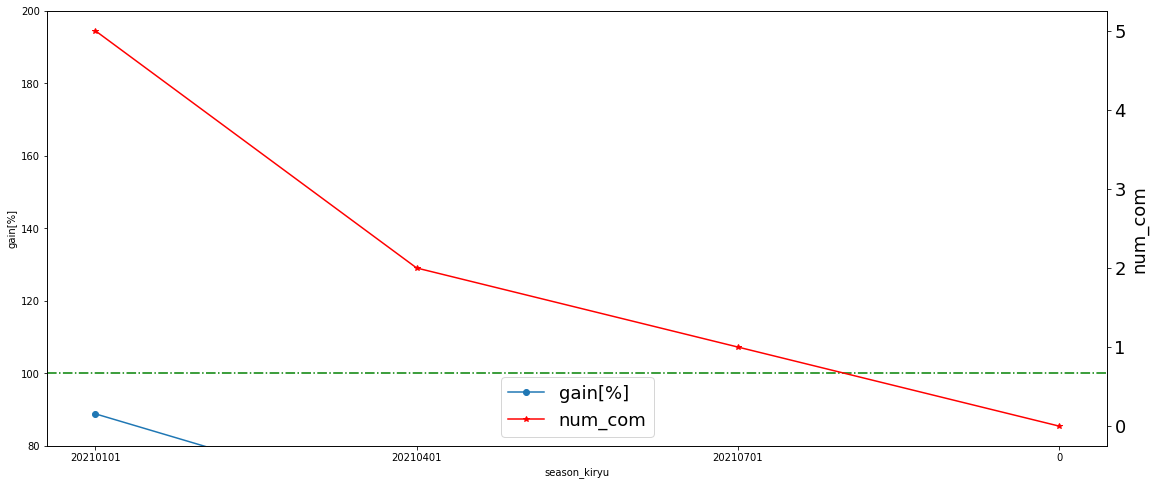

  4%|███▍                                                                               | 1/24 [00:00<00:03,  6.06it/s]

place_name: edogawa ========================================================================================
../bot_database/edogawa/model_score_edogawa/use_model/V4_2/use_model_edogawa_20210101_V4_2_period.csv
../bot_database/edogawa/model_score_edogawa/use_model/V4_2/use_model_edogawa_20210401_V4_2_period.csv
../bot_database/edogawa/model_score_edogawa/use_model/V4_2/use_model_edogawa_20210701_V4_2_period.csv


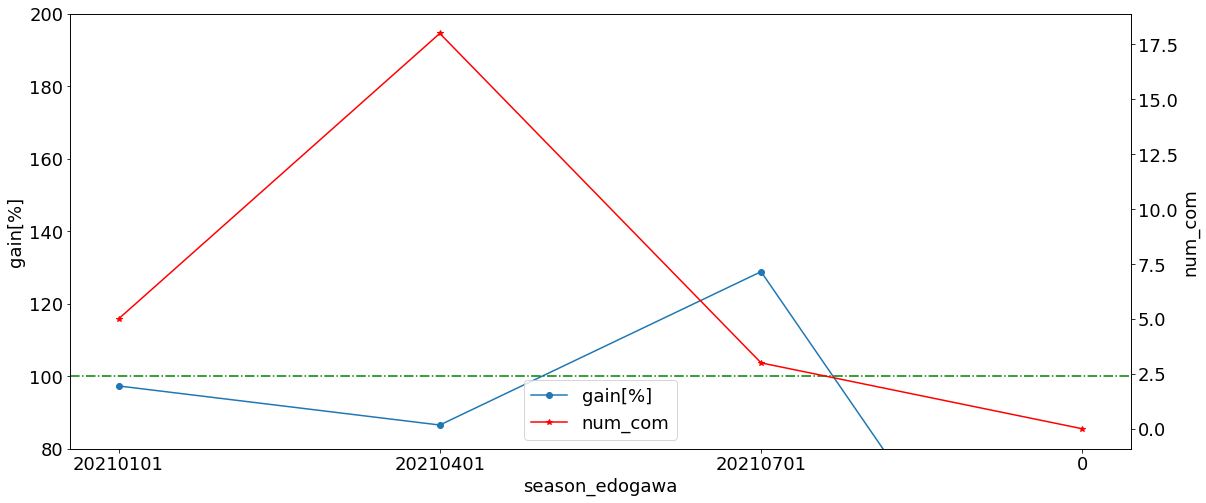

 12%|██████████▍                                                                        | 3/24 [00:00<00:02,  9.90it/s]

place_name: heiwazima ========================================================================================
../bot_database/heiwazima/model_score_heiwazima/use_model/V4_2/use_model_heiwazima_20210101_V4_2_period.csv
../bot_database/heiwazima/model_score_heiwazima/use_model/V4_2/use_model_heiwazima_20210401_V4_2_period.csv
../bot_database/heiwazima/model_score_heiwazima/use_model/V4_2/use_model_heiwazima_20210701_V4_2_period.csv


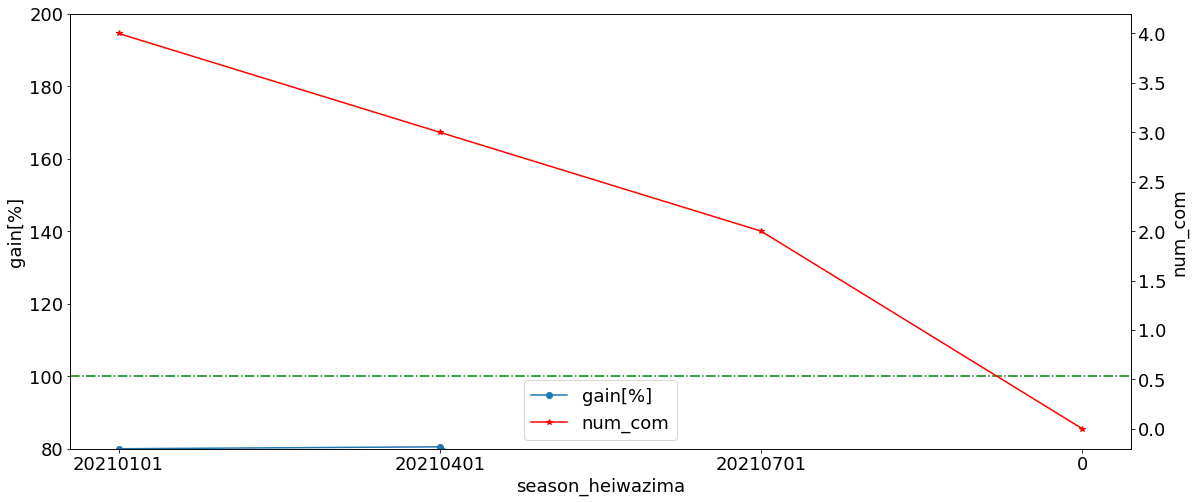

 17%|█████████████▊                                                                     | 4/24 [00:00<00:02,  8.16it/s]

place_name: tamagawa ========================================================================================
../bot_database/tamagawa/model_score_tamagawa/use_model/V4_2/use_model_tamagawa_20210101_V4_2_period.csv
../bot_database/tamagawa/model_score_tamagawa/use_model/V4_2/use_model_tamagawa_20210401_V4_2_period.csv
../bot_database/tamagawa/model_score_tamagawa/use_model/V4_2/use_model_tamagawa_20210701_V4_2_period.csv


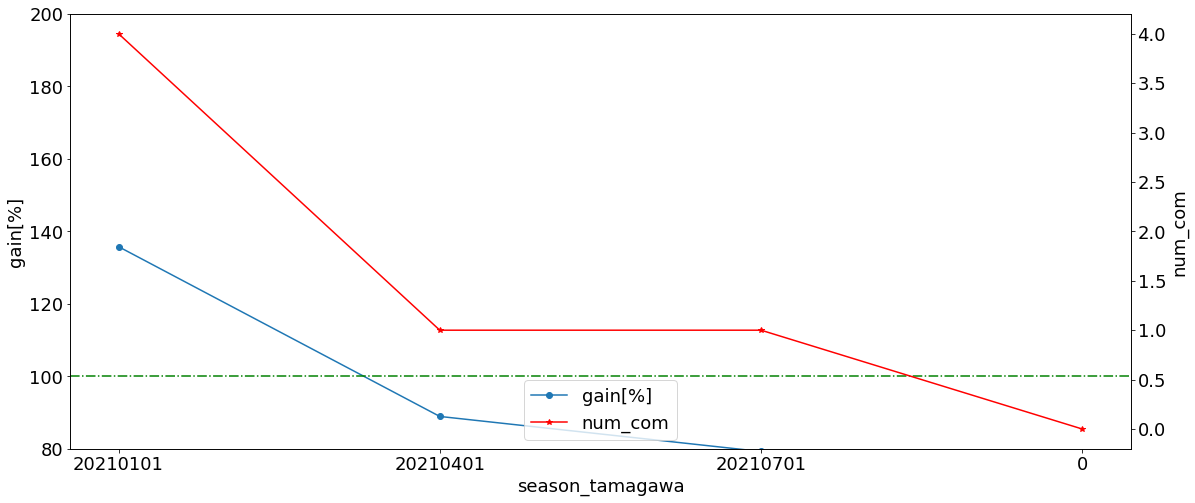

 21%|█████████████████▎                                                                 | 5/24 [00:00<00:02,  6.84it/s]

place_name: hamanako ========================================================================================
../bot_database/hamanako/model_score_hamanako/use_model/V4_2/use_model_hamanako_20210101_V4_2_period.csv
../bot_database/hamanako/model_score_hamanako/use_model/V4_2/use_model_hamanako_20210401_V4_2_period.csv
../bot_database/hamanako/model_score_hamanako/use_model/V4_2/use_model_hamanako_20210701_V4_2_period.csv


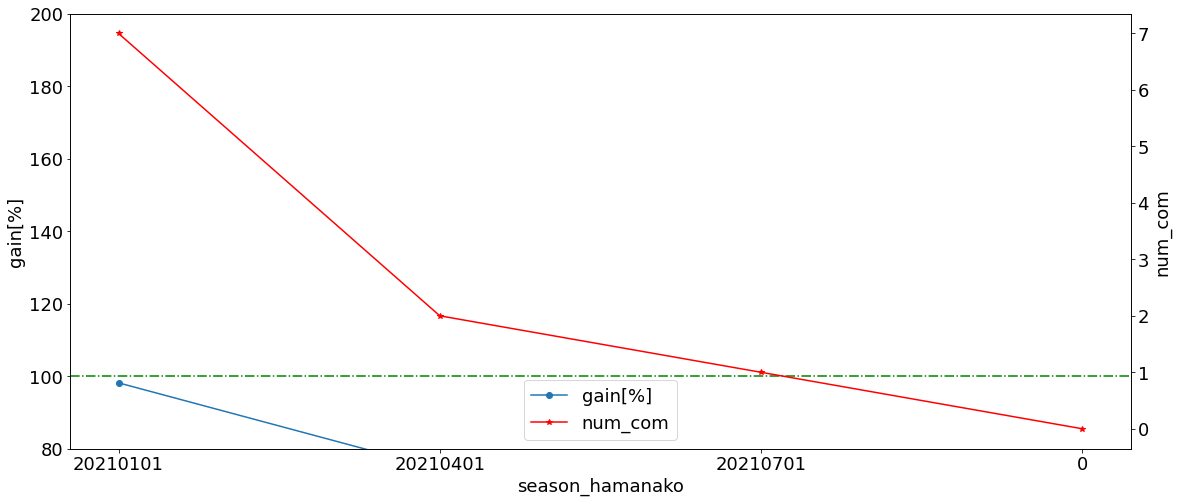

 25%|████████████████████▊                                                              | 6/24 [00:00<00:02,  6.69it/s]

place_name: gamagori ========================================================================================
../bot_database/gamagori/model_score_gamagori/use_model/V4_2/use_model_gamagori_20210101_V4_2_period.csv
../bot_database/gamagori/model_score_gamagori/use_model/V4_2/use_model_gamagori_20210401_V4_2_period.csv
../bot_database/gamagori/model_score_gamagori/use_model/V4_2/use_model_gamagori_20210701_V4_2_period.csv


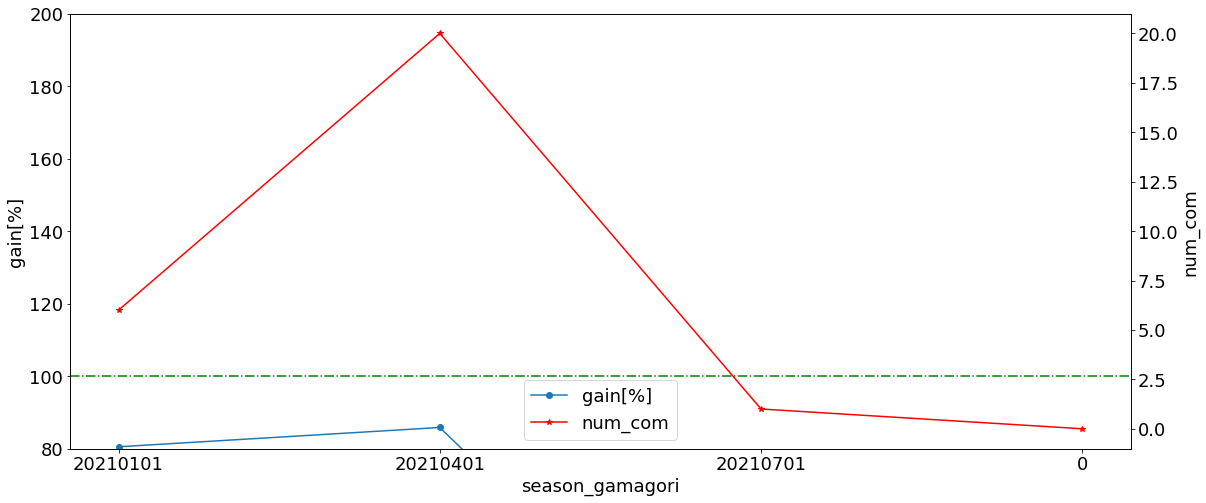

 29%|████████████████████████▏                                                          | 7/24 [00:00<00:02,  6.49it/s]

place_name: tokoname ========================================================================================
../bot_database/tokoname/model_score_tokoname/use_model/V4_2/use_model_tokoname_20210101_V4_2_period.csv
../bot_database/tokoname/model_score_tokoname/use_model/V4_2/use_model_tokoname_20210401_V4_2_period.csv
../bot_database/tokoname/model_score_tokoname/use_model/V4_2/use_model_tokoname_20210701_V4_2_period.csv


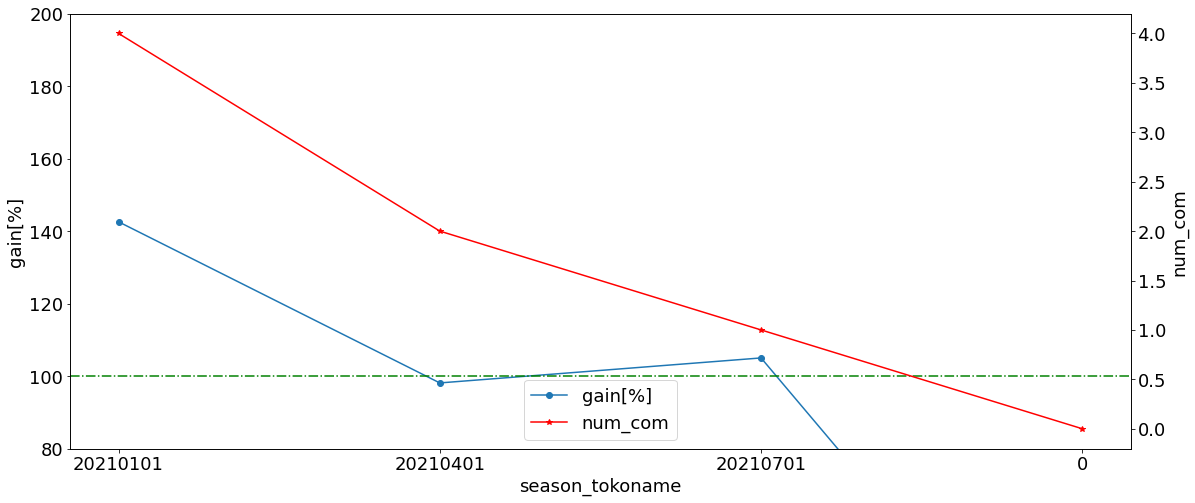

 33%|███████████████████████████▋                                                       | 8/24 [00:01<00:02,  6.48it/s]

place_name: tu ========================================================================================
../bot_database/tu/model_score_tu/use_model/V4_2/use_model_tu_20210101_V4_2_period.csv
../bot_database/tu/model_score_tu/use_model/V4_2/use_model_tu_20210401_V4_2_period.csv
../bot_database/tu/model_score_tu/use_model/V4_2/use_model_tu_20210701_V4_2_period.csv


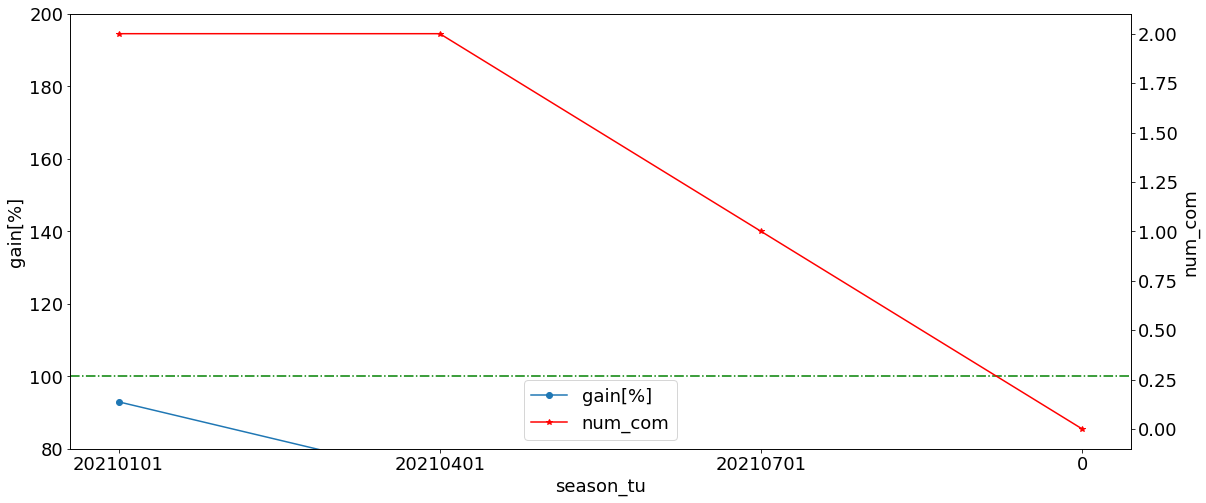

 38%|███████████████████████████████▏                                                   | 9/24 [00:01<00:02,  6.83it/s]

place_name: mikuni ========================================================================================
../bot_database/mikuni/model_score_mikuni/use_model/V4_2/use_model_mikuni_20210101_V4_2_period.csv


FileNotFoundError: [Errno 2] No such file or directory: '../bot_database/mikuni/model_score_mikuni/use_model/V4_2/use_model_mikuni_20210101_V4_2_period.csv'

In [7]:
#today=datetime.date.today()#今日の日付の取得
today=datetime.datetime(year=2021, month=10,day=1)
now_date=today
version='V4_2'

for place_name in tqdm(place_names):
    if place_name=='toda':
        pass
    else:
        print('place_name:',place_name,'========================================================================================')
        gain_arr=[0]*4
        n_com_arr=[0]*4
        date_arr=[0]*4
        diff_sec_dates=get_4_section_dt(now_date)#直近４区間の開始日をリストで取得
        now_date_txt=now_date.strftime('%Y%m%d')
        diff_sec_dates=diff_sec_dates[1:]#テスト時のみの特別処理！！データが１区間だけ足りないので今回はスルーする
        for i in range(len(diff_sec_dates)):
            sec_date=diff_sec_dates[i]
            sec_date_txt=sec_date.strftime('%Y%m%d')
            #dir_path = "../bot_database/{place_name}/model_score_{place_name}/use_model/{version}/use_model_{place_name}_{now_ym}_{version}.csv".format(place_name=place_name,version=version,now_ym=sec_date_txt)#作成したデータの書き込み先#使用するデータの読み込み
            dir_path = "../bot_database/{place_name}/model_score_{place_name}/use_model/{version}/use_model_{place_name}_{now_ym}_{version}_{mode_type}.csv".format(place_name=place_name,version=version,now_ym=sec_date_txt,mode_type=mode_type)#作成したデータの書き込み先#使用するデータの読み込み

            print(dir_path)
            use_models=pd.read_csv(dir_path, encoding='utf_8_sig')
            s_t_use=use_models['total_use_final'].sum()
            s_t_get=use_models['total_get_final'].sum()
            s_gain=(s_t_get/s_t_use)*100
            gain_arr[i]=s_gain
            n_com_arr[i]=len(use_models)
            date_arr[i]=sec_date_txt
        x_n='season_{place_name}'.format(place_name=place_name)
        y1_n='gain[%]'
        y2_n='num_com'
        twin_plt(date_arr,gain_arr,n_com_arr,x_n,y1_n,y2_n)

## 出力したパラメータシート(use_model)をもとにpickleにモデルを保存する

In [ ]:
version='V4_2'#バージョン
#pickleの書き込み先作成のための箱作り
place_master=master.get_place_master()
for place in place_master.items():
    #print(place[0],place[1],'\n')
    place_name=place[1]
    dir_path = "../bot_database/{place_name}/model_pickle_{place_name}/{version}".format(place_name=place_name,version=version)#作成したデータの書き込み先#使用するデータの読み込み
    if os.path.exists(dir_path)==False:
        os.makedirs(dir_path)
    else:
        pass

In [ ]:
def get_event_info(result_base_df):
    df=result_base_df.copy()
    df['date']=pd.to_datetime(df['date'])#日付が文字列なのでdateを日付型に変換
    df['year']=df['date'].dt.year
    df['month']=df['date'].dt.month
    df['day']=df['date'].dt.day

    num_date=1
    num_date_arr=[]
    last_race_date=df['date'].values[0]#前レースの日付(処理開始時用にtarainのデータの一番初めのdateを仮に入力しておく)
    for index,row in df.iterrows():
        today_date=row['date']
        if today_date==last_race_date:#同じ日のレースだったらおなじレース日を配列に追加、次の日の日付を出力（ほぼ無操作みたいなもん）
            next_date=row['date'] + datetime.timedelta(days=1)#次の日
            num_date_arr.append(num_date)
        else:#日にちが変わった時
            if today_date==next_date:#想定していた日付（次の日のレース）だったら,レース日を一日足して、そのレース日番号を加算
                num_date+=1
                num_date_arr.append(num_date)
                last_race_date=row['date']#前回レース日を上書き
                #next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日
                next_date=row['date'] + datetime.timedelta(days=1)#次の日
                #print(next_date)
            else:#想定していた日付でない(違う大会になった)場合はレース日をリセット
                num_date=1
                num_date_arr.append(num_date)
                last_race_date=row['date']#前回レース日を上書き
                #next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日
                next_date=row['date'] + datetime.timedelta(days=1)#次の日
    df['num_date']=num_date_arr

    range_races=0#大会中の取得できたレースの数
    range_date=1#大会の開催日数
    range_date_arr=[]
    range_date_arr_2=[]#for文中で繰り返し上書きさせる用の配列
    last_race_date=df['date'].values[0]#前レースの日付(処理開始時用にtrainのデータの一番初めのdateを仮に入力しておく)
    for index,row in df.iterrows():
        today_date=row['date']
        if today_date==last_race_date:#同じ日のレースだったらおなじレース日を配列に追加、次の日の日付を出力（ほぼ無操作みたいなもん）
            range_races+=1
            next_date=row['date'] + datetime.timedelta(days=1)#次の日
            #num_date_arr.append(num_date)
        else:#日にちが変わった時
            if today_date==next_date:#想定していた日付（次の日のレース）だったら,レース日を一日足して終了
                range_date+=1
                range_races+=1
                last_race_date=row['date']#前回レース日を上書き
                #next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日
                next_date=row['date'] + datetime.timedelta(days=1)#次の日次の日
            else:#想定していた日付でない(違う大会になった)場合は現在のrange_dateをもとに前の大会のレースに大会開催日数を持たせる。

                range_date_arr_2=[range_date]*range_races
                for num in range_date_arr_2:
                    range_date_arr.append(num)
                range_races=1#大会中の取得できたレースの数
                range_date=1#大会の開催日数
                last_race_date=row['date']#前回レース日を上書き
                #next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日
                next_date=row['date'] + datetime.timedelta(days=1)#次の日
    range_date_arr_2=[range_date]*range_races#最後の日は日付の変わり絵が発生しないので特別処理
    for num in range_date_arr_2:
        range_date_arr.append(num)
    df['range_date']=range_date_arr

    #四半期カラムの作成
    df['season']=df['month']
    df['season']=df['season'].replace([3,4,5],'sp')#春
    df['season']=df['season'].replace([6,7,8],'su')#夏
    df['season']=df['season'].replace([9,10,11],'au')#秋
    df['season']=df['season'].replace([12,1,2],'wi')#冬
    #df=df.drop('date',axis=1)
    return df

def pred_th_trans(pred_df,th):
    #引数として予測結果のdeと、変換したい閾値を渡す。
    trans_df=pred_df.copy()
    trans_df.loc[trans_df['pred_proba'] >= th, 'pred'] = 1
    trans_df.loc[~(trans_df['pred_proba']  >=  th), 'pred'] = 0
    return trans_df

def calc_monthly_analysis(pred_df):#予測に加えて，配当，開催情報が結合されたdfを渡すことで月ごと関連の分析を行ってくれる関数
    cols=['month','use','get','income','income_per','num_hit','buy_hit_per','mean_income','median_income']
    monthly_analysis_df= pd.DataFrame(columns=cols)#月別収益結果の入る箱
    months=pred_df['month'].value_counts(sort=False).index
    for month in months:
        monthly_df=pred_df[pred_df['month']==month].copy()
        use_m=100*monthly_df['pred'].sum()
        get_m=monthly_df['gain'].sum()
        income=get_m-use_m
        income_per=(get_m/use_m)*100
        
        
        num_hit=monthly_df['hit_flag'].sum()
        num_pred=pred_df['pred'].sum()
        buy_hit_per=(num_hit/num_pred)*100
        if num_hit==0:#警告文削除用
            mean_income=0
            median_income=0
        else:
            mean_income=monthly_df[monthly_df['hit_flag']==1]["gain"].mean()#１回の的中あたりの平均配当
            median_income=monthly_df[monthly_df['hit_flag']==1]["gain"].median()#１回の的中あたりの中央配当
        
        append_arr=[month,use_m,get_m,income,income_per,num_hit,buy_hit_per,mean_income,median_income]
        append_s=pd.Series(append_arr,index=cols)
        monthly_analysis_df=monthly_analysis_df.append(append_s, ignore_index=True)
    return monthly_analysis_df

def get_season_date(now_date):#日付(datetime型)を渡すと，その日付で購買予測を行う際に使用するデータの区間を返す関数
    use_data_year=now_date.year
    if (now_date.month>=1)and(now_date.month<4):
        use_data_month=1
    elif (now_date.month>=4)and(now_date.month<7):
        use_data_month=4
    elif (now_date.month>=7)and(now_date.month<10):
        use_data_month=7
    elif (now_date.month>=10):
        use_data_month=10
    else:
        print('what???????')
    use_data_date=datetime.datetime(year=use_data_year, month=use_data_month,day=1)
    return use_data_date
def trans_result_com(target_com,trans_base_df):#comをターゲットに合わせて0,1の二値に変換する。
    #学習データのラベル変換==========================================================
    trans_df=trans_base_df.copy()
    #result_train_df=trans_base_df.copy()
    result_arr=[0]*len(trans_df)
    i=0
    for result in trans_df['result_com']:#
        if ((result==target_com)):
            result_arr[i]=1
        else:
            result_arr[i]=0
        i+=1
    trans_df['result_com']=result_arr
    return trans_df

def pred_th_trans(pred_df,th):#引数として予測結果のdeと、変換したい閾値を渡す。

    trans_df=pred_df.copy()
    trans_df.loc[trans_df['pred_proba'] >= th, 'pred'] = 1
    trans_df.loc[~(trans_df['pred_proba']  >=  th), 'pred'] = 0
    return trans_df

def pred_th_trans_com(pred_df,th,target_com):#指定の組のカラムのみを置換。
    trans_df=pred_df.copy()
    trans_df.loc[trans_df['pred_{}'.format(target_com)] >= th, 'pred_{}'.format(target_com)] = 1
    trans_df.loc[~(trans_df['pred_{}'.format(target_com)] >=  th), 'pred_{}'.format(target_com)] = 0
    return trans_df

def calc_gain(pred_gain_df):#レース単位であたっているか同課の判別と、当たった場合に得られた配当金を計算する関数
    pred_true_df=pred_gain_df[(pred_gain_df['pred']==1)&(pred_gain_df['trans_result']==1)].copy()
    pred_true_df['hit']=1
    calc_base_df=pred_gain_df.copy()
    calc_base_df['hit']=pred_true_df['hit']
    calc_base_df['gain']=pred_true_df['money']
    calc_base_df=calc_base_df.fillna(0)
    #
    #calc_base_df:予測、変換積みの結果、実際の結果、配当金、収益をすべて表したdf,合計操作は行っていない。
    #
    return calc_base_df

def check_pred_arr(pred1_df,pred2_df):#カラムの中身が同じか比較する関数
    pred_1_vals=[pred1_df[col] for col in pred1_df.columns]
    pred_2_vals=[pred2_df[col] for col in pred2_df.columns]
    for col_name1,col1,col_name2,col2 in zip(pred1_df.columns,pred_1_vals,pred2_df.columns,pred_2_vals):
        if list(col1.values)==list(col1.values):
            print(col_name1,'  and  ',col_name2,'  is same pred \n')
    return None

def pred_th_trans(pred_df,th):#閾値を渡して、その値以上を1、未満を0に置き変える。
    #引数として予測結果のdeと、変換したい閾値を渡す。
    trans_df=pred_df.copy()
    trans_df.loc[trans_df['pred_proba'] >= th, 'pred'] = 1
    trans_df.loc[~(trans_df['pred_proba']  >=  th), 'pred'] = 0
    return trans_df

def add_result_class(model,score_df):#モデルでの予測結果を学習時に使用したパラメータシートに追加して返す関数
    #out_figはオプション、グラフの出力の有り無し
    score_sheet_base=score_df.copy()
    score_sheet_shuffle=score_sheet_base.sample(frac=1, random_state=7)#行をシャッフル
    num_data=len(score_sheet_shuffle)#データの件数

    #前処理    これはクラス分類なので閾値で最新収益を1,0に変換する
    score_sheet_shuffle['gain_label']=0#実際の収益の有無を確認(110を利益有り無しの閾値とする )
    score_sheet_shuffle.loc[score_sheet_shuffle['gain_year3'] < 110, 'gain_label'] =0
    score_sheet_shuffle.loc[score_sheet_shuffle['gain_year3'] >= 110, 'gain_label'] =1
    ex_df=score_sheet_shuffle.copy()#gain_year3の切り抜き用
    score_sheet_shuffle=score_sheet_shuffle.drop(['gain_year3'],axis=1).copy()

    #データの分割========================================================================================================
    test_df = score_sheet_shuffle[int(num_data*0.8):].copy()#20%のデータを検証用データに。
    train_df =  score_sheet_shuffle[:int(num_data*0.8)].copy()#そのほかを学習データに
    gain_s=ex_df[int(num_data*0.8):]['gain_year3'].copy()#検証用データの実収益部分を切り抜く。

    test_x=test_df.drop(['gain_label'],axis=1).copy()
    train_x=train_df.drop(['gain_label'],axis=1).copy()
    test_y=test_df['gain_label']
    train_y=train_df['gain_label']
    test_pred_df=test_df.copy()#予測の結合先を作っておく
    train_pred_df=train_df.copy()#予測の結合先を作っておく

    #予測を出力(確率分布)
    train_pred_proba_arr=model.predict_proba(train_x)
    train_pred_proba=[arr[1] for arr in train_pred_proba_arr]#確率分布の二次元配列なので[1]の部分だけ取り出す
    test_pred_proba_arr = model.predict_proba(test_x)
    test_pred_proba=[arr[1] for arr in test_pred_proba_arr]#確率分布の二次元配列なので[1]の部分だけ取り出す
    test_pred_df["pred_proba"]=test_pred_proba#予測を結合
    train_pred_df["pred_proba"]=train_pred_proba#予測を結合

    #確率分布の閾値で予測をバイナリに変換(仮)
    #test_pred_df=pred_th_trans(test_pred_df,0.5)
    #train_pred_df=pred_th_trans(train_pred_df,0.5)

#     #モデルのスコアの計算
#     col1='pred'
#     col2='gain_label'
#     cross_df,train_precision=making_cross(col1,col2 ,train_pred_df)
#     cross_df,test_precision=making_cross(col1,col2 ,test_pred_df)
#     print("train_precision:{}__test_precision:{}".format(train_precision,test_precision))

    test_pred_df['gain_year3']=gain_s#実際の収益の情報を追加する
    return test_pred_df

def making_cross(col1,col2,base_df,out_cross=0):#クロス収益図を作成してpurecisionを算出する関数
    cross_df=pd.DataFrame(columns=["{}_1".format(col2),"{}_0".format(col2),'sum']
                         ,index=["{}_1".format(col1),"{}_0".format(col1),'sum'])#クロス集計の結果の格納df
    cross_df.at["{}_1".format(col1), "{}_1".format(col2)]=len(base_df[(base_df[col1]==1) & (base_df[col2]==1)])#左上
    cross_df.at["{}_1".format(col1), "{}_0".format(col2)]=len(base_df[(base_df[col1]==1) & (base_df[col2]==0)])#右上
    cross_df.at["{}_0".format(col1), "{}_1".format(col2)]=len(base_df[(base_df[col1]==0) & (base_df[col2]==1)])#左下
    cross_df.at["{}_0".format(col1), "{}_0".format(col2)]=len(base_df[(base_df[col1]==0) & (base_df[col2]==0)])#右下

    cross_df.at["{}_1".format(col1), "sum"]=cross_df.at["{}_1".format(col1), "{}_1".format(col2)]+cross_df.at["{}_1".format(col1), "{}_0".format(col2)]
    cross_df.at["{}_0".format(col1), "sum"]=cross_df.at["{}_0".format(col1), "{}_1".format(col2)]+cross_df.at["{}_0".format(col1), "{}_0".format(col2)]
    cross_df.at["sum", "{}_1".format(col2)]=cross_df.at["{}_1".format(col1), "{}_1".format(col2)]+cross_df.at["{}_0".format(col1), "{}_1".format(col2)]
    cross_df.at["sum", "{}_0".format(col2)]=cross_df.at["{}_1".format(col1), "{}_0".format(col2)]+cross_df.at["{}_0".format(col1), "{}_0".format(col2)]
    if out_cross==1:
        display(cross_df)
    #precisionを算出
    try:
        #precision=(cross_df.at["{}_1".format(col1), "{}_1".format(col2)]/(cross_df.at["{}_1".format(col1), "{}_1".format(col2)]+cross_df.at["{}_1".format(col1), "{}_0".format(col2)]))*100
        precision=(cross_df.at["{}_1".format(col1), "{}_1".format(col2)]/(cross_df.at["{}_1".format(col1),'sum']))*100
    except ZeroDivisionError:
        precision=0

    return cross_df,precision

In [ ]:
def data_making_clustar_section_has_final(df,now_ym,range_test_m,range_final_m):#モデル関連に使用するdfの作成関数(クラスタリングあり、モータ番号、艇番号なし)（加工関数）final(実運用バックテスト区間)あり版
    #V4系列で使用する加工関数，年と月の情報を使って直近のデータを使って性能検証を行う（区間を使ってデータを作っている）
    #validデータを作成するバージョンなので実装する際はこれをそのまま使わず，final_test部分の処理は消してくだちい
    #yearが使わないと思うけど一応残してあるから邪魔だと思ったら消して下さい
    result_df=df
    result_df=result_df.drop(["racer_1_ID","racer_2_ID","racer_3_ID","racer_4_ID","racer_5_ID","racer_6_ID",],axis=1)#IDはいらないので削除
    result_df=result_df.replace(0.0000,{"racer_1_ave_st_time":0.22}).copy()#新人のave_st_timeを0.22に
    result_df=result_df.replace(0.0000,{"racer_2_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_3_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_4_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_5_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_6_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_1_doub_win":0.02}).copy()#新人の着に絡む確率ave_st_timeを0.02に(新人の半期の偏差から導出)
    result_df=result_df.replace(0.0000,{"racer_2_doub_win":0.02}).copy()
    result_df=result_df.replace(0.0000,{"racer_3_doub_win":0.02}).copy()
    result_df=result_df.replace(0.0000,{"racer_4_doub_win":0.02}).copy()
    result_df=result_df.replace(0.0000,{"racer_5_doub_win":0.02}).copy()
    result_df=result_df.replace(0.0000,{"racer_6_doub_win":0.02}).copy()

    #result_base_df=result_df.copy()
    #result_base_df=get_event_info(result_base_df)#開催の情報について付与する関数(年月日に加えて，何日間の開催かどうかも教えてくれる)

    #ダミー変数化
    result_df_dummie=result_df.copy()
    race_dummie_df=pd.get_dummies(result_df_dummie['number_race'])#number_raceをダミー化
    for column, val in race_dummie_df.iteritems():
        result_df_dummie['race_{}'.format(int(column))]=val
    result_df_dummie=result_df_dummie.drop('number_race',axis=1).copy()

    cols=list(result_df_dummie.columns)
    male_cols=[s for s in cols if 'male' in s]#性別を示すカラムを取り出す

    #===========================新規、性別の取り出し機能が良くなかったため作り直す
    empty_arr=[0]*len(result_df_dummie)
    for col in male_cols:
        for number in np.arange(0,2,1):
              result_df_dummie['{}_{}'.format(col,int(number))]=empty_arr.copy()
        male_dummie_df=pd.get_dummies(result_df_dummie[col]).copy()#性別をダミー化
        for column, val in male_dummie_df.iteritems():
              result_df_dummie['{}_{}'.format(col,int(column))]=val.copy()
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1).copy()

    cols=list(result_df_dummie.columns)



    moter_cols=[s for s in cols if '_mo' in s]#モーター番号を示すカラムを取り出す
    boat_cols=[s for s in cols if '_bo' in s]#ボート番号を示すカラムを取り出す

    #boat、moterの情報は使わない、
    numbers=np.arange(1, 100, 1)
    empty_arr=[0]*len(result_df_dummie)
    for col in moter_cols:
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1).copy()
    for col in boat_cols:
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1).copy()

    #クラスタリング
    #分けてみるクラスタの数は[3,5,7,9]の4個
    #cluster_target_df　　trainのデータからリザルトと配当金を取り除いたもの
    #学習データのdateを年に変換
    result_df_dummie['date']=pd.to_datetime(result_df_dummie['date'])#日付が文字列なのでdateを日付型に変換
    result_df_dummie['year']=result_df_dummie['date'].dt.year
    
    #==========================================================================
    #result_df_dummie=result_df_dummie[result_df_dummie['year']!=2020].copy()#2020のデータを完全に切り離す。
    #==========================================================================
    #クラアスタリング用の学習、予測用のデータの切り分け
    #年，月，日とかの取得
    #now_ym:開始の月
    test_st_date = now_ym - relativedelta(months=range_test_m)#テストデータに使用する区間を決める
    final_test_en_date = now_ym + relativedelta(months=range_final_m)#最終テストの終了日
    
    clustar_final_test_df=result_df_dummie[(result_df_dummie['date']>=now_ym) & (result_df_dummie['date']<final_test_en_date) ].copy()#今の日付以降を最終チェックデータ(予測のターゲット)に。
    clustar_test_df = result_df_dummie[(result_df_dummie['date']<now_ym) & ((result_df_dummie['date']>=test_st_date) )].copy()#今日に日より前の，指定した区間でのテストデータ
    clustar_train_df =  result_df_dummie[(result_df_dummie['date']<test_st_date)].copy()#そのほかを学習データに
    result_df_dummie=result_df_dummie[result_df_dummie['date']<final_test_en_date]
    #年の情報だけ切り分けに使ったからここで消す。
    clustar_final_test_df=clustar_final_test_df.drop('date',axis=1).copy()
    clustar_test_df=clustar_test_df.drop('date',axis=1).copy()
    clustar_train_df=clustar_train_df.drop('date',axis=1).copy()

    #クラスタリングに邪魔だから消したいけど、後々使うものはいったんよけておく
    result=result_df_dummie['result_com'].values.copy()#
    money=result_df_dummie['money'].values.copy()#
    years=result_df_dummie['year'].values.copy()#
    dates=result_df_dummie['date'].values.copy()#
    
    #安全なところに移したら削除する
    result_df_dummie=result_df_dummie.drop('result_com',axis=1)
    result_df_dummie=result_df_dummie.drop('money',axis=1)
    result_df_dummie=result_df_dummie.drop('year',axis=1)
    #esult_df_dummie=result_df_dummie.drop('date',axis=1)
    
    

    target_num_cluster=[3,5,7,9]#分けるクラスタ数によってモデルの名前を変える
    for num_cluster in target_num_cluster:
        Km = KMeans(random_state=7,n_clusters=num_cluster).fit(clustar_train_df)#rondom_stateはラッキーセブン
        #final_test_pred =Km.predict(clustar_final_test_df)#rondom_stateはラッキーセブン
        final_test_pred =Km.predict(clustar_final_test_df)#rondom_stateはラッキーセブン
        test_pred =Km.predict(clustar_test_df)#rondom_stateはラッキーセブン
        train_pred = Km.predict(clustar_train_df)#rondom_stateはラッキーセブン
        #Km=========================実査に使うときはこれのモデルを会場ごとに保存して使用。
        #clustar_final_test_df['num={}'.format(num_cluster)]=final_test_pred
        clustar_final_test_df['num={}'.format(num_cluster)]=final_test_pred
        clustar_test_df['num={}'.format(num_cluster)]=test_pred
        clustar_train_df['num={}'.format(num_cluster)]=train_pred

    #結合して元の形に戻す。
    #clustar_df=pd.concat([clustar_train_df, clustar_test_df,clustar_final_test_df]).copy()
#     clustar_final_test_df['check']='final'#確認用
#     clustar_test_df['check']='test'#確認用
#     clustar_train_df['check']='train'#確認用
    clustar_df=pd.concat([clustar_train_df, clustar_test_df,clustar_final_test_df]).copy()
    clustar_df['year']=years
    clustar_df['date']=dates
    clustar_df['money']=money
    clustar_df['result_com']=result
    model_df=clustar_df.copy()
    return model_df

def data_making_clustar_section(df,now_ym,range_test_m):#モデル関連に使用するdfの作成関数(クラスタリングあり、モータ番号、艇番号なし)（加工関数）final(実運用バックテスト区間)無し版
    #V4系列で使用する加工関数，年と月の情報を使って直近のデータを使って性能検証を行う（区間を使ってデータを作っている）
    #validデータを作成するバージョンなので実装する際はこれをそのまま使わず，final_test部分の処理は消してくだちい
    #yearが使わないと思うけど一応残してあるから邪魔だと思ったら消して下さい
    result_df=df
    result_df=result_df.drop(["racer_1_ID","racer_2_ID","racer_3_ID","racer_4_ID","racer_5_ID","racer_6_ID",],axis=1)#IDはいらないので削除
    result_df=result_df.replace(0.0000,{"racer_1_ave_st_time":0.22}).copy()#新人のave_st_timeを0.22に
    result_df=result_df.replace(0.0000,{"racer_2_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_3_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_4_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_5_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_6_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_1_doub_win":0.02}).copy()#新人の着に絡む確率ave_st_timeを0.02に(新人の半期の偏差から導出)
    result_df=result_df.replace(0.0000,{"racer_2_doub_win":0.02}).copy()
    result_df=result_df.replace(0.0000,{"racer_3_doub_win":0.02}).copy()
    result_df=result_df.replace(0.0000,{"racer_4_doub_win":0.02}).copy()
    result_df=result_df.replace(0.0000,{"racer_5_doub_win":0.02}).copy()
    result_df=result_df.replace(0.0000,{"racer_6_doub_win":0.02}).copy()

    #result_base_df=result_df.copy()
    #result_base_df=get_event_info(result_base_df)#開催の情報について付与する関数(年月日に加えて，何日間の開催かどうかも教えてくれる)

    #ダミー変数化
    result_df_dummie=result_df.copy()
    race_dummie_df=pd.get_dummies(result_df_dummie['number_race'])#number_raceをダミー化
    for column, val in race_dummie_df.iteritems():
        result_df_dummie['race_{}'.format(int(column))]=val
    result_df_dummie=result_df_dummie.drop('number_race',axis=1).copy()

    cols=list(result_df_dummie.columns)
    male_cols=[s for s in cols if 'male' in s]#性別を示すカラムを取り出す

    #===========================新規、性別の取り出し機能が良くなかったため作り直す
    empty_arr=[0]*len(result_df_dummie)
    for col in male_cols:
        for number in np.arange(0,2,1):
              result_df_dummie['{}_{}'.format(col,int(number))]=empty_arr.copy()
        male_dummie_df=pd.get_dummies(result_df_dummie[col]).copy()#性別をダミー化
        for column, val in male_dummie_df.iteritems():
              result_df_dummie['{}_{}'.format(col,int(column))]=val.copy()
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1).copy()

    cols=list(result_df_dummie.columns)



    moter_cols=[s for s in cols if '_mo' in s]#モーター番号を示すカラムを取り出す
    boat_cols=[s for s in cols if '_bo' in s]#ボート番号を示すカラムを取り出す

    #boat、moterの情報は使わない、
    numbers=np.arange(1, 100, 1)
    empty_arr=[0]*len(result_df_dummie)
    for col in moter_cols:
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1).copy()
    for col in boat_cols:
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1).copy()

    #クラスタリング
    #分けてみるクラスタの数は[3,5,7,9]の4個
    #cluster_target_df　　trainのデータからリザルトと配当金を取り除いたもの
    #学習データのdateを年に変換
    result_df_dummie['date']=pd.to_datetime(result_df_dummie['date'])#日付が文字列なのでdateを日付型に変換
    result_df_dummie['year']=result_df_dummie['date'].dt.year
    
    #==========================================================================
    #result_df_dummie=result_df_dummie[result_df_dummie['year']!=2020].copy()#2020のデータを完全に切り離す。
    #==========================================================================
    #クラアスタリング用の学習、予測用のデータの切り分け
    #年，月，日とかの取得
    #now_ym:開始の月
    test_st_date = now_ym - relativedelta(months=range_test_m)#テストデータに使用する区間を決める
    #final_test_en_date = now_ym + relativedelta(months=range_final_m)#最終テストの終了日
    
    #clustar_final_test_df=result_df_dummie[(result_df_dummie['date']>=now_ym) & (result_df_dummie['date']<final_test_en_date) ].copy()#今の日付以降を最終チェックデータ(予測のターゲット)に。
    clustar_test_df = result_df_dummie[(result_df_dummie['date']<now_ym) & ((result_df_dummie['date']>=test_st_date) )].copy()#今日より前の，指定した区間でのテストデータ
    clustar_train_df =  result_df_dummie[(result_df_dummie['date']<test_st_date)].copy()#そのほかを学習データに
    result_df_dummie=result_df_dummie[result_df_dummie['date']<now_ym]
    #年の情報だけ切り分けに使ったからここで消す。
    #clustar_final_test_df=clustar_final_test_df.drop('date',axis=1).copy()
    clustar_test_df=clustar_test_df.drop('date',axis=1).copy()
    clustar_train_df=clustar_train_df.drop('date',axis=1).copy()

    #クラスタリングに邪魔だから消したいけど、後々使うものはいったんよけておく
    result=result_df_dummie['result_com'].values.copy()#
    money=result_df_dummie['money'].values.copy()#
    years=result_df_dummie['year'].values.copy()#
    dates=result_df_dummie['date'].values.copy()#
    
    #安全なところに移したら削除する
    result_df_dummie=result_df_dummie.drop('result_com',axis=1)
    result_df_dummie=result_df_dummie.drop('money',axis=1)
    result_df_dummie=result_df_dummie.drop('year',axis=1)
    #esult_df_dummie=result_df_dummie.drop('date',axis=1)
    
    

    target_num_cluster=[3,5,7,9]#分けるクラスタ数によってモデルの名前を変える
    for num_cluster in target_num_cluster:
        Km = KMeans(random_state=7,n_clusters=num_cluster).fit(clustar_train_df)#rondom_stateはラッキーセブン
        #final_test_pred =Km.predict(clustar_final_test_df)#rondom_stateはラッキーセブン
        test_pred =Km.predict(clustar_test_df)#rondom_stateはラッキーセブン
        train_pred = Km.predict(clustar_train_df)#rondom_stateはラッキーセブン
        #Km=========================実査に使うときはこれのモデルを会場ごとに保存して使用。
        #clustar_final_test_df['num={}'.format(num_cluster)]=final_test_pred
        #clustar_final_test_df['num={}'.format(num_cluster)]=final_test_pred
        clustar_test_df['num={}'.format(num_cluster)]=test_pred
        clustar_train_df['num={}'.format(num_cluster)]=train_pred

    #結合して元の形に戻す。
    #clustar_df=pd.concat([clustar_train_df, clustar_test_df,clustar_final_test_df]).copy()
#     clustar_final_test_df['check']='final'#確認用
#     clustar_test_df['check']='test'#確認用
#     clustar_train_df['check']='train'#確認用
    #clustar_df=pd.concat([clustar_train_df, clustar_test_df,clustar_final_test_df]).copy()
    clustar_df=pd.concat([clustar_train_df, clustar_test_df]).copy()
    clustar_df['year']=years
    clustar_df['date']=dates
    clustar_df['money']=money
    clustar_df['result_com']=result
    model_df=clustar_df.copy()
    return model_df

def model_score_rondom_th_section_has_final(version,place_name,result_df,now_ym,range_test_m,range_final_m):#rondomforestの出力を確率のやつを使用したバージョン、閾値の探索も行う。final(実運用バックテスト区間)あり版＿＿※[注意]ここでのnow_ymは区間の開始日を示していて，今日の日付ではないことに注意
    print(place_name)
    #result_dfは加工関数にて分けられたものを渡す。
    model_score_df=pd.DataFrame(columns=['target_com','depth','target_per','threshold','total_get_test', 'total_use_test','num_com_test','num_pred_test','gain_test','gain_std_test','num_hit_test','buy_hit_per_test','buy_hit_per_std_test','plus_month_num_test','diff_mea_med_test','total_get_final', 'total_use_final','num_com_final','num_pred_final','gain_final','gain_std_final','num_hit_final','buy_hit_per_final','buy_hit_per_std_final','plus_month_num_final','diff_mea_med_final'])#スコアを格納するdf

    #学習データの切り分け
    #年，月，日とかの取得
    #now_ym:開始の月
    test_st_date = now_ym - relativedelta(months=range_test_m)#テストデータに使用する区間を決める
    final_test_en_date = now_ym + relativedelta(months=range_final_m)#最終テストの終了日
    #以下学習データ
    final_test_df=result_df[(result_df['date']>=now_ym) & (result_df['date']<final_test_en_date) ].copy()#今の日付以降を最終チェックデータ(予測のターゲット)に。
    test_df = result_df[(result_df['date']<now_ym) & ((result_df['date']>=test_st_date) )].copy()#今日に日より前の，指定した区間でのテストデータ
    train_df =  result_df[(result_df['date']<test_st_date)].copy()#そのほかを学習データに

    #V4ではdateは性能評価用のdf作成時に使用するので別でとっておく(最終的にtransしたpredのdfに結合する)
    final_test_dates=final_test_df['date'].values
    test_dates=test_df['date'].values
    train_dates=train_df['date'].values

    #学習データを切り分けたらyearはいらないから削除する
    final_test_df=final_test_df.drop(['year'],axis=1)
    test_df=test_df.drop(['year'],axis=1)
    train_df=train_df.drop(['year'],axis=1)
    final_test_df=final_test_df.drop(['date'],axis=1)
    test_df=test_df.drop(['date'],axis=1)
    train_df=train_df.drop(['date'],axis=1)

    train_money=pd.Series(train_df['money'])
    test_money=pd.Series(test_df['money'])
    final_test_money=pd.Series(final_test_df['money'])
    test_gain_arr=test_money.values
    final_test_gain_arr=final_test_money.values
    #x,yへの切り分け
    #出現数の分布
    result_com_s=test_df['result_com'].value_counts()
    result_com_s=result_com_s.sort_index()
    gain_mean=test_df.groupby('result_com')['money'].mean()
    gain_mean=gain_mean.sort_index()

    gain_median=test_df.groupby('result_com')['money'].median()
    gain_median=gain_median.sort_index()
    result_com_df=pd.DataFrame({'result_com':result_com_s.index,
                                'result_com_num':result_com_s.values,
                                'result_com_per':result_com_s.values/sum(result_com_s.values)*100,
                                'gain_mean':gain_mean.values,
                                'gain_median':gain_median.values,})
    result_com_df=result_com_df.iloc[0:28]#探索的に探すにも最後のほうは役にモデルなのはわかっているため




    for result_com_number in tqdm(result_com_df['result_com'].values):
        #print(result_com_number)
        result_com=result_com_number
        #result_comごとの閾値の決定========================================================================

        gain_th=10#利益率の閾値
        result_s=result_com_df[result_com_df['result_com']==result_com]
        buy_accuracy_th=result_s['result_com_per'].values[0]*1.1#買ったうちの的中率の閾値
        num_tp_th=result_s['result_com_num'].values[0]*0.2#あたった回数の閾値(出現回数の20%が的中)
        #===============================================================================
        #学習データのラベル変換==========================================================
        result_train_df=train_df.copy()
        result_arr=[0]*len(result_train_df)
        i=0
        for result in result_train_df['result_com']:
            if ((result==result_com)):
                result_arr[i]=1
            else:
                result_arr[i]=0
            i+=1
        result_train_df['result_com']=result_arr

        target_test_df=test_df.copy()
        result_arr=[0]*len(target_test_df)
        i=0
        for result in target_test_df['result_com']:
            if ((result==result_com)):
                result_arr[i]=1
            else:
                result_arr[i]=0
            i+=1
        target_test_df['result_com']=result_arr

        target_final_test_df=final_test_df.copy()
        result_arr=[0]*len(target_final_test_df)
        i=0
        for result in target_final_test_df['result_com']:
            if ((result==result_com)):
                result_arr[i]=1
            else:
                result_arr[i]=0
            i+=1
        target_final_test_df['result_com']=result_arr

        result_train_df['money']=train_money
        target_test_df['money']=test_money
        target_final_test_df['money']=final_test_money
        #学習データラベル変換終わり============================================

        for_arr=np.arange(1,85)
        #for_arr=np.arange(1,100,1)
        accuracy_arr=[0]*len(for_arr)
        target_per_arr=[0]*len(for_arr)
        pred_0=[0]*len(for_arr)
        gain_arr=[0]*len(for_arr)
        model_gain_arr=[0]*len(target_test_df)
        #depths_arr=[4,5,6,7,8]
        #depths_arr=[5,6,8]
        depths_arr=[5,7]
        for depth in depths_arr:
            for sum_target_per in for_arr:

                index=sum_target_per-1
                #target_per=50+sum_target_per
                target_per=80+(sum_target_per)
                target_per_arr[index]=target_per

                #モデルの評価指標値を格納するseries======================
                model_score_s=pd.Series(index=['target_com','depth','target_per','threshold','total_get_test', 'total_use_test','num_com_test','num_pred_test','gain_test','gain_std_test','num_hit_test','buy_hit_per_test','buy_hit_per_std_test','plus_month_num_test','diff_mea_med_test','total_get_final', 'total_use_final','num_com_final','num_pred_final','gain_final','gain_std_final','num_hit_final','buy_hit_per_final','buy_hit_per_std_final','plus_month_num_final','diff_mea_med_final'], dtype='float64')
                model_score_s['target_com']=result_com#目標としているresult_comラベル番号
                model_score_s['depth']=depth#ハイパーパラメータ＿木の深さ
                model_score_s['target_per']=target_per#学習データ_1に対してどの程度の0のデータを持たせるか。
                #======================
                #trainの[0]に対して、target_perの割合の量[1]を持った学習データの作成
                # 一層目の判別機のtrainデータ　:terget_result_df
                target_df=result_train_df#ベースのデータフレームをコピー
                target_df=target_df.sample(frac=1, random_state=7)#シャッフル、時系列の偏りを無くす
                target_1_df=target_df[target_df['result_com']==1]
                len_1=len(target_1_df)
                target_0_df=target_df[target_df['result_com']==0]
                len_0=len(target_0_df)
                target_0_df=target_0_df.iloc[(len_0-int(len_1*(target_per/100))):len_0]#1に対する目標の割合ぶん0の結果だったレースを抽出（後ろから抽出）
                target_train_df=pd.concat([target_1_df, target_0_df])
                #学習＆予測ぱーと========================================================================
                #==========================================================================================================================================
                #データの切り分け
                target_x_train=target_train_df.drop('money',axis=1).copy()
                target_x_train=target_x_train.drop('result_com',axis=1)

                target_x_test=target_test_df.drop('money',axis=1).copy()
                target_x_test=target_x_test.drop('result_com',axis=1)

                target_x_final=target_final_test_df.drop('money',axis=1).copy()
                target_x_final=target_x_final.drop('result_com',axis=1)

                target_y_train=target_train_df['result_com']
                target_y_test=target_test_df['result_com']
                target_y_final=target_final_test_df['result_com']
                train_x, valid_x, train_y, valid_y = train_test_split(target_x_train, target_y_train, test_size=0.2, shuffle=True, random_state=7)#学習データ内でさらに分割してロスをもとに修正をする。

                #XGboostのデータ型に変換する
#                 train = xgb.DMatrix(train_x, label=train_y)#学習用
#                 valid = xgb.DMatrix(valid_x, label=valid_y)#学習時のロス修正用
#                 test = xgb.DMatrix(target_x_test, label=target_y_test)#実際に使った時の利益率の算出用
#                 final = xgb.DMatrix(target_x_final, label=target_y_final)#最終確認用の区間

                #RF = RandomForestClassifier(random_state=7,n_estimators=1000,max_depth=depth,n_jobs=5)
                RF = RandomForestClassifier(random_state=7,n_estimators=1000,max_depth=depth,n_jobs=1)
                
                RF = RF.fit(target_x_train,target_y_train)
                #bst = xgb.train(param, train,num_round,evallist, verbose=100,early_stopping_rounds=30 )
                #RF = RandomForestClassifier(random_state=1,n_estimators=1000,max_depth=depth)
                #RF = RF.fit(target_x_train,target_y_train)


                # 未知データに対する予測値
                #predict_y_test = RF.predict(target_x_test)
#                 predict_y_test=bst.predict(test)
#                 predict_y_final=bst.predict(final)
                predict_y_test_proba_arr = RF.predict_proba(target_x_test)#まだ多次元リスト
                predict_y_test=[proba_arr[1] for proba_arr in predict_y_test_proba_arr]#1にあたる部分の確率のみ出力
                predict_y_final_proba_arr = RF.predict_proba(target_x_final)#まだ多次元リスト
                predict_y_final=[proba_arr[1] for proba_arr in predict_y_final_proba_arr]#1にあたる部分の確率のみ出力
                #==========================================================================================================================================
                #==========================================================================================================================================
                #==========================================================================================================================================
                #==========================================================================================================================================

                #[1]の正答率を見る
                pred_test_df=pd.DataFrame({'pred_proba':predict_y_test#確率分布での出力
                                          , 'test':target_y_test})
                pred_final_test_df=pd.DataFrame({'pred_proba':predict_y_final#確率分布での出力
                                          , 'test':target_y_final})


                th_arr=[0.5,0.54,0.58]
                for th in th_arr:
                    trans_test_df=pred_th_trans(pred_test_df,th)
                    trans_final_test_df=pred_th_trans(pred_final_test_df,th)
                    #num_1=len(trans_df[trans_df['test']==1])
                    #追加　配当金の情報も考慮する。
                    count_test=0
                    gain_index=0
                    model_test_gain_arr=[0]*len(test_df)
                    test_hit_arr=[0]*len(test_df)#あたっているかあたっていないかのフラグを格納した配列
                    for _, s in trans_test_df.iterrows():
                        if ((s['pred']==1) and (s['test']==1)):#もし購買しているかつ的中をしていたら・・・
                            count_test+=1#的中回数
                            model_test_gain_arr[gain_index]=test_gain_arr[gain_index]
                            test_hit_arr[gain_index]=1
                        gain_index+=1

                    count_final=0
                    gain_index=0
                    model_final_test_gain_arr=[0]*len(final_test_df)
                    final_test_hit_arr=[0]*len(final_test_df)#あたっているかあたっていないかのフラグを格納した配列
                    for _, s in trans_final_test_df.iterrows():
                        if ((s['pred']==1) and (s['test']==1)):#もし購買しているかつ的中をしていたら・・・
                            count_final+=1#的中回数
                            model_final_test_gain_arr[gain_index]=final_test_gain_arr[gain_index]
                            final_test_hit_arr[gain_index]=1
                        gain_index+=1

    #                     gain_arr[index]=sum(model_gain_arr)
    #                     accuracy_arr[index]=(count/num_1)*100
                    #=================================================
                    try:
                        pred_0[index]=trans_df['pred'].value_counts()[0]
                    except:
                        pred_0[index]=0

                    #V4から増やした集計(月での集計を加えて，comごとでの安定性について確認する)
                    test_analysis_df=trans_test_df.copy()#集計結果を格納するためのdf
                    final_test_analysis_df=trans_final_test_df.copy()#集計結果を格納するためのdf
                    #集計のための情報を結合する
                    test_analysis_df['hit_flag']=test_hit_arr#的中時に１のフラグを結合する
                    test_analysis_df['gain']=model_test_gain_arr#的中して得られたゲインの金額を格納した配列
                    test_analysis_df['date']=test_dates#月ごとの分析のために日付のデータを結合する
                    test_analysis_df=get_event_info(test_analysis_df)#開催情報を取得

                    final_test_analysis_df['hit_flag']=final_test_hit_arr#的中時に１のフラグを結合する
                    final_test_analysis_df['gain']=model_final_test_gain_arr#的中して得られたゲインの金額を格納した配列
                    final_test_analysis_df['date']=final_test_dates#月ごとの分析のために日付のデータを結合する
                    final_test_analysis_df=get_event_info(final_test_analysis_df)#開催情報を取得

                    test_m_analysis=calc_monthly_analysis(test_analysis_df)#月別の分析結果を取得
                    final_test_m_analysis=calc_monthly_analysis(final_test_analysis_df)#月別の分析結果を取得
                    test_m_desc=test_m_analysis.describe()
                    final_test_m_desc=final_test_m_analysis.describe()
                    #scoreのseriesに情報書き込み==================
                    model_score_s['threshold']=th
                    #テストデータ=============================================================
                    #総収益
                    model_score_s['total_get_test']=sum(model_test_gain_arr)
                    #投資金額
                    model_score_s['total_use_test']=100*trans_test_df['pred'].sum()
                    #出現数
                    model_score_s['num_com_test']=sum(target_y_test)
                    #購買予測数
                    model_score_s['num_pred_test']=trans_test_df['pred'].sum()
                    #利益率
                    model_score_s['gain_test']=(model_score_s['total_get_test']/model_score_s['total_use_test'])*100
                    #利益率の標準偏差
                    model_score_s['gain_std_test']=test_m_desc.loc['std','income_per']
                    #的中数
                    model_score_s['num_hit_test']=count_test
                    #購買的中率
                    model_score_s['buy_hit_per_test']=(count_test/trans_test_df['pred'].sum())*100
                    #購買的中率の標準偏差
                    model_score_s['buy_hit_per_std_test']=test_m_desc.loc['std','buy_hit_per']
                    #配当がプラスになった月の数
                    model_score_s['plus_month_num_test']=len(test_m_analysis[test_m_analysis['income']>0])
                    #得られた配当の中央値と平均の差(中央値-平均，つまりマイナスが大きいほど高い配当が引っ張っている)
                    model_score_s['diff_mea_med_test']=(test_m_desc.loc['mean','mean_income'])-(test_m_desc.loc['mean','median_income'])

                    #最終テストデータ(カラム名の説明に関してはテストと同じなので割愛させていただきます)=============================================================
                    model_score_s['total_get_final']=sum(model_final_test_gain_arr)
                    model_score_s['total_use_final']=100*trans_final_test_df['pred'].sum()
                    model_score_s['num_com_final']=sum(target_y_final)
                    model_score_s['num_pred_final']=trans_final_test_df['pred'].sum()
                    model_score_s['gain_final']=(model_score_s['total_get_final']/model_score_s['total_use_final'])*100
                    model_score_s['gain_std_final']=final_test_m_desc.loc['std','income_per']

                    model_score_s['num_hit_final']=count_final
                    model_score_s['buy_hit_per_final']=(count_final/trans_final_test_df['pred'].sum())*100
                    model_score_s['buy_hit_per_std_final']=final_test_m_desc.loc['std','buy_hit_per']
                    model_score_s['plus_month_num_final']=len(final_test_m_analysis[final_test_m_analysis['income']>0])
                    model_score_s['diff_mea_med_final']=(final_test_m_desc.loc['mean','mean_income'])-(final_test_m_desc.loc['mean','median_income'])

                    #dfに書き込み
                    model_score_df=model_score_df.append(model_score_s,ignore_index=True)
    #モデルの「スコアを保存
    #dir_path = "../../bot_database/{place_name}/model_score_{place_name}/v4_score/{V}/{place_name}_model_score_st{stDate}_finalM{finalM}_{V}.csv".format(place_name=place_name,V=version,stDate=now_ym.strftime('%Y%m%d'),finalM=range_final_m)#作成したデータの書き込み先#使用するデータの読み込み
    dir_path = "../../../bot_database/{place_name}/model_score_{place_name}/v4_score/{V}/{place_name}_model_score_st{stDate}_finalM{finalM}_{V}.csv".format(place_name=place_name,V=version,stDate=now_ym.strftime('%Y%m%d'),finalM=range_final_m)#作成したデータの書き込み先#使用するデータの読み込み
    
    model_score_df.to_csv(dir_path, encoding='utf_8_sig')
    return None

def model_score_rondom_th_section(version,place_name,result_df,now_ym,range_test_m):#rondomforestの出力を確率のやつを使用したバージョン、閾値の探索も行う。final(実運用バックテスト区間)無し版__※[注意]ここでのnow_ymは区間の開始日を示していて，今日の日付ではないことに注意
    print(place_name)
    #result_dfは加工関数にて分けられたものを渡す。
    model_score_df=pd.DataFrame(columns=['target_com','depth','target_per','threshold','total_get_test', 'total_use_test','num_com_test','num_pred_test','gain_test','gain_std_test','num_hit_test','buy_hit_per_test','buy_hit_per_std_test','plus_month_num_test','diff_mea_med_test'])#スコアを格納するdf

    #学習データの切り分け
    #年，月，日とかの取得
    #now_ym:開始の月
    test_st_date = now_ym - relativedelta(months=range_test_m)#テストデータに使用する区間を決める
    #final_test_en_date = now_ym + relativedelta(months=range_final_m)#最終テストの終了日
    #以下学習データ
    #final_test_df=result_df[(result_df['date']>=now_ym) & (result_df['date']<final_test_en_date) ].copy()#今の日付以降を最終チェックデータ(予測のターゲット)に。
    test_df = result_df[(result_df['date']<now_ym) & ((result_df['date']>=test_st_date) )].copy()#今日に日より前の，指定した区間でのテストデータ
    train_df =  result_df[(result_df['date']<test_st_date)].copy()#そのほかを学習データに
    #V4ではdateは性能評価用のdf作成時に使用するので別でとっておく(最終的にtransしたpredのdfに結合する)
    #final_test_dates=final_test_df['date'].values
    test_dates=test_df['date'].values
    train_dates=train_df['date'].values

    #学習データを切り分けたらyearはいらないから削除する
    #final_test_df=final_test_df.drop(['year'],axis=1)
    test_df=test_df.drop(['year'],axis=1)
    train_df=train_df.drop(['year'],axis=1)
    #final_test_df=final_test_df.drop(['date'],axis=1)
    test_df=test_df.drop(['date'],axis=1)
    train_df=train_df.drop(['date'],axis=1)

    train_money=pd.Series(train_df['money'])
    test_money=pd.Series(test_df['money'])
    #final_test_money=pd.Series(final_test_df['money'])
    test_gain_arr=test_money.values
    #final_test_gain_arr=final_test_money.values
    #x,yへの切り分け
    #出現数の分布
    result_com_s=test_df['result_com'].value_counts()
    result_com_s=result_com_s.sort_index()
    gain_mean=test_df.groupby('result_com')['money'].mean()
    gain_mean=gain_mean.sort_index()

    gain_median=test_df.groupby('result_com')['money'].median()
    gain_median=gain_median.sort_index()
    result_com_df=pd.DataFrame({'result_com':result_com_s.index,
                                'result_com_num':result_com_s.values,
                                'result_com_per':result_com_s.values/sum(result_com_s.values)*100,
                                'gain_mean':gain_mean.values,
                                'gain_median':gain_median.values,})
    result_com_df=result_com_df.iloc[0:28]#探索的に探すにも最後のほうは役にモデルなのはわかっているため
    for result_com_number in tqdm(result_com_df['result_com'].values):
        #print(result_com_number)
        result_com=result_com_number
        #result_comごとの閾値の決定========================================================================

        gain_th=10#利益率の閾値
        result_s=result_com_df[result_com_df['result_com']==result_com]
        buy_accuracy_th=result_s['result_com_per'].values[0]*1.1#買ったうちの的中率の閾値
        num_tp_th=result_s['result_com_num'].values[0]*0.2#あたった回数の閾値(出現回数の20%が的中)
        #===============================================================================
        #学習データのラベル変換==========================================================
        result_train_df=train_df.copy()
        result_arr=[0]*len(result_train_df)
        i=0
        for result in result_train_df['result_com']:
            if ((result==result_com)):
                result_arr[i]=1
            else:
                result_arr[i]=0
            i+=1
        result_train_df['result_com']=result_arr

        target_test_df=test_df.copy()
        result_arr=[0]*len(target_test_df)
        i=0
        for result in target_test_df['result_com']:
            if ((result==result_com)):
                result_arr[i]=1
            else:
                result_arr[i]=0
            i+=1
        target_test_df['result_com']=result_arr

#         target_final_test_df=final_test_df.copy()
#         result_arr=[0]*len(target_final_test_df)
#         i=0
#         for result in target_final_test_df['result_com']:
#             if ((result==result_com)):
#                 result_arr[i]=1
#             else:
#                 result_arr[i]=0
#             i+=1
#         target_final_test_df['result_com']=result_arr

        result_train_df['money']=train_money
        target_test_df['money']=test_money
        #target_final_test_df['money']=final_test_money
        #学習データラベル変換終わり============================================

        for_arr=np.arange(1,85)
        #for_arr=np.arange(1,100,1)
        accuracy_arr=[0]*len(for_arr)
        target_per_arr=[0]*len(for_arr)
        pred_0=[0]*len(for_arr)
        gain_arr=[0]*len(for_arr)
        model_gain_arr=[0]*len(target_test_df)
        #depths_arr=[4,5,6,7,8]
        #depths_arr=[5,6,8]
        depths_arr=[5,7]
        for depth in depths_arr:
            for sum_target_per in for_arr:

                index=sum_target_per-1
                #target_per=50+sum_target_per
                target_per=80+(sum_target_per)
                target_per_arr[index]=target_per

                #モデルの評価指標値を格納するseries======================
                #final区間がない用のseries
                model_score_s=pd.Series(index=['target_com','depth','target_per','threshold','total_get_test', 'total_use_test','num_com_test','num_pred_test','gain_test','gain_std_test','num_hit_test','buy_hit_per_test','buy_hit_per_std_test','plus_month_num_test','diff_mea_med_test'], dtype='float64')
                model_score_s['target_com']=result_com#目標としているresult_comラベル番号
                model_score_s['depth']=depth#ハイパーパラメータ＿木の深さ
                model_score_s['target_per']=target_per#学習データ_1に対してどの程度の0のデータを持たせるか。
                #======================
                #trainの[0]に対して、target_perの割合の量[1]を持った学習データの作成
                # 一層目の判別機のtrainデータ　:terget_result_df
                target_df=result_train_df#ベースのデータフレームをコピー
                target_df=target_df.sample(frac=1, random_state=7)#シャッフル、時系列の偏りを無くす
                target_1_df=target_df[target_df['result_com']==1]
                len_1=len(target_1_df)
                target_0_df=target_df[target_df['result_com']==0]
                len_0=len(target_0_df)
                target_0_df=target_0_df.iloc[(len_0-int(len_1*(target_per/100))):len_0]#1に対する目標の割合ぶん0の結果だったレースを抽出（後ろから抽出）
                target_train_df=pd.concat([target_1_df, target_0_df])
                #学習＆予測ぱーと========================================================================
                #==========================================================================================================================================
                #データの切り分け
                target_x_train=target_train_df.drop('money',axis=1).copy()
                target_x_train=target_x_train.drop('result_com',axis=1)

                target_x_test=target_test_df.drop('money',axis=1).copy()
                target_x_test=target_x_test.drop('result_com',axis=1)

                #target_x_final=target_final_test_df.drop('money',axis=1).copy()
                #target_x_final=target_x_final.drop('result_com',axis=1)

                target_y_train=target_train_df['result_com']
                target_y_test=target_test_df['result_com']
                #target_y_final=target_final_test_df['result_com']
                train_x, valid_x, train_y, valid_y = train_test_split(target_x_train, target_y_train, test_size=0.2, shuffle=True, random_state=7)#学習データ内でさらに分割してロスをもとに修正をする。

                #XGboostのデータ型に変換する
#                 train = xgb.DMatrix(train_x, label=train_y)#学習用
#                 valid = xgb.DMatrix(valid_x, label=valid_y)#学習時のロス修正用
#                 test = xgb.DMatrix(target_x_test, label=target_y_test)#実際に使った時の利益率の算出用
#                 final = xgb.DMatrix(target_x_final, label=target_y_final)#最終確認用の区間
                #RF = RandomForestClassifier(random_state=7,n_estimators=1000,max_depth=depth,n_jobs=5)
                RF = RandomForestClassifier(random_state=7,n_estimators=1000,max_depth=depth,n_jobs=1)
                RF = RF.fit(target_x_train,target_y_train)
                #bst = xgb.train(param, train,num_round,evallist, verbose=100,early_stopping_rounds=30 )
                #RF = RandomForestClassifier(random_state=1,n_estimators=1000,max_depth=depth)
                #RF = RF.fit(target_x_train,target_y_train)


                # 未知データに対する予測値
                #predict_y_test = RF.predict(target_x_test)
#                 predict_y_test=bst.predict(test)
#                 predict_y_final=bst.predict(final)
                predict_y_test_proba_arr = RF.predict_proba(target_x_test)#まだ多次元リスト
                predict_y_test=[proba_arr[1] for proba_arr in predict_y_test_proba_arr]#1にあたる部分の確率のみ出力
                #predict_y_final_proba_arr = RF.predict_proba(target_x_final)#まだ多次元リスト
                #predict_y_final=[proba_arr[1] for proba_arr in predict_y_final_proba_arr]#1にあたる部分の確率のみ出力
                #==========================================================================================================================================
                #==========================================================================================================================================
                #==========================================================================================================================================
                #==========================================================================================================================================

                #[1]の正答率を見る
                pred_test_df=pd.DataFrame({'pred_proba':predict_y_test#確率分布での出力
                                          , 'test':target_y_test})
                #pred_final_test_df=pd.DataFrame({'pred_proba':predict_y_final#確率分布での出力
                #                          , 'test':target_y_final})


                th_arr=[0.5,0.54,0.58]
                for th in th_arr:
                    trans_test_df=pred_th_trans(pred_test_df,th)
                    #trans_final_test_df=pred_th_trans(pred_final_test_df,th)
                    #num_1=len(trans_df[trans_df['test']==1])
                    #追加　配当金の情報も考慮する。
                    count_test=0
                    gain_index=0
                    model_test_gain_arr=[0]*len(test_df)
                    test_hit_arr=[0]*len(test_df)#あたっているかあたっていないかのフラグを格納した配列
                    for _, s in trans_test_df.iterrows():
                        if ((s['pred']==1) and (s['test']==1)):#もし購買しているかつ的中をしていたら・・・
                            count_test+=1#的中回数
                            model_test_gain_arr[gain_index]=test_gain_arr[gain_index]
                            test_hit_arr[gain_index]=1
                        gain_index+=1

#                     count_final=0
#                     gain_index=0
#                     model_final_test_gain_arr=[0]*len(final_test_df)
#                     final_test_hit_arr=[0]*len(final_test_df)#あたっているかあたっていないかのフラグを格納した配列
#                     for _, s in trans_final_test_df.iterrows():
#                         if ((s['pred']==1) and (s['test']==1)):#もし購買しているかつ的中をしていたら・・・
#                             count_final+=1#的中回数
#                             model_final_test_gain_arr[gain_index]=final_test_gain_arr[gain_index]
#                             final_test_hit_arr[gain_index]=1
#                         gain_index+=1
    #                     gain_arr[index]=sum(model_gain_arr)
    #                     accuracy_arr[index]=(count/num_1)*100
                    #=================================================
                    try:
                        pred_0[index]=trans_df['pred'].value_counts()[0]
                    except:
                        pred_0[index]=0

                    #V4から増やした集計(月での集計を加えて，comごとでの安定性について確認する)
                    test_analysis_df=trans_test_df.copy()#集計結果を格納するためのdf
                    #final_test_analysis_df=trans_final_test_df.copy()#集計結果を格納するためのdf
                    #集計のための情報を結合する
                    test_analysis_df['hit_flag']=test_hit_arr#的中時に１のフラグを結合する
                    test_analysis_df['gain']=model_test_gain_arr#的中して得られたゲインの金額を格納した配列
                    test_analysis_df['date']=test_dates#月ごとの分析のために日付のデータを結合する
                    test_analysis_df=get_event_info(test_analysis_df)#開催情報を取得
#                     final_test_analysis_df['hit_flag']=final_test_hit_arr#的中時に１のフラグを結合する
#                     final_test_analysis_df['gain']=model_final_test_gain_arr#的中して得られたゲインの金額を格納した配列
#                     final_test_analysis_df['date']=final_test_dates#月ごとの分析のために日付のデータを結合する
#                     final_test_analysis_df=get_event_info(final_test_analysis_df)#開催情報を取得

                    test_m_analysis=calc_monthly_analysis(test_analysis_df)#月別の分析結果を取得
                    #final_test_m_analysis=calc_monthly_analysis(final_test_analysis_df)#月別の分析結果を取得
                    test_m_desc=test_m_analysis.describe()
                    #final_test_m_desc=final_test_m_analysis.describe()
                    #scoreのseriesに情報書き込み==================
                    model_score_s['threshold']=th
                    #テストデータ=============================================================
                    #総収益
                    model_score_s['total_get_test']=sum(model_test_gain_arr)
                    #投資金額
                    model_score_s['total_use_test']=100*trans_test_df['pred'].sum()
                    #出現数
                    model_score_s['num_com_test']=sum(target_y_test)
                    #購買予測数
                    model_score_s['num_pred_test']=trans_test_df['pred'].sum()
                    #利益率
                    model_score_s['gain_test']=(model_score_s['total_get_test']/model_score_s['total_use_test'])*100
                    #利益率の標準偏差
                    model_score_s['gain_std_test']=test_m_desc.loc['std','income_per']
                    #的中数
                    model_score_s['num_hit_test']=count_test
                    #購買的中率
                    model_score_s['buy_hit_per_test']=(count_test/trans_test_df['pred'].sum())*100
                    #購買的中率の標準偏差
                    model_score_s['buy_hit_per_std_test']=test_m_desc.loc['std','buy_hit_per']
                    #配当がプラスになった月の数
                    model_score_s['plus_month_num_test']=len(test_m_analysis[test_m_analysis['income']>0])
                    #得られた配当の中央値と平均の差(中央値-平均，つまりマイナスが大きいほど高い配当が引っ張っている)
                    model_score_s['diff_mea_med_test']=(test_m_desc.loc['mean','mean_income'])-(test_m_desc.loc['mean','median_income'])

                    #最終テストデータ(カラム名の説明に関してはテストと同じなので割愛させていただきます)=============================================================
#                     model_score_s['total_get_final']=sum(model_final_test_gain_arr)
#                     model_score_s['total_use_final']=100*trans_final_test_df['pred'].sum()
#                     model_score_s['num_com_final']=sum(target_y_final)
#                     model_score_s['num_pred_final']=trans_final_test_df['pred'].sum()
#                     model_score_s['gain_final']=(model_score_s['total_get_final']/model_score_s['total_use_final'])*100
#                     model_score_s['gain_std_final']=final_test_m_desc.loc['std','income_per']
#                     model_score_s['num_hit_final']=count_final
#                     model_score_s['buy_hit_per_final']=(count_final/trans_final_test_df['pred'].sum())*100
#                     model_score_s['buy_hit_per_std_final']=final_test_m_desc.loc['std','buy_hit_per']
#                     model_score_s['plus_month_num_final']=len(final_test_m_analysis[final_test_m_analysis['income']>0])
#                     model_score_s['diff_mea_med_final']=(final_test_m_desc.loc['mean','mean_income'])-(final_test_m_desc.loc['mean','median_income'])

                    #dfに書き込み
                    model_score_df=model_score_df.append(model_score_s,ignore_index=True)
    #モデルの「スコアを保存
    dir_path = "../../../bot_database/{place_name}/model_score_{place_name}/v4_score/{V}/{place_name}_model_score_st{stDate}_{V}.csv".format(place_name=place_name,V=version,stDate=now_ym.strftime('%Y%m%d'))#作成したデータの書き込み先#使用するデータの読み込み
    model_score_df.to_csv(dir_path, encoding='utf_8_sig')
    return None


## V4_2で作成した保存関数

In [ ]:
def save_model_V4_2(range_test_m,result_base_df,use_model_df,now_sec_date,place_name,version):#random_forest_時系列データに注力
    print('place_name:',place_name,'========================================================================================')
    now_ym=now_sec_date
    result_df=data_making_clustar_section_pickle(range_test_m,result_base_df,now_sec_date,place_name,version)
    #result_dfは加工関数にて分けられたものを渡す。
    model_score_df=pd.DataFrame(columns=['target_com','depth','target_per','threshold','total_get_test', 'total_use_test','num_com_test','num_pred_test','gain_test','gain_std_test','num_hit_test','buy_hit_per_test','buy_hit_per_std_test','plus_month_num_test','diff_mea_med_test'])#スコアを格納するdf

    #学習データの切り分け
    #年，月，日とかの取得
    #now_ym:開始の月
    test_st_date = now_ym - relativedelta(months=range_test_m)#テストデータに使用する区間を決める
    #final_test_en_date = now_ym + relativedelta(months=range_final_m)#最終テストの終了日
    #以下学習データ
    #final_test_df=result_df[(result_df['date']>=now_ym) & (result_df['date']<final_test_en_date) ].copy()#今の日付以降を最終チェックデータ(予測のターゲット)に。
    test_df = result_df[(result_df['date']<now_ym) & ((result_df['date']>=test_st_date) )].copy()#今日に日より前の，指定した区間でのテストデータ
    train_df =  result_df[(result_df['date']<test_st_date)].copy()#そのほかを学習データに
    #V4ではdateは性能評価用のdf作成時に使用するので別でとっておく(最終的にtransしたpredのdfに結合する)
    #final_test_dates=final_test_df['date'].values
    test_dates=test_df['date'].values
    train_dates=train_df['date'].values

    #学習データを切り分けたらyearはいらないから削除する
    #final_test_df=final_test_df.drop(['year'],axis=1)
    test_df=test_df.drop(['year'],axis=1)
    train_df=train_df.drop(['year'],axis=1)
    #final_test_df=final_test_df.drop(['date'],axis=1)
    test_df=test_df.drop(['date'],axis=1)
    train_df=train_df.drop(['date'],axis=1)

    train_money=pd.Series(train_df['money'])
    test_money=pd.Series(test_df['money'])
    #final_test_money=pd.Series(final_test_df['money'])
    test_gain_arr=test_money.values
    #final_test_gain_arr=final_test_money.values
    #x,yへの切り分け
    
    for index, model_row in use_model_df.iterrows():
        #use_modelから必要な情報の切り抜き
        result_com=int(model_row['target_com'])
        depth=int(model_row['depth'])
        target_per=int(model_row['target_per'])
        th=float(model_row['threshold'])

        #学習データのラベル変換==========================================================
        result_train_df=train_df.copy()
        result_train_df=trans_result_com(result_com,result_train_df)
        #result_train_df['result_com']=result_arr

        target_test_df=test_df.copy()
        target_test_df=trans_result_com(result_com,target_test_df)
        #target_test_df['result_com']=result_arr
        result_train_df['money']=train_money
        target_test_df['money']=test_money
        #target_final_test_df['money']=final_test_money
        #学習データラベル変換終わり============================================

        for_arr=np.arange(1,85)
        #for_arr=np.arange(1,100,1)
        accuracy_arr=[0]*len(for_arr)
        target_per_arr=[0]*len(for_arr)
        pred_0=[0]*len(for_arr)
        gain_arr=[0]*len(for_arr)
        model_gain_arr=[0]*len(target_test_df)
#         for depth in depths_arr:
#             for sum_target_per in for_arr:

        #モデルの評価指標値を格納するseries======================
        #final区間がない用のseries
        model_score_s=pd.Series(index=['target_com','depth','target_per','threshold','total_get_test', 'total_use_test','num_com_test','num_pred_test','gain_test','gain_std_test','num_hit_test','buy_hit_per_test','buy_hit_per_std_test','plus_month_num_test','diff_mea_med_test'], dtype='float64')
        model_score_s['target_com']=result_com#目標としているresult_comラベル番号
        model_score_s['depth']=depth#ハイパーパラメータ＿木の深さ
        model_score_s['target_per']=target_per#学習データ_1に対してどの程度の0のデータを持たせるか。
        #======================
        #trainの[0]に対して、target_perの割合の量[1]を持った学習データの作成
        # 一層目の判別機のtrainデータ　:terget_result_df
        target_df=result_train_df#ベースのデータフレームをコピー
        target_df=target_df.sample(frac=1, random_state=7)#シャッフル、時系列の偏りを無くす
        target_1_df=target_df[target_df['result_com']==1]
        len_1=len(target_1_df)
        target_0_df=target_df[target_df['result_com']==0]
        len_0=len(target_0_df)
        target_0_df=target_0_df.iloc[(len_0-int(len_1*(target_per/100))):len_0]#1に対する目標の割合ぶん0の結果だったレースを抽出（後ろから抽出）
        target_train_df=pd.concat([target_1_df, target_0_df])
        #学習＆予測ぱーと========================================================================
        #==========================================================================================================================================
        #データの切り分け
        target_x_train=target_train_df.drop('money',axis=1).copy()
        target_x_train=target_x_train.drop('result_com',axis=1)

        target_x_test=target_test_df.drop('money',axis=1).copy()
        target_x_test=target_x_test.drop('result_com',axis=1)

        #target_x_final=target_final_test_df.drop('money',axis=1).copy()
        #target_x_final=target_x_final.drop('result_com',axis=1)

        target_y_train=target_train_df['result_com']
        target_y_test=target_test_df['result_com']
        #target_y_final=target_final_test_df['result_com']
        train_x, valid_x, train_y, valid_y = train_test_split(target_x_train, target_y_train, test_size=0.2, shuffle=True, random_state=7)#学習データ内でさらに分割してロスをもとに修正をする。
        #RF = RandomForestClassifier(random_state=7,n_estimators=1000,max_depth=depth,n_jobs=5)
        RF = RandomForestClassifier(random_state=7,n_estimators=1000,max_depth=depth,n_jobs=1)
        RF = RF.fit(target_x_train,target_y_train)
        
        pickle_path="../bot_database/{place_name}/model_pickle_{place_name}/{V}/st{date}_com{com}_{depth}_{target_per}_{th}_{place_name}_{V}.sav".format(place_name=place_name,com=result_com,depth=depth,target_per=target_per,th=th,V=version,date=now_sec_date.strftime('%Y%m%d'))#モデルを保存
        pickle.dump(RF, open(pickle_path, "wb"))#モデルの保存
        #その場でpickleの方を読み込んでpickleの出力の方を確認する
        RF=pickle.load(open(pickle_path, 'rb'))#組番号に対応したモデルを格納#モデルの読み込み
        # 未知データに対する予測値
        predict_y_test_proba_arr = RF.predict_proba(target_x_test)#まだ多次元リスト
        predict_y_test=[proba_arr[1] for proba_arr in predict_y_test_proba_arr]#1にあたる部分の確率のみ出力
        #predict_y_final_proba_arr = RF.predict_proba(target_x_final)#まだ多次元リスト
        #predict_y_final=[proba_arr[1] for proba_arr in predict_y_final_proba_arr]#1にあたる部分の確率のみ出力
        #==========================================================================================================================================
        #==========================================================================================================================================
        #==========================================================================================================================================
        #==========================================================================================================================================

        #[1]の正答率を見る
        pred_test_df=pd.DataFrame({'pred_proba':predict_y_test#確率分布での出力
                                  , 'test':target_y_test})

        #th_arr=[0.5,0.54,0.58]
        #for th in th_arr:
        trans_test_df=pred_th_trans(pred_test_df,th)
        #追加　配当金の情報も考慮する。
        count_test=0
        gain_index=0
        model_test_gain_arr=[0]*len(test_df)
        test_hit_arr=[0]*len(test_df)#あたっているかあたっていないかのフラグを格納した配列
        for _, s in trans_test_df.iterrows():
            if ((s['pred']==1) and (s['test']==1)):#もし購買しているかつ的中をしていたら・・・
                count_test+=1#的中回数
                model_test_gain_arr[gain_index]=test_gain_arr[gain_index]
                test_hit_arr[gain_index]=1
            gain_index+=1

        #=================================================
        try:
            pred_0[index]=trans_df['pred'].value_counts()[0]
        except:
            pred_0[index]=0

        #V4から増やした集計(月での集計を加えて，comごとでの安定性について確認する)
        test_analysis_df=trans_test_df.copy()#集計結果を格納するためのdf
        #final_test_analysis_df=trans_final_test_df.copy()#集計結果を格納するためのdf
        #集計のための情報を結合する
        test_analysis_df['hit_flag']=test_hit_arr#的中時に１のフラグを結合する
        test_analysis_df['gain']=model_test_gain_arr#的中して得られたゲインの金額を格納した配列
        test_analysis_df['date']=test_dates#月ごとの分析のために日付のデータを結合する
        test_analysis_df=get_event_info(test_analysis_df)#開催情報を取得
        
        test_m_analysis=calc_monthly_analysis(test_analysis_df)#月別の分析結果を取得
        #final_test_m_analysis=calc_monthly_analysis(final_test_analysis_df)#月別の分析結果を取得
        test_m_desc=test_m_analysis.describe()
        #final_test_m_desc=final_test_m_analysis.describe()
        #scoreのseriesに情報書き込み==================
        model_score_s['threshold']=th
        #テストデータ=============================================================
        #総収益
        model_score_s['total_get_test']=sum(model_test_gain_arr)
        #投資金額
        model_score_s['total_use_test']=100*trans_test_df['pred'].sum()
        #出現数
        model_score_s['num_com_test']=sum(target_y_test)
        #購買予測数
        model_score_s['num_pred_test']=trans_test_df['pred'].sum()
        #利益率
        model_score_s['gain_test']=(model_score_s['total_get_test']/model_score_s['total_use_test'])*100
        #利益率の標準偏差
        model_score_s['gain_std_test']=test_m_desc.loc['std','income_per']
        #的中数
        model_score_s['num_hit_test']=count_test
        #購買的中率
        model_score_s['buy_hit_per_test']=(count_test/trans_test_df['pred'].sum())*100
        #購買的中率の標準偏差
        model_score_s['buy_hit_per_std_test']=test_m_desc.loc['std','buy_hit_per']
        #配当がプラスになった月の数
        model_score_s['plus_month_num_test']=len(test_m_analysis[test_m_analysis['income']>0])
        #得られた配当の中央値と平均の差(中央値-平均，つまりマイナスが大きいほど高い配当が引っ張っている)
        model_score_s['diff_mea_med_test']=(test_m_desc.loc['mean','mean_income'])-(test_m_desc.loc['mean','median_income'])
        #dfに書き込み
        model_score_df=model_score_df.append(model_score_s,ignore_index=True)
    #モデルの「スコアを保存
    dir_path = "../bot_database/{place_name}/model_score_{place_name}/v4_score/{V}/use_model_check_{place_name}_model_score_st{stDate}_{V}.csv".format(place_name=place_name,V=version,stDate=now_sec_date.strftime('%Y%m%d'))#作成したデータの書き込み先#使用するデータの読み込み
    model_score_df.to_csv(dir_path, encoding='utf_8_sig')
    return None
    
    
def data_making_clustar_section_pickle(range_test_m,result_base_df,now_sec_date,place_name,version):
    #V4系列で使用する加工関数，年と月の情報を使って直近のデータを使って性能検証を行う（区間を使ってデータを作っている）
    #なお，今回はpickle保存の際に学習データ区間を５カ月で決めで入力してる，可変したかったら注意！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！（引数でどうこうできないよ！！！！！！）
    #validデータを作成するバージョンなので実装する際はこれをそのまま使わず，final_test部分の処理は消してくだちい
    #yearが使わないと思うけど一応残してあるから邪魔だと思ったら消して下さい
    now_ym=now_sec_date
    result_df=result_base_df
    result_df=result_df.drop(["racer_1_ID","racer_2_ID","racer_3_ID","racer_4_ID","racer_5_ID","racer_6_ID",],axis=1)#IDはいらないので削除
    result_df=result_df.replace(0.0000,{"racer_1_ave_st_time":0.22}).copy()#新人のave_st_timeを0.22に
    result_df=result_df.replace(0.0000,{"racer_2_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_3_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_4_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_5_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_6_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_1_doub_win":0.02}).copy()#新人の着に絡む確率ave_st_timeを0.02に(新人の半期の偏差から導出)
    result_df=result_df.replace(0.0000,{"racer_2_doub_win":0.02}).copy()
    result_df=result_df.replace(0.0000,{"racer_3_doub_win":0.02}).copy()
    result_df=result_df.replace(0.0000,{"racer_4_doub_win":0.02}).copy()
    result_df=result_df.replace(0.0000,{"racer_5_doub_win":0.02}).copy()
    result_df=result_df.replace(0.0000,{"racer_6_doub_win":0.02}).copy()

    #result_base_df=result_df.copy()
    #result_base_df=get_event_info(result_base_df)#開催の情報について付与する関数(年月日に加えて，何日間の開催かどうかも教えてくれる)

    #ダミー変数化
    result_df_dummie=result_df.copy()
    race_dummie_df=pd.get_dummies(result_df_dummie['number_race'])#number_raceをダミー化
    for column, val in race_dummie_df.iteritems():
        result_df_dummie['race_{}'.format(int(column))]=val
    result_df_dummie=result_df_dummie.drop('number_race',axis=1).copy()

    cols=list(result_df_dummie.columns)
    male_cols=[s for s in cols if 'male' in s]#性別を示すカラムを取り出す

    #===========================新規、性別の取り出し機能が良くなかったため作り直す
    empty_arr=[0]*len(result_df_dummie)
    for col in male_cols:
        for number in np.arange(0,2,1):
              result_df_dummie['{}_{}'.format(col,int(number))]=empty_arr.copy()
        male_dummie_df=pd.get_dummies(result_df_dummie[col]).copy()#性別をダミー化
        for column, val in male_dummie_df.iteritems():
              result_df_dummie['{}_{}'.format(col,int(column))]=val.copy()
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1).copy()

    cols=list(result_df_dummie.columns)



    moter_cols=[s for s in cols if '_mo' in s]#モーター番号を示すカラムを取り出す
    boat_cols=[s for s in cols if '_bo' in s]#ボート番号を示すカラムを取り出す

    #boat、moterの情報は使わない、
    numbers=np.arange(1, 100, 1)
    empty_arr=[0]*len(result_df_dummie)
    for col in moter_cols:
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1).copy()
    for col in boat_cols:
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1).copy()

    #クラスタリング
    #分けてみるクラスタの数は[3,5,7,9]の4個
    #cluster_target_df　　trainのデータからリザルトと配当金を取り除いたもの
    #学習データのdateを年に変換
    result_df_dummie['date']=pd.to_datetime(result_df_dummie['date'])#日付が文字列なのでdateを日付型に変換
    result_df_dummie['year']=result_df_dummie['date'].dt.year
    
    #==========================================================================
    #result_df_dummie=result_df_dummie[result_df_dummie['year']!=2020].copy()#2020のデータを完全に切り離す。
    #==========================================================================
    #クラアスタリング用の学習、予測用のデータの切り分け
    #年，月，日とかの取得
    #now_ym:開始の月
    test_st_date = now_ym - relativedelta(months=range_test_m)#テストデータに使用する区間を決める
    result_df_dummie=result_df_dummie[result_df_dummie['date']<now_ym]#おおざっぱに切り分ける
    #final_test_en_date = now_ym + relativedelta(months=range_final_m)#最終テストの終了日
    #クラスタリングに邪魔だから消したいけど、後々使うものはいったんよけておく
    result=result_df_dummie['result_com'].values.copy()#
    money=result_df_dummie['money'].values.copy()#
    years=result_df_dummie['year'].values.copy()#
    dates=result_df_dummie['date'].values.copy()#
    
    #安全なところに移したら削除する
    result_df_dummie=result_df_dummie.drop('result_com',axis=1)
    result_df_dummie=result_df_dummie.drop('money',axis=1)
    result_df_dummie=result_df_dummie.drop('year',axis=1)
    
    #切り分ける
    #clustar_final_test_df=result_df_dummie[(result_df_dummie['date']>=now_ym) & (result_df_dummie['date']<final_test_en_date) ].copy()#今の日付以降を最終チェックデータ(予測のターゲット)に。
    clustar_test_df = result_df_dummie[(result_df_dummie['date']<now_ym) & ((result_df_dummie['date']>=test_st_date) )].copy()#今日より前の，指定した区間でのテストデータ
    clustar_train_df =  result_df_dummie[(result_df_dummie['date']<test_st_date)].copy()#そのほかを学習データに
    #日付の情報だけ切り分けに使ったからここで消す。
    #clustar_final_test_df=clustar_final_test_df.drop('date',axis=1).copy()
    clustar_test_df=clustar_test_df.drop('date',axis=1).copy()
    clustar_train_df=clustar_train_df.drop('date',axis=1).copy()
    #result_df_dummie=result_df_dummie.drop('date',axis=1)

    target_num_cluster=[3,5,7,9]#分けるクラスタ数によってモデルの名前を変える
    for num_cluster in target_num_cluster:
        Km = KMeans(random_state=7,n_clusters=num_cluster).fit(clustar_train_df)#rondom_stateはラッキーセブン
        pickle_path="../bot_database/{place_name}/model_pickle_{place_name}/{V}/st{date}_clustering_{place_name}_num_{num_cluster}_{V}.sav".format(place_name=place_name,num_cluster=num_cluster,V=version,date=now_sec_date.strftime('%Y%m%d'))#モデルを保存
        pickle.dump(Km, open(pickle_path, 'wb'))#保存
        Km =pickle.load(open(pickle_path, 'rb'))#呼び出し
        #final_test_pred =Km.predict(clustar_final_test_df)#rondom_stateはラッキーセブン
        test_pred =Km.predict(clustar_test_df)#rondom_stateはラッキーセブン
        train_pred = Km.predict(clustar_train_df)#rondom_stateはラッキーセブン
        #Km=========================実査に使うときはこれのモデルを会場ごとに保存して使用。
        #clustar_final_test_df['num={}'.format(num_cluster)]=final_test_pred
        #clustar_final_test_df['num={}'.format(num_cluster)]=final_test_pred
        clustar_test_df['num={}'.format(num_cluster)]=test_pred
        clustar_train_df['num={}'.format(num_cluster)]=train_pred

    #結合して元の形に戻す。
    #clustar_df=pd.concat([clustar_train_df, clustar_test_df,clustar_final_test_df]).copy()
#     clustar_final_test_df['check']='final'#確認用
#     clustar_test_df['check']='test'#確認用
#     clustar_train_df['check']='train'#確認用
    #clustar_df=pd.concat([clustar_train_df, clustar_test_df,clustar_final_test_df]).copy()
    clustar_df=pd.concat([clustar_train_df, clustar_test_df]).copy()
    clustar_df['year']=years
    clustar_df['date']=dates
    clustar_df['money']=money
    clustar_df['result_com']=result
    model_df=clustar_df.copy()
    return model_df


In [ ]:
#データ格納用のディレクトリ作り
#today=datetime.date.today()#今日の日付の取得
today=datetime.datetime(year=2021, month=10,day=1)
now_date=today
version='V4_2'
range_test_m=5
place_master=master.get_place_master()
for place in place_master.items():
    place_name=place[1]
    diff_sec_dates=get_4_section_dt(now_date)#直近４区間の開始日をリストで取得
    now_date_txt=now_date.strftime('%Y%m%d')
    diff_sec_dates=diff_sec_dates[1:]#テスト時のみの特別処理！！データが１区間だけ足りないので今回はスルーする
    for i in range(len(diff_sec_dates)):
        ################################################========================================================================================================================
        sec_date=diff_sec_dates[i]
        sec_date_txt=sec_date.strftime('%Y%m%d')
        #各会場の学習データの読み込みと加工
        result_filepath="../bot_database/{place_name}/{place_name}_train/train_{place_name}.csv".format(place_name=place_name)#作成したデータの書き込み先#使用するデータの読み込み
        result_base_df=pd.read_csv(result_filepath)
        result_base_df=result_base_df.drop(["Unnamed: 0"],axis=1)
        
        use_model_filepath = "../bot_database/{place_name}/model_score_{place_name}/use_model/{version}/use_model_{place_name}_{now_ym}_{version}.csv".format(place_name=place_name,version=version,now_ym=sec_date_txt)#作成したデータの書き込み先#使用するデータの読み込み
        use_model_df=pd.read_csv(use_model_filepath)
        use_model_df=use_model_df.drop(["Unnamed: 0"],axis=1)
        save_model_V4_2(range_test_m,result_base_df,use_model_df,sec_date,place_name,version)

In [ ]:
sec_date